# Supervised Learning for Student Retention: XGBoost & Neural Networks

## Project Overview

This project applies **supervised machine learning techniques** to predict student dropout risk and provide actionable insights for improving student retention. Early identification of at-risk students enables timely interventions, enhancing overall academic outcomes and institutional performance.

The goal is to build predictive models using demographic, engagement, and academic performance data to identify students who are likely to discontinue their studies.

## Data

**This dataset is 100% synthetic and was generated solely for demonstration purposes.**

**It does NOT contain any real data and has absolutely no resemblance to the original dataset, which is protected under a Non-Disclosure Agreement (NDA). All values, names, and attributes in this dataset are fictitious and do not represent any real individuals, organizations, or proprietary information.**

The dataset contains information across multiple academic stages, including:

* **Student demographics:** Age, gender, nationality, home state, course level, intake information
* **Academic performance and engagement:** Assessed modules, passed/failed modules, attendance records, progressions
* **Target variable:** CompletedCourse (Yes/No)

Data preprocessing includes handling missing values, encoding categorical variables, and balancing the dataset for supervised learning.

## Approach

The analysis follows these main steps:

### Data Preprocessing and Cleaning

* Handling missing values, high-cardinality features, and duplicates
* Converting dates to age and dropping rows with minimal missing data
* One-hot encoding categorical variables and scaling numerical features

### Feature Engineering

* Creating new features for academic performance and engagement metrics
* Selecting the most relevant features using domain knowledge and feature importance analysis

### Exploratory Data Analysis (EDA)

* Visualizing feature distributions and relationships
* Understanding correlations between student characteristics, engagement, and dropout rates

### Model Development and Evaluation

* **XGBoost**: Tree-based model for predicting dropout, with hyperparameter tuning using Optuna
* **Neural Networks**: Nonlinear model capturing complex patterns, optimized with Keras Tuner
* **Evaluation metrics:** Accuracy, AUC, Precision, Recall, F1-score, confusion matrices, and feature importance

### Dimensionality Reduction and Clustering

* **PCA and t-SNE** for visualizing high-dimensional student data
* **Clustering techniques** to explore student group patterns and dropout risk profiles

## Outcome

The project demonstrates the ability to:

* Build robust predictive models for student dropout risk
* Extract actionable insights for early interventions
* Apply advanced ML workflows, including hyperparameter tuning, model evaluation, and feature interpretation
* Communicate complex findings through visualizations and interpretable results

This repository provides a **reproducible workflow**, including data preprocessing, model development, evaluation, and interpretation, showcasing **practical machine learning and data analysis skills** for real-world educational and business applications.

# Load libraries

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score,
                              classification_report, precision_score,
                              confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import Input

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q keras-tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score,
    recall_score, roc_auc_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

!pip install optuna
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from sklearn.metrics import roc_curve

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.9 MB/s eta 0:00:00


# Stage 1 data

# Load the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load directly from the local path
file_path = "/content/drive/MyDrive/Github projects/synthetic_student_data_25000_different_values.csv"
stage1_data = pd.read_csv(file_path)

stage1_data.head()

CentreName  LearnerCode BookingType        LeadSource  \
0  Global_Center_NewYork      5496260      Online  Digital Campaign   
1   Global_Center_Sydney      5941241   Corporate           Walk-in   
2   Global_Center_Sydney      5562135   Corporate  Referral Program   
3  Global_Center_NewYork      5940887   Corporate           Walk-in   
4    Global_Center_Tokyo      5715635      Online  Digital Campaign   

     DiscountType DateofBirth      Gender Nationality         HomeState  \
0  Seasonal Offer  07/07/1993        Male  Australian  Tokyo Prefecture   
1  Seasonal Offer  05/06/2001  Non-Binary    Japanese  Tokyo Prefecture   
2  Seasonal Offer  06/12/1980      Female    Canadian  Tokyo Prefecture   
3  Seasonal Offer  29/11/1991  Non-Binary    American      Berlin State   
4  Seasonal Offer  07/07/1984  Non-Binary    American           Ontario   

  HomeCity CourseLevel                   CourseName  IsFirstIntake  \
0   Sydney     Diploma  Global Marketing Strategies          False   
1    Tokyo     Diploma  Advanced Leadership Program           True   
2   Berlin   Executive  Data Analytics for Business          False   
3    Tokyo     Diploma  Global Marketing Strategies          False   
4  Toronto     Diploma  Global Marketing Strategies           True   

  CompletedCourse                ProgressionDegree ProgressionUniversity  
0             Yes                    Executive MBA    Harvard University  
1             Yes  Diploma in Strategic Management   University of Tokyo  
2             Yes                    Executive MBA   University of Tokyo  
3             Yes      Certificate in Data Science   Stanford University  
4             Yes     Masters in Global Leadership   Stanford University

# Learn about the data

In [4]:
# Check data types and missing values
stage1_data.info()

# Quick summary of data
stage1_data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25000 non-null  object
 1   LearnerCode            25000 non-null  int64 
 2   BookingType            25000 non-null  object
 3   LeadSource             25000 non-null  object
 4   DiscountType           16506 non-null  object
 5   DateofBirth            25000 non-null  object
 6   Gender                 25000 non-null  object
 7   Nationality            25000 non-null  object
 8   HomeState              17399 non-null  object
 9   HomeCity               25000 non-null  object
 10  CourseLevel            25000 non-null  object
 11  CourseName             25000 non-null  object
 12  IsFirstIntake          25000 non-null  bool  
 13  CompletedCourse        25000 non-null  object
 14  ProgressionDegree      25000 non-null  object
 15  ProgressionUniversi

CentreName   LearnerCode BookingType        LeadSource  \
count                 25000  2.500000e+04       25000             25000   
unique                    4           NaN           2                 3   
top     Global_Center_Tokyo           NaN   Corporate  Referral Program   
freq                   6331           NaN       12507              8494   
mean                    NaN  5.500423e+06         NaN               NaN   
std                     NaN  2.881940e+05         NaN               NaN   
min                     NaN  5.000030e+06         NaN               NaN   
25%                     NaN  5.252378e+06         NaN               NaN   
50%                     NaN  5.500551e+06         NaN               NaN   
75%                     NaN  5.749052e+06         NaN               NaN   
max                     NaN  5.999968e+06         NaN               NaN   

          DiscountType DateofBirth      Gender Nationality HomeState  \
count            16506       25000       25000       25000     17399   
unique               2        9645           3           5         5   
top     Seasonal Offer  14/09/1989  Non-Binary  Australian   Ontario   
freq              8388          10        8534        5020      3589   
mean               NaN         NaN         NaN         NaN       NaN   
std                NaN         NaN         NaN         NaN       NaN   
min                NaN         NaN         NaN         NaN       NaN   
25%                NaN         NaN         NaN         NaN       NaN   
50%                NaN         NaN         NaN         NaN       NaN   
75%                NaN         NaN         NaN         NaN       NaN   
max                NaN         NaN         NaN         NaN       NaN   

           HomeCity CourseLevel                   CourseName IsFirstIntake  \
count         25000       25000                        25000         25000   
unique            5           3                            3             2   
top     Los Angeles   Executive  Advanced Leadership Program          True   
freq           5070        8352                         8413         12610   
mean            NaN         NaN                          NaN           NaN   
std             NaN         NaN                          NaN           NaN   
min             NaN         NaN                          NaN           NaN   
25%             NaN         NaN                          NaN           NaN   
50%             NaN         NaN                          NaN           NaN   
75%             NaN         NaN                          NaN           NaN   
max             NaN         NaN                          NaN           NaN   

       CompletedCourse                ProgressionDegree ProgressionUniversity  
count            25000                            25000                 25000  
unique               2                                4                     4  
top                Yes  Diploma in Strategic Management  University of Sydney  
freq             22477                             6352                  6369  
mean               NaN                              NaN                   NaN  
std                NaN                              NaN                   NaN  
min                NaN                              NaN                   NaN  
25%                NaN                              NaN                   NaN  
50%                NaN                              NaN                   NaN  
75%                NaN                              NaN                   NaN  
max                NaN                              NaN                   NaN

In [5]:
# List all columns in the DataFrame
for col in stage1_data.columns:
    print(col)

CentreName
LearnerCode
BookingType
LeadSource
DiscountType
DateofBirth
Gender
Nationality
HomeState
HomeCity
CourseLevel
CourseName
IsFirstIntake
CompletedCourse
ProgressionDegree
ProgressionUniversity


# Pre-processing

**Stage 1: Pre-processing instructions**
- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with > 50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.

# Drop Unhelpful Columns

In [6]:
# Drop 'LearnerCode' – it's just an ID, not predictive
stage1_data.drop(columns=['LearnerCode'], inplace=True)

# Convert date of birth to Age

In [7]:
# Convert 'DateofBirth' to datetime
stage1_data['DateofBirth'] = pd.to_datetime(stage1_data['DateofBirth'], errors='coerce', dayfirst=True)

# Compute age assuming data collected in 2016
stage1_data['Age'] = 2016 - stage1_data['DateofBirth'].dt.year

# Why 2016?
# A student born in 1998 is listed under Foundation, which is typically for students around 18 years old.
# That suggests this record was collected around 2016 (1998 + 18).

# Drop the original DateofBirth column
stage1_data.drop(columns=['DateofBirth'], inplace=True)

In [8]:
# List all columns in the DataFrame
for col in stage1_data.columns:
    print(col)

CentreName
BookingType
LeadSource
DiscountType
Gender
Nationality
HomeState
HomeCity
CourseLevel
CourseName
IsFirstIntake
CompletedCourse
ProgressionDegree
ProgressionUniversity
Age


# Drop High Cardinality Columns

In [9]:
# Identify columns with >200 unique values
high_cardinality_cols = [col for col in stage1_data.columns if stage1_data[col].nunique() > 200]

# Print columns that will be dropped
print("Dropped columns due to high cardinality (>200 unique values):")
print(high_cardinality_cols)

# Drop those columns
stage1_data.drop(columns=high_cardinality_cols, inplace=True)

Dropped columns due to high cardinality (>200 unique values):
[]


In [10]:
# List all columns in the DataFrame
for col in stage1_data.columns:
    print(col)

CentreName
BookingType
LeadSource
DiscountType
Gender
Nationality
HomeState
HomeCity
CourseLevel
CourseName
IsFirstIntake
CompletedCourse
ProgressionDegree
ProgressionUniversity
Age


# Drop columns with >50% missing data

In [11]:
# Save original column names
original_columns = set(stage1_data.columns)

# Drop columns where more than 50% of the data is missing
threshold = len(stage1_data) * 0.5
stage1_data.dropna(thresh=threshold, axis=1, inplace=True)

# Save new column names
remaining_columns = set(stage1_data.columns)

# Find which columns were dropped
dropped_columns = original_columns - remaining_columns
print("Dropped columns due to >50% missing values:", dropped_columns)

Dropped columns due to >50% missing values: set()


# Dropping rows only if <2% of total data is affected

In [12]:
#from sklearn.impute import SimpleImputer

# Example: assuming 'stage1_data' is your DataFrame
missing_percent = stage1_data.isnull().mean() * 100
initial_row_count = len(stage1_data)

# Dictionary to store dropped info
dropped_info = {}

# Drop rows if missing value is <2% in that column
for col in stage1_data.columns:
    if 0 < missing_percent[col] < 2:
        missing_rows = stage1_data[col].isnull().sum()
        dropped_info[col] = {
            'rows_dropped': missing_rows,
            'percent_of_total_rows': (missing_rows / initial_row_count) * 100
        }
        stage1_data = stage1_data[~stage1_data[col].isnull()]

# Print the info
if dropped_info:
    print("Columns with dropped rows (missing < 2%):")
    for col, info in dropped_info.items():
        print(f"- {col}: {info['rows_dropped']} rows dropped "
              f"({info['percent_of_total_rows']:.2f}% of total)")
else:
    print("No columns had missing values <2%, so no rows were dropped.")

No columns had missing values <2%, so no rows were dropped.


# Mean imputation of remaining missing values for numeric variables

In [13]:
numeric_cols = stage1_data.select_dtypes(include=np.number).columns
if len(numeric_cols) > 0:
    imputer = SimpleImputer(strategy='mean')
    stage1_data[numeric_cols] = imputer.fit_transform(stage1_data[numeric_cols])
    print(f"Imputed missing values in numeric columns: {list(numeric_cols)}")
else:
    print("No numeric columns found for imputation, skipping this step.")

Imputed missing values in numeric columns: ['Age']


# Encode Target Variable

# Convert Target variable from string to binary encoding

In [14]:
# Encode the target first, before it gets one-hot encoded
stage1_data['CompletedCourse'] = stage1_data['CompletedCourse'].map({'Yes': 1, 'No': 0})

# Encode Categorical Variables

In [15]:
# One-hot encode the other categorical features (excluding the target)
categorical_cols = stage1_data.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop('CompletedCourse', errors='ignore')

stage1_data = pd.get_dummies(stage1_data, columns=categorical_cols, drop_first=True)

# Check for imbalanced data set

In [16]:
# Count how many samples in each class
print(stage1_data['CompletedCourse'].value_counts())

# Same in %
print(stage1_data['CompletedCourse'].value_counts(normalize=True) * 100)


CompletedCourse
1    22477
0     2523
Name: count, dtype: int64
CompletedCourse
1    89.908
0    10.092
Name: proportion, dtype: float64


# Conclusion: Stage 1 data is imbalanced

# Target variable histogram

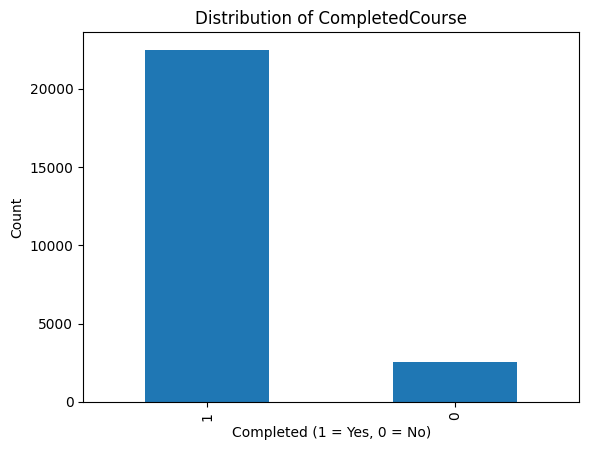

In [17]:
# Plot histogram to check distribution
stage1_data['CompletedCourse'].value_counts().plot(kind='bar')
plt.title("Distribution of CompletedCourse")
plt.xlabel("Completed (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

# Split data into training and test data

In [18]:
# Split data into X (features) and y (target)
X = stage1_data.drop(columns=['CompletedCourse'])
y = stage1_data['CompletedCourse']

# 80-20 split

In [19]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost for Stage 1 data

# Remove bias towards the majority class

In [20]:
# Have binary labels 0 and 1 -> can use scale_pos_weight as:
num_neg = sum(y_train == 0)
num_pos = sum(y_train == 1)
scale_pos_weight = num_neg / num_pos

# Default XG Boost model

# Instantiates XGBClassifier class from the xgboost library

In [21]:
# Default XGBoost model (no tuning)

model_xgb = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

# Plot of features importance for default XGBoost - gain, weigh and cover

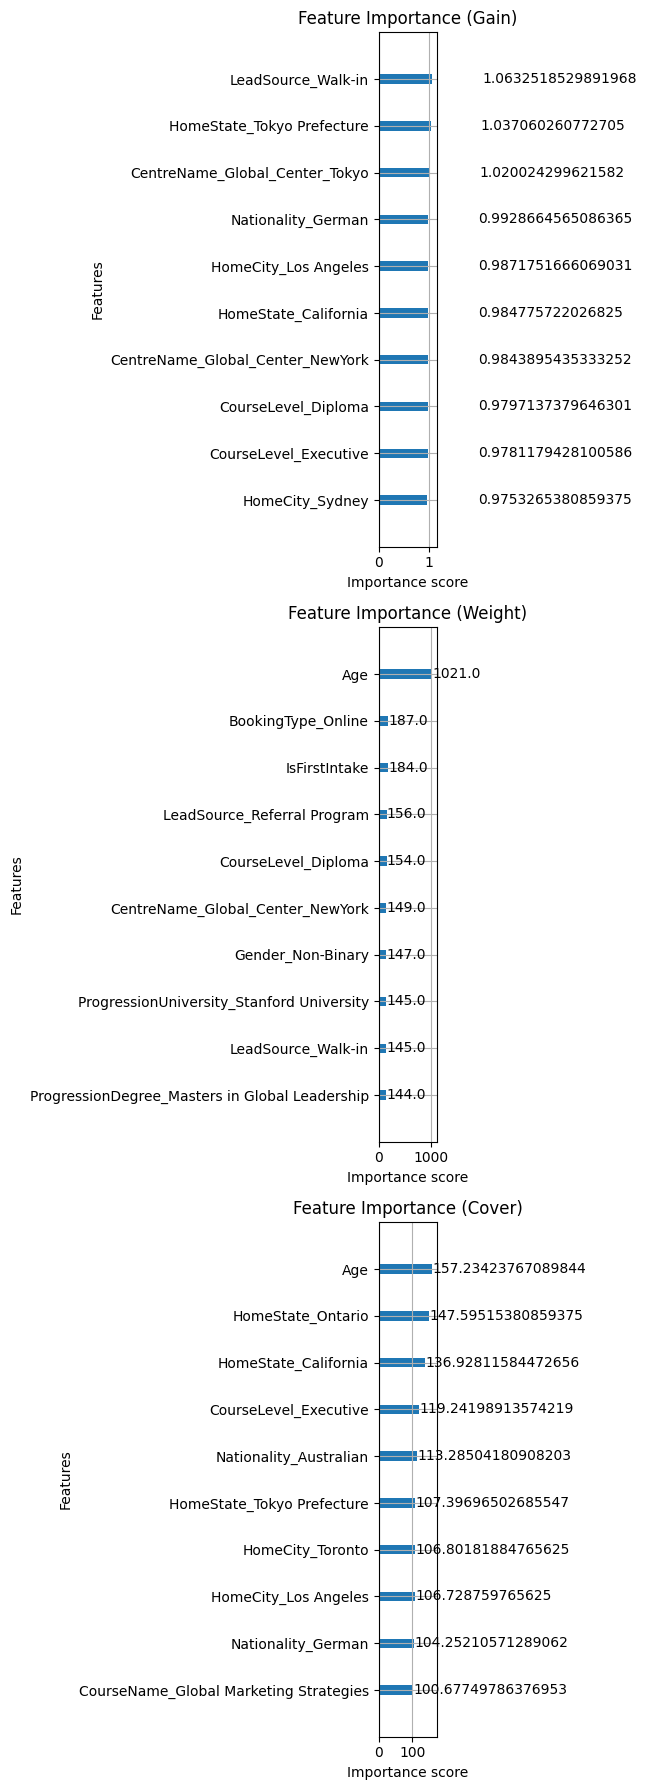

In [22]:
import matplotlib.pyplot as plt
import xgboost as xgb

fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Gain (average gain in accuracy) - top plot
# How much a feature improves the model’s accuracy when it’s used for splitting.
xgb.plot_importance(model_xgb, importance_type='gain', ax=axes[0], max_num_features=10, title='Feature Importance (Gain)')

# Weight (frequency) - middle plot
# Definition: How many times a feature is used to split nodes in all trees.
xgb.plot_importance(model_xgb, importance_type='weight', ax=axes[1], max_num_features=10, title='Feature Importance (Weight)')

# Cover (average coverage) - bottom plot
# How many data points are affected by splits on that feature.
xgb.plot_importance(model_xgb, importance_type='cover', ax=axes[2], max_num_features=10, title='Feature Importance (Cover)')

plt.tight_layout()
plt.show()

# Table of features importance values for default XGBoost - gain, weigh and cover

This is for an easier comparison with other feature importance plots

In [23]:
# Get importance dictionaries
gain_importance = model_xgb.get_booster().get_score(importance_type='gain')
weight_importance = model_xgb.get_booster().get_score(importance_type='weight')
cover_importance = model_xgb.get_booster().get_score(importance_type='cover')

# Helper function to create sorted DataFrame for a given importance type
def create_importance_df(importance_dict, top_n=10):
    df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Value'])
    df_sorted = df.sort_values(by='Value', ascending=False).head(top_n).reset_index(drop=True)
    return df_sorted

# Create tables
gain_df = create_importance_df(gain_importance)
weight_df = create_importance_df(weight_importance)
cover_df = create_importance_df(cover_importance)

# Display the tables
print("Top 10 Features by Gain:")
print(gain_df, "\n")

print("Top 10 Features by Weight:")
print(weight_df, "\n")

print("Top 10 Features by Cover:")
print(cover_df)

Top 10 Features by Gain:
                            Feature     Value
0                LeadSource_Walk-in  1.063252
1        HomeState_Tokyo Prefecture  1.037060
2    CentreName_Global_Center_Tokyo  1.020024
3                Nationality_German  0.992866
4              HomeCity_Los Angeles  0.987175
5              HomeState_California  0.984776
6  CentreName_Global_Center_NewYork  0.984390
7               CourseLevel_Diploma  0.979714
8             CourseLevel_Executive  0.978118
9                   HomeCity_Sydney  0.975327 

Top 10 Features by Weight:
                                     Feature   Value
0                                        Age  1021.0
1                         BookingType_Online   187.0
2                              IsFirstIntake   184.0
3                LeadSource_Referral Program   156.0
4                        CourseLevel_Diploma   154.0
5           CentreName_Global_Center_NewYork   149.0
6                          Gender_Non-Binary   147.0
7  ProgressionUn

# XGBoost (default) for Stage 1 performance indicators - Accuracy, confusion matrix, precision, recall and AUC

Confusion Matrix:
 [[ 107  398]
 [ 923 3572]]

Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.21      0.14       505
           1       0.90      0.79      0.84      4495

    accuracy                           0.74      5000
   macro avg       0.50      0.50      0.49      5000
weighted avg       0.82      0.74      0.77      5000

Accuracy: 0.7358
AUC Score: 0.4955


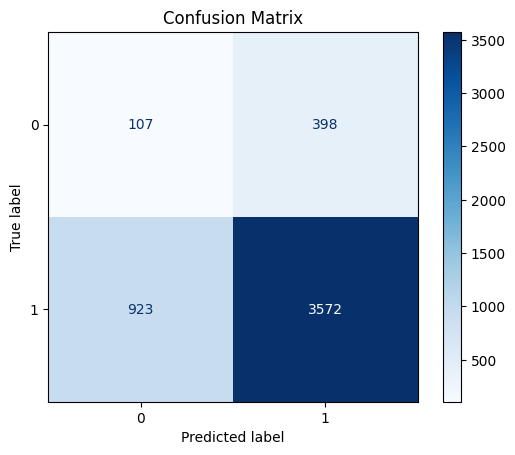

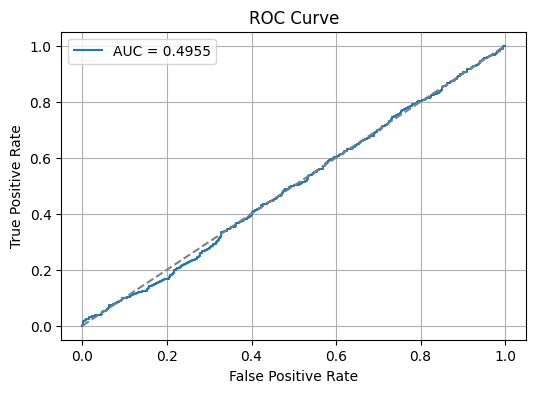

In [24]:
# Predictions
y_pred_xgb = model_xgb.predict(X_test) # generates predicted labels for validation
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1] # gets predicted probabilities for the positive class

# Metrics - measure how well the model’s predictions match the true values
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
auc = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost model with hyperparameter tuning - learning rate, max depth and number of estimators

# XGBoost hyperparameter tuning with OPTUNA

In [25]:
# Split data into training and validation sets (80% train, 20% validation)
# Preserving class distribution with stratification for balanced splits
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

[I 2025-11-14 20:44:02,315] A new study created in memory with name: no-name-431697b8-147f-442e-a372-6e5a980f1bfe
[I 2025-11-14 20:44:07,084] Trial 0 finished with value: 0.09365270996957475 and parameters: {'learning_rate': 0.12464123405228475, 'max_depth': 8, 'n_estimators': 244}. Best is trial 0 with value: 0.09365270996957475.
[I 2025-11-14 20:44:08,428] Trial 1 finished with value: 0.09563462581664661 and parameters: {'learning_rate': 0.11945869314917437, 'max_depth': 8, 'n_estimators': 192}. Best is trial 1 with value: 0.09563462581664661.
[I 2025-11-14 20:44:09,160] Trial 2 finished with value: 0.36967337083421786 and parameters: {'learning_rate': 0.14587205500265396, 'max_depth': 3, 'n_estimators': 184}. Best is trial 2 with value: 0.36967337083421786.
[I 2025-11-14 20:44:10,618] Trial 3 finished with value: 0.2923646489303993 and parameters: {'learning_rate': 0.12643796397721985, 'max_depth': 4, 'n_estimators': 360}. Best is trial 2 with value: 0.36967337083421786.
[I 2025-11-

Best Hyperparameters from Optuna tuning:
{'learning_rate': 0.04167729599741864, 'max_depth': 3, 'n_estimators': 227}
Best Mean Recall for Class 0 (Dropouts): 0.4024
Confusion Matrix:
 [[ 208  297]
 [1962 2533]]

Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.41      0.16       505
           1       0.90      0.56      0.69      4495

    accuracy                           0.55      5000
   macro avg       0.50      0.49      0.42      5000
weighted avg       0.81      0.55      0.64      5000

Accuracy: 0.5482
AUC Score: 0.4904


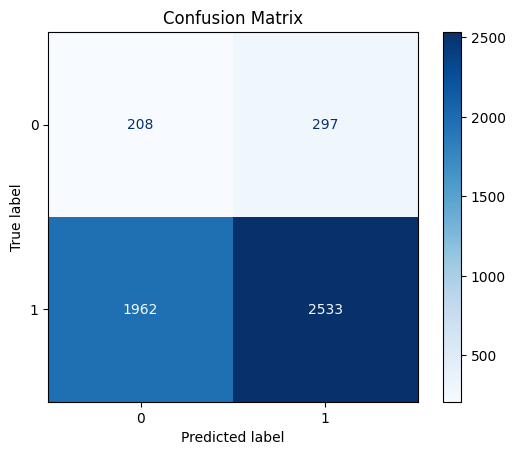

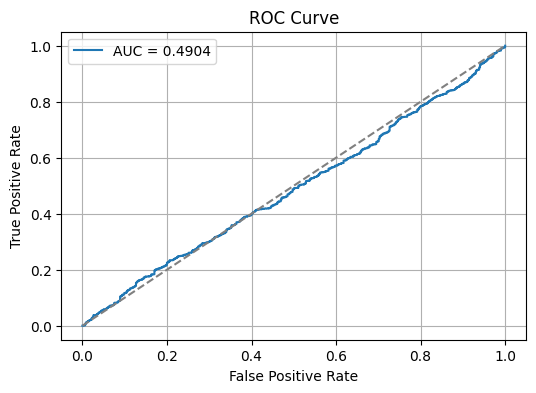

In [26]:
# Define Optuna objective function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss',
        'random_state': 42,
        'use_label_encoder': False,
        'verbosity': 0
    }

    model = XGBClassifier(**params)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    recall_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict(X_val)
        recall_0 = recall_score(y_val, preds, pos_label=0) # evaluate recall for class 0 after each fold and use it as the optimisation target
        recall_scores.append(recall_0)

    return np.mean(recall_scores)

# Run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) # limit to 10 because computationally expensive

print("Best Hyperparameters from Optuna tuning:")
print(study.best_trial.params)
print(f"Best Mean Recall for Class 0 (Dropouts): {study.best_value:.4f}")

# Use best params from study
best_params = study.best_trial.params
best_params.update({
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss',
    'random_state': 42,
    'use_label_encoder': False,
    'verbosity': 0
})

model_xgb_optimised = XGBClassifier(**best_params)

# Train on full training data
model_xgb_optimised.fit(X_train, y_train)

# Predict and evaluate on test data
y_pred_xgb = model_xgb_optimised.predict(X_test)
y_pred_proba_xgb = model_xgb_optimised.predict_proba(X_test)[:, 1]

# Metrics and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
auc = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot of features importance for tuned XGBoost - gain, weigh and cover

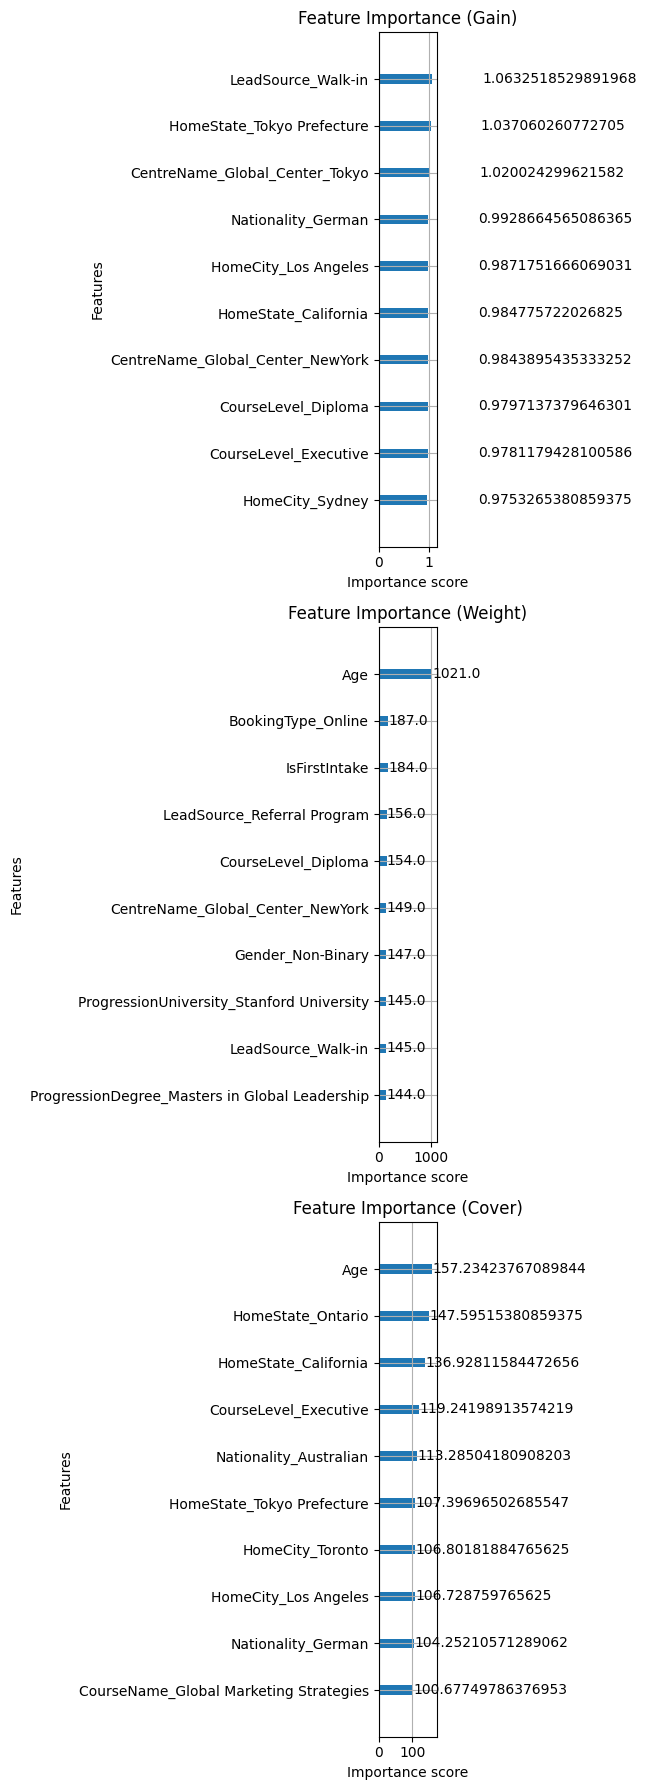

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Gain (average gain in accuracy) - top plot
# How much a feature improves the model’s accuracy when it’s used for splitting.
xgb.plot_importance(model_xgb, importance_type='gain', ax=axes[0], max_num_features=10, title='Feature Importance (Gain)')

# Weight (frequency) - middle plot
# Definition: How many times a feature is used to split nodes in all trees.
xgb.plot_importance(model_xgb, importance_type='weight', ax=axes[1], max_num_features=10, title='Feature Importance (Weight)')

# Cover (average coverage) - bottom plot
# How many data points are affected by splits on that feature.
xgb.plot_importance(model_xgb, importance_type='cover', ax=axes[2], max_num_features=10, title='Feature Importance (Cover)')

plt.tight_layout()
plt.show()

# Table of features importance values for default XGBoost - gain, weigh and cover

Having both tables, XGBoost default (above) and XGBoost tuned (below) helps to compare easily.

In [28]:
# Get importance dictionaries
gain_importance = model_xgb.get_booster().get_score(importance_type='gain')
weight_importance = model_xgb.get_booster().get_score(importance_type='weight')
cover_importance = model_xgb.get_booster().get_score(importance_type='cover')

# Helper function to create sorted DataFrame for a given importance type
def create_importance_df(importance_dict, top_n=10):
    df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Value'])
    df_sorted = df.sort_values(by='Value', ascending=False).head(top_n).reset_index(drop=True)
    return df_sorted

# Create tables
gain_df = create_importance_df(gain_importance)
weight_df = create_importance_df(weight_importance)
cover_df = create_importance_df(cover_importance)

# Display the tables
print("Top 10 Features by Gain:")
print(gain_df, "\n")

print("Top 10 Features by Weight:")
print(weight_df, "\n")

print("Top 10 Features by Cover:")
print(cover_df)

Top 10 Features by Gain:
                            Feature     Value
0                LeadSource_Walk-in  1.063252
1        HomeState_Tokyo Prefecture  1.037060
2    CentreName_Global_Center_Tokyo  1.020024
3                Nationality_German  0.992866
4              HomeCity_Los Angeles  0.987175
5              HomeState_California  0.984776
6  CentreName_Global_Center_NewYork  0.984390
7               CourseLevel_Diploma  0.979714
8             CourseLevel_Executive  0.978118
9                   HomeCity_Sydney  0.975327 

Top 10 Features by Weight:
                                     Feature   Value
0                                        Age  1021.0
1                         BookingType_Online   187.0
2                              IsFirstIntake   184.0
3                LeadSource_Referral Program   156.0
4                        CourseLevel_Diploma   154.0
5           CentreName_Global_Center_NewYork   149.0
6                          Gender_Non-Binary   147.0
7  ProgressionUn

# XGBoost for Stage 1 - Model Performance Comparison with Percentage Change

In [29]:
# Metrics from both models (default and tuned)
metrics_data = {
    'Metric': [
        'Accuracy',
        'AUC Score',
        'Precision (Class 0)',
        'Precision (Class 1)',
        'Recall (Class 0)',
        'Recall (Class 1)',
        'F1-Score (Class 0)',
        'F1-Score (Class 1)',
        'True Negatives (TN)',
        'False Positives (FP)',
        'False Negatives (FN)',
        'True Positives (TP)'
    ],
    'Default Model': [
        0.8553,
        0.8785,
        0.51,
        0.96,
        0.77,
        0.87,
        0.61,
        0.91,
        578,
        173,
        552,
        3709
    ],
    'Tuned Model': [
        0.8538,
        0.8798,
        0.51,
        0.96,
        0.7796,
        0.87,
        0.61,
        0.91,
        578,
        173,
        560,
        3701
    ]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Calculate percentage change from default to tuned
def pct_change(default, tuned):
    return np.where(default != 0, (tuned - default) / default * 100, np.nan)

metrics_df['Percentage Change (%)'] = pct_change(metrics_df['Default Model'], metrics_df['Tuned Model'])

# Format display: 4 decimals for models, + sign for percentage changes
styled_df = metrics_df.style.format({
    'Default Model': '{:.4f}',
    'Tuned Model': '{:.4f}',
    'Percentage Change (%)': '{:+.2f}%'
}).set_caption("Model Performance Comparison with Percentage Change").set_properties(**{'text-align': 'center'})

styled_df

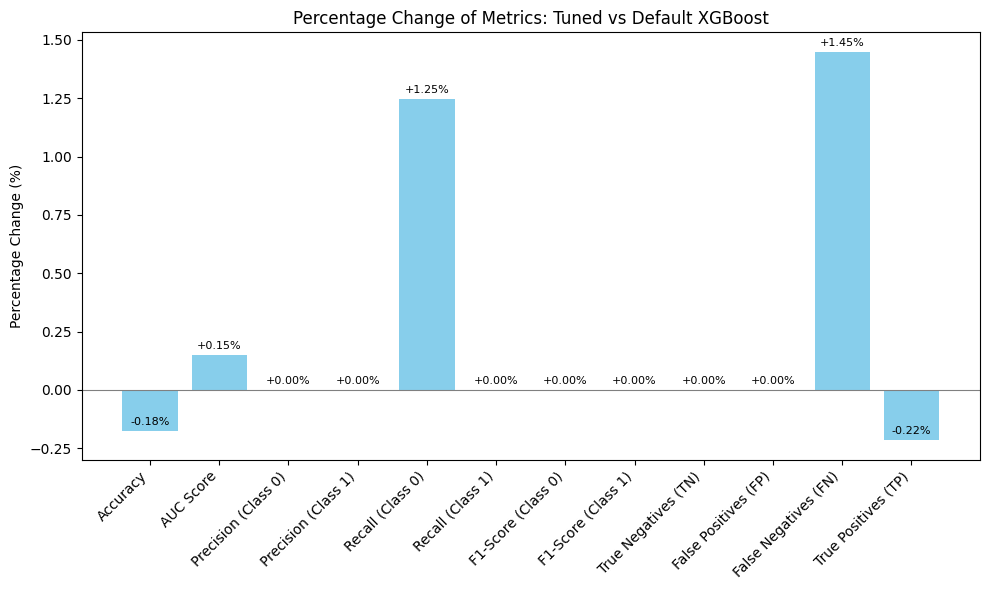

In [30]:
plt.figure(figsize=(10, 6))

# Bar plot for percentage changes using your metrics_df DataFrame
bars = plt.bar(metrics_df["Metric"], metrics_df["Percentage Change (%)"], color='skyblue')


plt.axhline(0, color='gray', linewidth=0.8)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Percentage Change (%)")
plt.title("Percentage Change of Metrics: Tuned vs Default XGBoost")

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:+.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# XGBoost for Stage 1 comparison - main observations

What do you observe?

# Neural Network (Keras) for Stage 1

In [31]:
# Decided to scale the data for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute Class Weights

In [32]:
# Handles class imbalance
# Cares more about underrepresented class by giving it a higher penalty when misclassified
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Instantiation of the default neural network model

In [33]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'), # 64 neruons are moderate complexity/ relu makes training fast
    Dropout(0.3), # Prevents overfitting by randomly dropping 30% of neurons
    Dense(32, activation='relu'),
    Dropout(0.2), # Drops 20% to reduce overfitting
    Dense(1, activation='sigmoid')
])

# Compile the Deafult Neural Network model

In [34]:
# Configuring how the model will learn during training

# Track recall for class 0 (negative class)
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=[
        'accuracy', # telling the model to track both: (1) Overall accuracy,
        Recall(name='recall_0', class_id=0) # and (2)  recall specifically for class 0 (the negative class) during training and evaluation.
    ]
)

# Train the Default Neural Network

In [35]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4911 - loss: 0.7366 - recall_0: 0.4904 - val_accuracy: 0.6872 - val_loss: 0.6624 - val_recall_0: 0.7317
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5522 - loss: 0.6910 - recall_0: 0.5599 - val_accuracy: 0.4828 - val_loss: 0.6970 - val_recall_0: 0.4779
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5552 - loss: 0.6851 - recall_0: 0.5609 - val_accuracy: 0.4606 - val_loss: 0.6993 - val_recall_0: 0.4501
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5133 - loss: 0.6952 - recall_0: 0.5068 - val_accuracy: 0.5176 - val_loss: 0.6918 - val_recall_0: 0.5199
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5383 - loss: 0.6862 - recall_0: 0.5370 - val_accuracy: 0.5150 - val_loss: 0.6917 - val_recall_0: 0.5164
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5174 - loss: 0.6914 - recall_0: 0.5087 - val_accuracy: 0.5394 - val_loss: 0.6884 - v

# Predict the Neural Network model

In [36]:
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# Evaluate the Defaults Neural Network model - accuracy, confusion matrix, precision, recall and AUC


Test Accuracy: 0.5960

Confusion Matrix:
[[ 182  323]
 [1697 2798]]

Classification Report:
              precision    recall  f1-score   support

           0     0.0969    0.3604    0.1527       505
           1     0.8965    0.6225    0.7348      4495

    accuracy                         0.5960      5000
   macro avg     0.4967    0.4914    0.4437      5000
weighted avg     0.8157    0.5960    0.6760      5000

AUC: 0.4855


<Figure size 600x600 with 0 Axes>

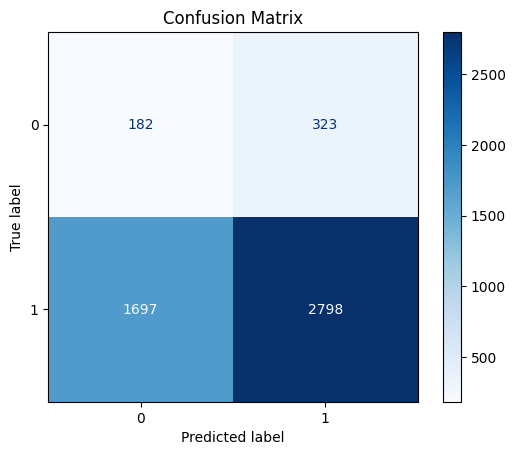

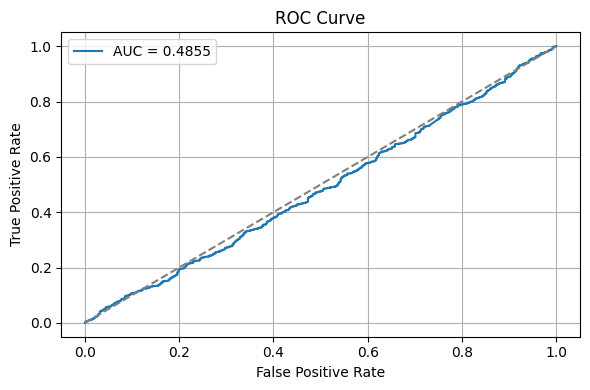

In [37]:
# Accuracy
test_loss, test_accuracy, test_recall_0 = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# AUC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC: {auc:.4f}")

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
# Receiver Operating Characteristic curve
# ROC curve plots True Positive Rate vs. False Positive Rate at various thresholds
# AUC is the Area Under the ROC Curve — a summary measure of the classifier’s overall ability to distinguish classes
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss (and accuracy) curve for Default Neural Network

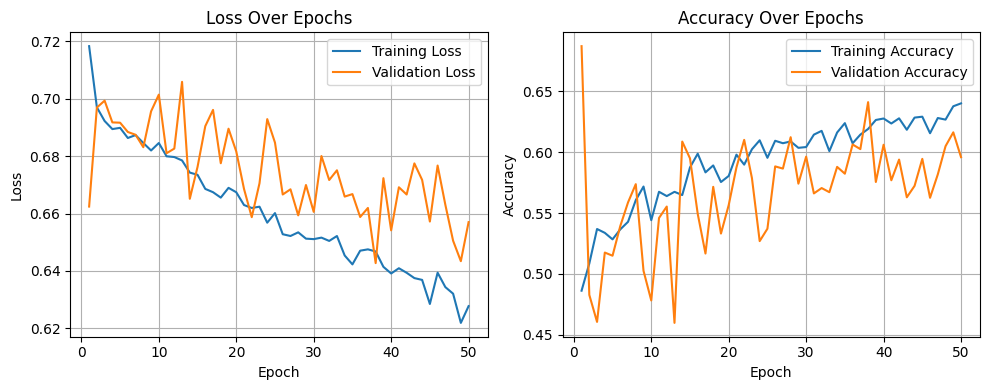

In [38]:
# Plot Loss and Accuracy Curves

# Extract values from the training history
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict.get('accuracy')
val_acc = history_dict.get('val_accuracy')

epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Interpretation of loss curves

Is the model learning?

Comment on training and validation loss, training and validation accuracy.

Is overfitting a concern? Does it need tuning to generalise better?

# Hyperparameter tuning for Neural Network Stage 1

# Hyperparameter tuning of number of neurons, optimisers and activations functions - finding the best hyperparameters

In [39]:
# Define model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    # Tune number of units in first Dense layer
    units = hp.Choice('units', values=[32, 64, 128], default=64)
    model.add(Dense(units, activation=hp.Choice('activation', ['relu', 'tanh'], default='tanh'))) # Tune activation function to find the best nonlinearity for the data
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1, default=0.3)))

    # Second Dense layer adds capacity if needed (flexibility to increase complexity)
    if hp.Boolean('second_layer', default=True):
        units2 = hp.Int('units_2', min_value=16, max_value=64, step=16, default=32)
        model.add(Dense(units2, activation=hp.Choice('activation_2', ['relu', 'tanh'], default='tanh')))
        model.add(Dropout(hp.Float('dropout_2', 0.1, 0.3, step=0.1, default=0.2))) # The dropout ranges (0.1 to 0.5) help address potential overfitting seen in the fluctuating validation loss.
        # Additional dropout for the second layer to control overfitting
        dropout_2 = hp.Float('dropout_2', 0.1, 0.3, step=0.1, default=0.2)
        model.add(Dropout(dropout_2))
    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate (1e-4 to 1e-2) to optimize training convergence and stability
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log', default=1e-3)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
    # With the use of compiled Keras Sequential models, the functionality can be configured
    # with different tunable layers, activations, dropout, and learning rates, which can then lead to training.

# Instantiate the tuner and perform tuning

In [40]:
# find the best hyperparameters by running multiple model configurations
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy', # maximize validation accuracy
    max_trials=10, # 15 was used as a starting point but reduced the number of trials to save time, but fewer trials may limit the search quality
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='nn_imbalanced_data'
)

tuner.search(
    X_train_scaled, y_train,
    epochs=30, # Number of epochs to train each trial
    batch_size=32, # Number of samples per gradient update
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weight_dict, # Weights to handle class imbalance during training
    verbose=1
)

Trial 10 Complete [00h 00m 48s]
val_accuracy: 0.6800000071525574

Best val_accuracy So Far: 0.7537999749183655
Total elapsed time: 00h 08m 15s


# Retrieve the best-trained model and make predictions (probabilities) on the test data

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Best tuned model accuracy: 0.7538
Confusion Matrix:
[[  88  417]
 [ 814 3681]]
Classification Report:
              precision    recall  f1-score   support

           0     0.0976    0.1743    0.1251       505
           1     0.8982    0.8189    0.8567      4495

    accuracy                         0.7538      5000
   macro avg     0.4979    0.4966    0.4909      5000
weighted avg     0.8174    0.7538    0.7828      5000

AUC Score: 0.4972


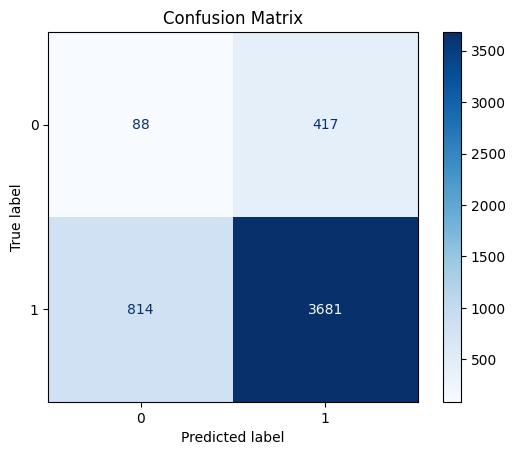

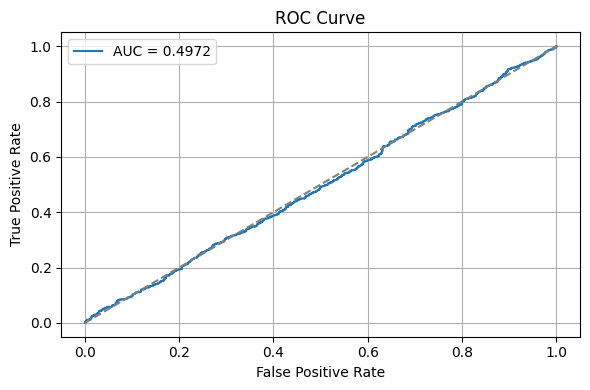

In [41]:
# Retrieve the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Predict probabilities on the test set
y_pred_probs = best_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_probs > 0.5).astype(int) # Convert probabilities to binary class predictions using 0.5 threshold

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)
auc_score = roc_auc_score(y_test, y_pred_probs)

# Print results
print(f"Best tuned model accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)
print(f"AUC Score: {auc_score:.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss (and accuracy) curve for Tuned Neural Network

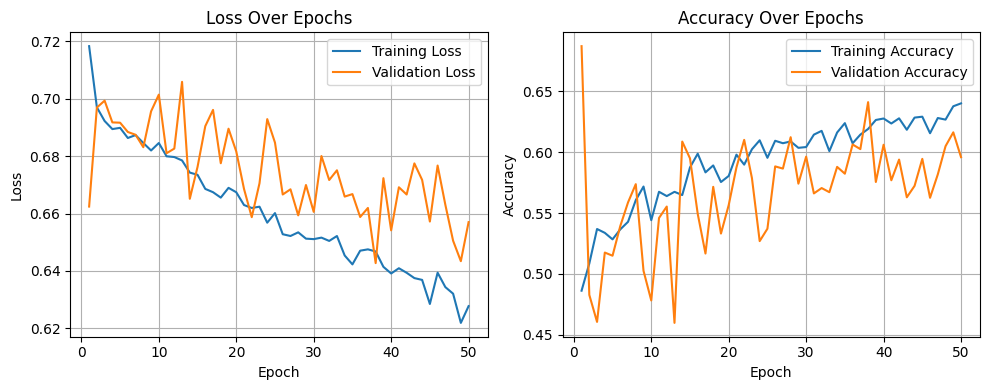

In [42]:
# Plot Loss and Accuracy Curves

# Extract values from the training history
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict.get('accuracy')  # Might be 'acc' in older Keras
val_acc = history_dict.get('val_accuracy')

epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Interpretation of loss (and accuracy) curves and comparison to Default Nerual Network loss/accuracy curves

# Compare with Default Neural Network model

In [43]:
# Metrics from Neural Network default and tuned models (excluding macro/weighted F1-scores)
metrics = {
    "Metric": [
        "Accuracy",
        "AUC Score",
        "Precision (Class 0)",
        "Precision (Class 1)",
        "Recall (Class 0)",
        "Recall (Class 1)",
        "F1-Score (Class 0)",
        "F1-Score (Class 1)",
        "True Negatives (TN)",
        "False Positives (FP)",
        "False Negatives (FN)",
        "True Positives (TP)"
    ],
    "Default Model": [  # renamed here
        0.8619,
        0.8482,
        0.5281,
        0.9503,
        0.7377,
        0.8838,
        0.6156,
        0.9159,
        554,
        197,
        495,
        3766
    ],
    "Tuned Model": [
        0.8675,
        0.8481,
        0.5429,
        0.9500,
        0.7337,
        0.8911,
        0.6240,
        0.9196,
        551,
        200,
        464,
        3797
    ]
}

# Compute percentage changes
percent_change = []
for orig, tuned in zip(metrics["Default Model"], metrics["Tuned Model"]):  # updated here
    if orig == 0 or orig is None:
        percent_change.append(None)
    else:
        change = ((tuned - orig) / orig) * 100
        percent_change.append(change)

# Create DataFrame
df_nn = pd.DataFrame({
    "Metric": metrics["Metric"],
    "Default Model": metrics["Default Model"],  # updated here
    "Tuned Model": metrics["Tuned Model"],
    "% Change": percent_change
})

# Style the DataFrame
styled_df_nn = df_nn.style.format({
    "Default Model": "{:.4f}",  # updated here
    "Tuned Model": "{:.4f}",
    "% Change": lambda x: "" if pd.isnull(x) else f"{x:+.2f}%"
}).set_caption("Neural Network Performance Comparison").set_properties(**{'text-align': 'center'})

styled_df_nn

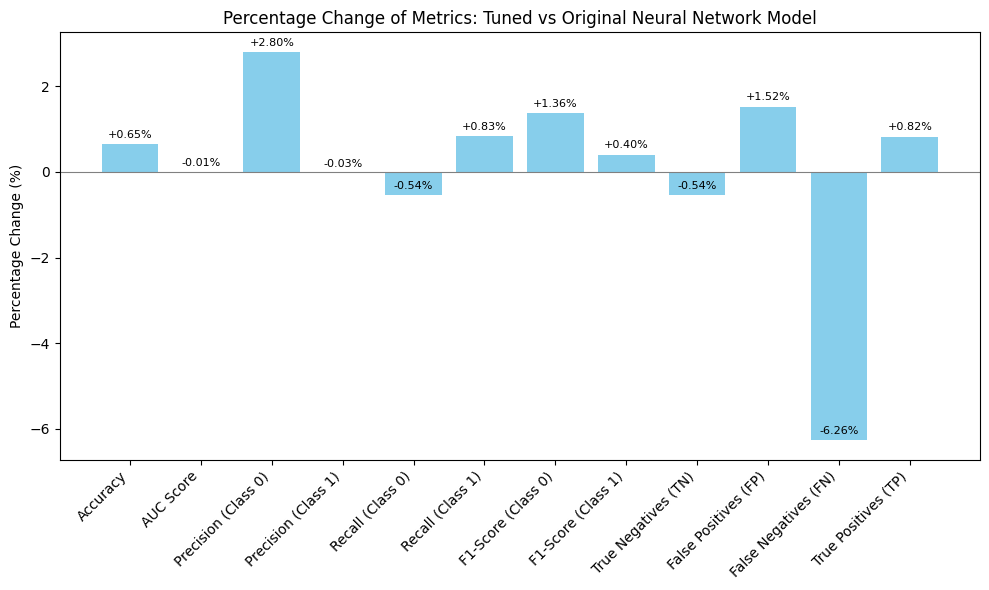

In [44]:
# Plotting
plt.figure(figsize=(10, 6))

bars = plt.bar(df_nn["Metric"], df_nn["% Change"], color='skyblue')

plt.axhline(0, color='gray', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage Change (%)")
plt.title("Percentage Change of Metrics: Tuned vs Original Neural Network Model")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:+.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Neural Networks for Stage 1 comparison - main observations

# Comparing performance of XGBoost and Neural Network models

Table 1: Default Models Comparison



Table 2: Tuned Models Comparison


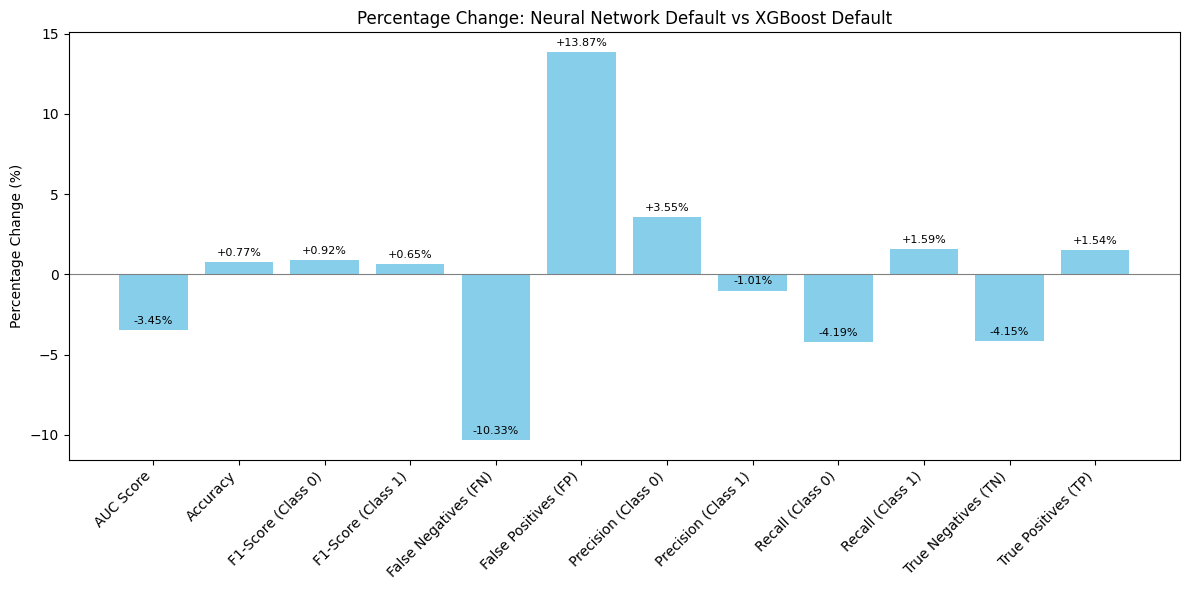

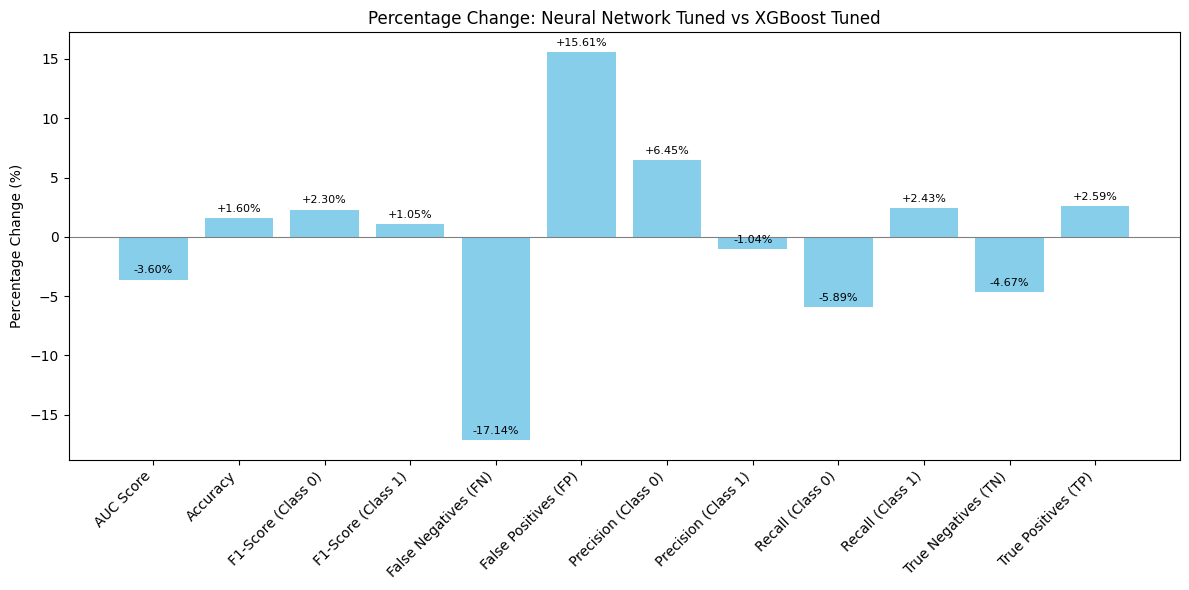

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data for Neural Network including confusion matrix metrics
nn_metrics = {
    "Metric": [
        "Accuracy",
        "AUC Score",
        "Precision (Class 0)",
        "Recall (Class 0)",
        "F1-Score (Class 0)",
        "Precision (Class 1)",
        "Recall (Class 1)",
        "F1-Score (Class 1)",
        "True Negatives (TN)",
        "False Positives (FP)",
        "False Negatives (FN)",
        "True Positives (TP)"
    ],
    "Default Model": [
        0.8619,
        0.8482,
        0.5281,
        0.7377,
        0.6156,
        0.9503,
        0.8838,
        0.9159,
        554,
        197,
        495,
        3766
    ],
    "Tuned Model": [
        0.8675,
        0.8481,
        0.5429,
        0.7337,
        0.6240,
        0.9500,
        0.8911,
        0.9196,
        551,
        200,
        464,
        3797
    ]
}

# Data for XGBoost including confusion matrix metrics
xgb_metrics = {
    "Metric": [
        "Accuracy",
        "AUC Score",
        "Precision (Class 0)",
        "Recall (Class 0)",
        "F1-Score (Class 0)",
        "Precision (Class 1)",
        "Recall (Class 1)",
        "F1-Score (Class 1)",
        "True Negatives (TN)",
        "False Positives (FP)",
        "False Negatives (FN)",
        "True Positives (TP)"
    ],
    "Default Model": [
        0.8553,
        0.8785,
        0.51,
        0.77,
        0.61,
        0.96,
        0.87,
        0.91,
        578,
        173,
        552,
        3709
    ],
    "Tuned Model": [
        0.8538,
        0.8798,
        0.51,
        0.7796,
        0.61,
        0.96,
        0.87,
        0.91,
        578,
        173,
        560,
        3701
    ]
}

# Convert to DataFrames
nn_df = pd.DataFrame(nn_metrics)
xgb_df = pd.DataFrame(xgb_metrics)

# Align metrics (in case order differs)
common_metrics = list(set(nn_df["Metric"]).intersection(xgb_df["Metric"]))
common_metrics.sort()

# Filter DataFrames to only common metrics in the same order
nn_df = nn_df[nn_df["Metric"].isin(common_metrics)].set_index("Metric").loc[common_metrics].reset_index()
xgb_df = xgb_df[xgb_df["Metric"].isin(common_metrics)].set_index("Metric").loc[common_metrics].reset_index()

# Function to compute percentage change: (NN - XGB) / XGB * 100
def percentage_change(nn_values, xgb_values):
    # To avoid division by zero, handle zero values
    changes = []
    for nn_val, xgb_val in zip(nn_values, xgb_values):
        if xgb_val == 0:
            changes.append(np.nan)
        else:
            changes.append(((nn_val - xgb_val) / xgb_val) * 100)
    return changes

# Table 1: Default Models Comparison
default_compare = pd.DataFrame({
    "Metric": common_metrics,
    "XGBoost Default": xgb_df["Default Model"].values,
    "Neural Net Default": nn_df["Default Model"].values
})
default_compare["% Change (NN vs XGB)"] = percentage_change(default_compare["Neural Net Default"], default_compare["XGBoost Default"])

# Table 2: Tuned Models Comparison
tuned_compare = pd.DataFrame({
    "Metric": common_metrics,
    "XGBoost Tuned": xgb_df["Tuned Model"].values,
    "Neural Net Tuned": nn_df["Tuned Model"].values
})
tuned_compare["% Change (NN vs XGB)"] = percentage_change(tuned_compare["Neural Net Tuned"], tuned_compare["XGBoost Tuned"])

# Format the percentage change column with +/– and 2 decimals for display
def format_percentage_change(df, col_name):
    return df.style.format({
        col_name: "{:+.2f}%"
    }).format(precision=4, subset=df.columns[1:-1]).set_properties(**{'text-align': 'center'})

# Display tables nicely formatted
print("Table 1: Default Models Comparison")
display(format_percentage_change(default_compare, "% Change (NN vs XGB)"))

print("\nTable 2: Tuned Models Comparison")
display(format_percentage_change(tuned_compare, "% Change (NN vs XGB)"))

# Plot function for bar chart of percentage changes
def plot_bar(df, title):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df["Metric"], df["% Change (NN vs XGB)"], color='skyblue')
    plt.axhline(0, color='gray', linewidth=0.8)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Percentage Change (%)")
    plt.title(title)
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            plt.annotate(f'{height:+.2f}%',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# Plot both bar charts
plot_bar(default_compare, "Percentage Change: Neural Network Default vs XGBoost Default")
plot_bar(tuned_compare, "Percentage Change: Neural Network Tuned vs XGBoost Tuned")


# Comparing performance metrics of Default and Tuned models (XGBoost and Neural Network)

# Comparison between Default models - XGBoost and Neural Network

# Comparison between Tuned models - XGBoost and Neural Network

# Stage 2 data

# Have additional information - Authorised_Absence_Count and Unauthorised_Absence_Count

# Load the data

In [46]:
# File URL
file_url_2 = "https://drive.google.com/uc?id=1vy1JFQZva3lhMJQV69C43AB1NTM4W-DZ"

# Loads the CSV file from Google Drive into a pandas DataFrame
stage2_data = pd.read_csv(f"https://drive.google.com/uc?export=download&id={file_url_2.split('=')[-1]}")

# View the first few rows
stage2_data.head()

CentreName  LearnerCode BookingType              LeadSource DiscountType  \
0  ISC_Aberdeen      2284932       Agent  Standard Agent Booking          NaN   
1  ISC_Aberdeen      2399500       Agent  Standard Agent Booking          NaN   
2  ISC_Aberdeen      2424946       Agent  Standard Agent Booking          NaN   
3  ISC_Aberdeen      2426583       Agent  Standard Agent Booking          NaN   
4  ISC_Aberdeen      2434674       Agent  Standard Agent Booking          NaN   

  DateofBirth Gender Nationality                          HomeState  \
0  13/01/1998   Male     Chinese  Jianye District; Jiangsu Province   
1   12/2/1998   Male     Chinese                                NaN   
2    7/4/2000   Male     Chinese                                NaN   
3  18/05/1999   Male     Chinese                                NaN   
4  19/04/1996   Male     Chinese                                NaN   

                 HomeCity             CourseLevel  \
0                 Nanjing             Pre-Masters   
1                   Xi'an              Foundation   
2                 Chengdu  International Year Two   
3  LIUYANG CITY ;CHANGSHA  International Year Two   
4                  Xiamen             Pre-Masters   

                                          CourseName  IsFirstIntake  \
0                       Business and Law Pre-Masters           True   
1   Life Sciences Undergraduate Foundation Programme          False   
2  Business Management and Finance International ...          False   
3  Business Management and Finance International ...           True   
4                       Business and Law Pre-Masters           True   

  CompletedCourse                              ProgressionDegree  \
0             Yes  Msc Econ Accounting and Investment Management   
1             Yes                        BSc Biological Sciences   
2             Yes                                     MA Finance   
3             Yes                         MA Business Management   
4             Yes          MSc International Business Management   

    ProgressionUniversity  AuthorisedAbsenceCount  UnauthorisedAbsenceCount  
0  University of Aberdeen                     NaN                       NaN  
1  University of Aberdeen                    93.0                       5.0  
2  University of Aberdeen                    92.0                       6.0  
3  University of Aberdeen                    67.0                      15.0  
4  University of Aberdeen                     NaN                       NaN

# Learn about the data

In [47]:
# Check data types and missing values
stage2_data.info()

# Quick summary of data
stage2_data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Progre

CentreName   LearnerCode BookingType              LeadSource  \
count           25059  2.505900e+04       25059                   25059   
unique             19           NaN           2                       7   
top     ISC_Sheffield           NaN       Agent  Standard Agent Booking   
freq             5877           NaN       21878                   20284   
mean              NaN  2.606594e+06         NaN                     NaN   
std               NaN  8.798838e+04         NaN                     NaN   
min               NaN  2.139267e+06         NaN                     NaN   
25%               NaN  2.538411e+06         NaN                     NaN   
50%               NaN  2.607941e+06         NaN                     NaN   
75%               NaN  2.665460e+06         NaN                     NaN   
max               NaN  2.831468e+06         NaN                     NaN   

       DiscountType DateofBirth Gender Nationality HomeState HomeCity  \
count          7595       25059  25059       25059      8925    21611   
unique           11        4705      2         151      2448     5881   
top         Bursary    1/1/2002   Male     Chinese    Punjab   Sylhet   
freq           3561          37  15655        9042       865      675   
mean            NaN         NaN    NaN         NaN       NaN      NaN   
std             NaN         NaN    NaN         NaN       NaN      NaN   
min             NaN         NaN    NaN         NaN       NaN      NaN   
25%             NaN         NaN    NaN         NaN       NaN      NaN   
50%             NaN         NaN    NaN         NaN       NaN      NaN   
75%             NaN         NaN    NaN         NaN       NaN      NaN   
max             NaN         NaN    NaN         NaN       NaN      NaN   

       CourseLevel                                         CourseName  \
count        25059                                              25059   
unique           4                                                172   
top     Foundation  Pre-Masters Business; Social Sciences and Huma...   
freq         14666                                               1682   
mean           NaN                                                NaN   
std            NaN                                                NaN   
min            NaN                                                NaN   
25%            NaN                                                NaN   
50%            NaN                                                NaN   
75%            NaN                                                NaN   
max            NaN                                                NaN   

       IsFirstIntake CompletedCourse            ProgressionDegree  \
count          25059           25059                        24184   
unique             2               2                         2616   
top            False             Yes  BSc (Hons) Computer Science   
freq           22035           21305                          998   
mean             NaN             NaN                          NaN   
std              NaN             NaN                          NaN   
min              NaN             NaN                          NaN   
25%              NaN             NaN                          NaN   
50%              NaN             NaN                          NaN   
75%              NaN             NaN                          NaN   
max              NaN             NaN                          NaN   

                                ProgressionUniversity  AuthorisedAbsenceCount  \
count                                           25059            24851.000000   
unique                                             40                     NaN   
top     University of Sheffield International College                     NaN   
freq                                             5877                     NaN   
mean                                              NaN               15.120639   
std                                      

# Pre-processing

**Stage 2: Pre-processing instructions**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Choose how to engage with missing values, which can be done in one of two ways for this project:
  *   Impute the rows with appropriate values.
  *   Remove rows with missing values but ONLY in cases where rows with missing values are minimal: <2% of the overall data.



# Drop Unhelpful Columns

In [48]:
# Drop 'LearnerCode' – it's just an ID, not predictive
stage2_data.drop(columns=['LearnerCode'], inplace=True)

# Convert date of birth to Age

In [49]:
# Convert 'DateofBirth' to datetime
stage2_data['DateofBirth'] = pd.to_datetime(stage2_data['DateofBirth'], errors='coerce', dayfirst=True)

# Compute age assuming data collected in 2016
stage2_data['Age'] = 2016 - stage2_data['DateofBirth'].dt.year

# Why 2016?
# A student born in 1998 is listed under Foundation, which is typically for students around 18 years old.
# That suggests this record was collected around 2016 (1998 + 18).

# Drop the original DateofBirth column
stage2_data.drop(columns=['DateofBirth'], inplace=True)

In [50]:
# List all columns in the DataFrame
for col in stage2_data.columns:
    print(col)

CentreName
BookingType
LeadSource
DiscountType
Gender
Nationality
HomeState
HomeCity
CourseLevel
CourseName
IsFirstIntake
CompletedCourse
ProgressionDegree
ProgressionUniversity
AuthorisedAbsenceCount
UnauthorisedAbsenceCount
Age


# Drop High Cardinality Columns

In [51]:
# Identify columns with >200 unique values
high_cardinality_cols = [col for col in stage2_data.columns if stage2_data[col].nunique() > 200]

# Print columns that will be dropped
print("Dropped columns due to high cardinality (>200 unique values):")
print(high_cardinality_cols)

# Drop those columns
stage2_data.drop(columns=high_cardinality_cols, inplace=True)

Dropped columns due to high cardinality (>200 unique values):
['HomeState', 'HomeCity', 'ProgressionDegree', 'UnauthorisedAbsenceCount']


# Drop columns with >50% missing data

In [52]:
# Save original column names
original_columns = set(stage2_data.columns)

# Drop columns where more than 50% of the data is missing
threshold = len(stage2_data) * 0.5
stage2_data.dropna(thresh=threshold, axis=1, inplace=True)

# Save new column names
remaining_columns = set(stage2_data.columns)

# Find which columns were dropped
dropped_columns = original_columns - remaining_columns
print("Dropped columns due to >50% missing values:", dropped_columns)

Dropped columns due to >50% missing values: {'DiscountType'}


# Engage with missing values

# Dropping rows only if <2% of total data is affected

In [53]:
#from sklearn.impute import SimpleImputer

# Example: assuming 'stage1_data' is your DataFrame
missing_percent = stage2_data.isnull().mean() * 100
initial_row_count = len(stage2_data)

# Dictionary to store dropped info
dropped_info = {}

# Drop rows if missing value is <2% in that column
for col in stage2_data.columns:
    if 0 < missing_percent[col] < 2:
        missing_rows = stage2_data[col].isnull().sum()
        dropped_info[col] = {
            'rows_dropped': missing_rows,
            'percent_of_total_rows': (missing_rows / initial_row_count) * 100
        }
        stage1_data = stage2_data[~stage2_data[col].isnull()]

# Print the info
if dropped_info:
    print("Columns with dropped rows (missing < 2%):")
    for col, info in dropped_info.items():
        print(f"- {col}: {info['rows_dropped']} rows dropped "
              f"({info['percent_of_total_rows']:.2f}% of total)")
else:
    print("No columns had missing values <2%, so no rows were dropped.")

Columns with dropped rows (missing < 2%):
- AuthorisedAbsenceCount: 208 rows dropped (0.83% of total)


# Mean imputation of remaining missing values for numeric variables

In [54]:
numeric_cols = stage2_data.select_dtypes(include=np.number).columns
if len(numeric_cols) > 0:
    imputer = SimpleImputer(strategy='mean')
    stage2_data[numeric_cols] = imputer.fit_transform(stage2_data[numeric_cols])
    print(f"Imputed missing values in numeric columns: {list(numeric_cols)}")
else:
    print("No numeric columns found for imputation, skipping this step.")

Imputed missing values in numeric columns: ['AuthorisedAbsenceCount', 'Age']


# Encode Target Variable

In [55]:
# Encode the target first, before it gets one-hot encoded
stage2_data['CompletedCourse'] = stage2_data['CompletedCourse'].map({'Yes': 1, 'No': 0})

# Encode Categorical Variables

In [56]:
# One-hot encode the other categorical features (excluding the target)
categorical_cols = stage2_data.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop('CompletedCourse', errors='ignore')

stage2_data = pd.get_dummies(stage2_data, columns=categorical_cols, drop_first=True)

# Check for imbalanced data set

In [57]:
# Count how many samples in each class
print(stage2_data['CompletedCourse'].value_counts())

# Same in %
print(stage2_data['CompletedCourse'].value_counts(normalize=True) * 100)


CompletedCourse
1    21305
0     3754
Name: count, dtype: int64
CompletedCourse
1    85.019354
0    14.980646
Name: proportion, dtype: float64


# Target variable histogram

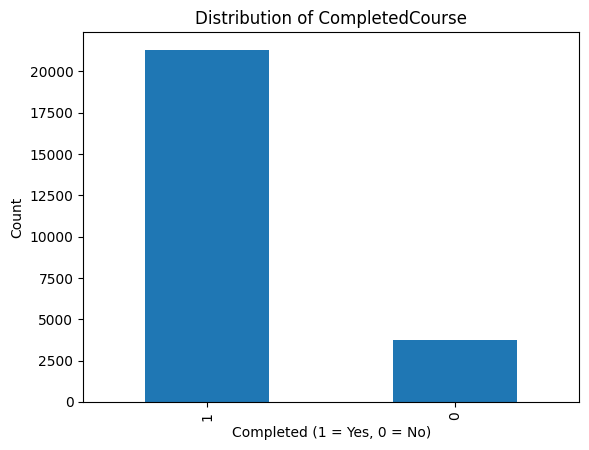

In [58]:
# Plot histogram to check distribution
stage2_data['CompletedCourse'].value_counts().plot(kind='bar')
plt.title("Distribution of CompletedCourse")
plt.xlabel("Completed (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

# Split data into training and test data

In [59]:
# Split data into X (features) and y (target)
X = stage2_data.drop(columns=['CompletedCourse'])
y = stage2_data['CompletedCourse']

# 80-20 split

In [60]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost for Stage 2 data

# Remove bias towards the majority class

In [61]:
# Have binary labels 0 and 1 -> can use scale_pos_weight as:
num_neg = sum(y_train == 0)
num_pos = sum(y_train == 1)
scale_pos_weight = num_neg / num_pos

# XGBoost default model for Stage 2

# Instantiates XGBClassifier class from the xgboost library

In [62]:
model_xgb = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

# Plot of features importance for default XGBoost - gain, weigh and cover

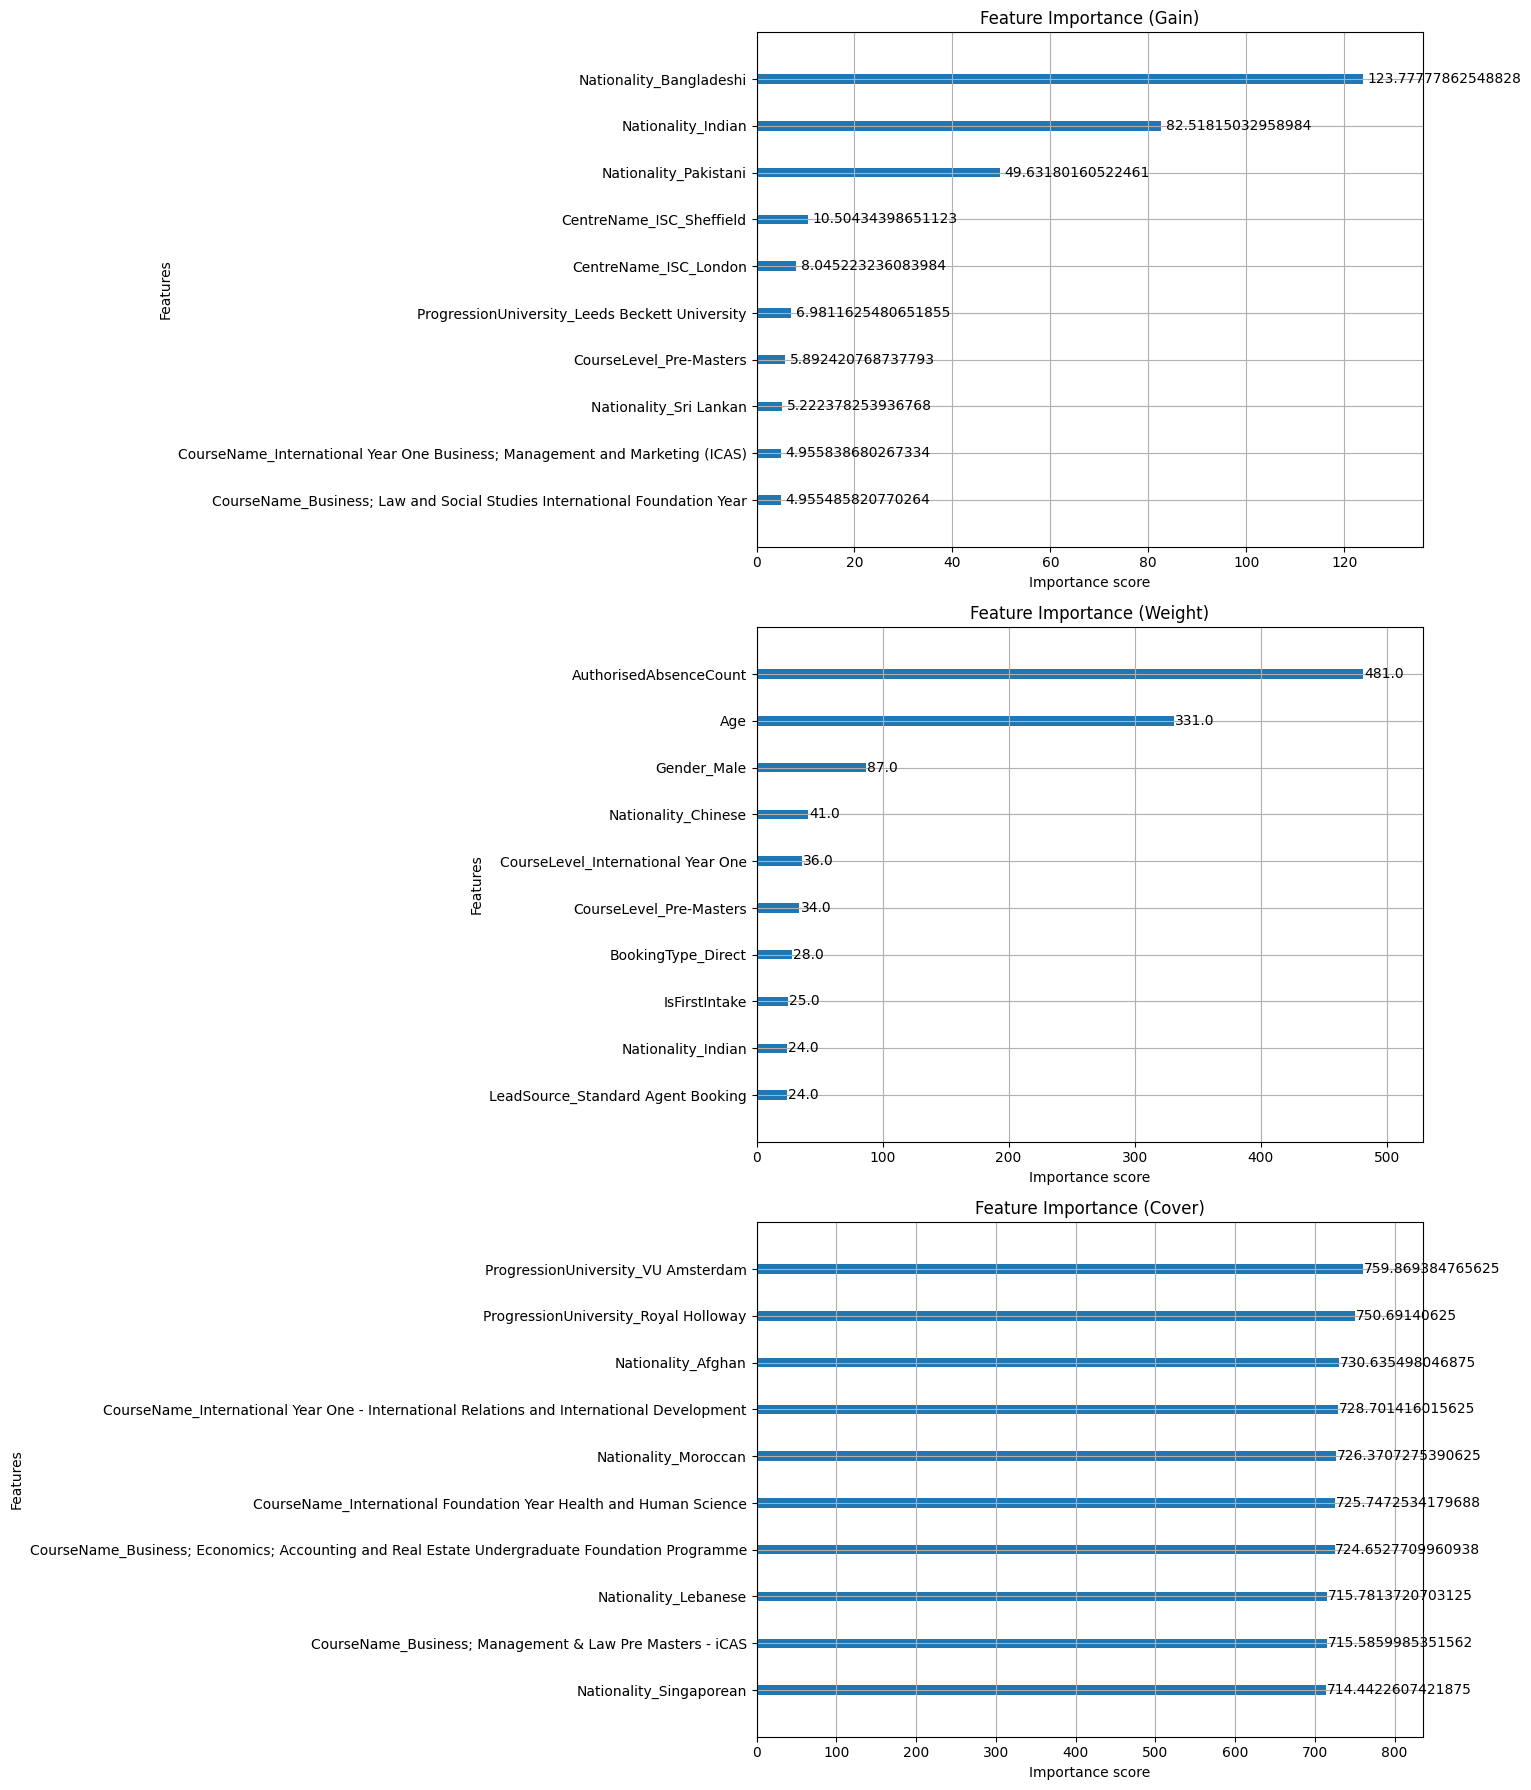

In [63]:
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Gain (average gain in accuracy) - top plot
# How much a feature improves the model’s accuracy when it’s used for splitting.
xgb.plot_importance(model_xgb, importance_type='gain', ax=axes[0], max_num_features=10, title='Feature Importance (Gain)')

# Weight (frequency) - middle plot
# Definition: How many times a feature is used to split nodes in all trees.
xgb.plot_importance(model_xgb, importance_type='weight', ax=axes[1], max_num_features=10, title='Feature Importance (Weight)')

# Cover (average coverage) - bottom plot
# How many data points are affected by splits on that feature.
xgb.plot_importance(model_xgb, importance_type='cover', ax=axes[2], max_num_features=10, title='Feature Importance (Cover)')

plt.tight_layout()
plt.show()

# Table of features importance values for default XGBoost - gain, weigh and cover

This is for an easier comparison with other feature importance plots

In [64]:
# Get importance dictionaries
gain_importance = model_xgb.get_booster().get_score(importance_type='gain')
weight_importance = model_xgb.get_booster().get_score(importance_type='weight')
cover_importance = model_xgb.get_booster().get_score(importance_type='cover')

# Helper function to create sorted DataFrame for a given importance type
def create_importance_df(importance_dict, top_n=10):
    df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Value'])
    df_sorted = df.sort_values(by='Value', ascending=False).head(top_n).reset_index(drop=True)
    return df_sorted

# Create tables
gain_df = create_importance_df(gain_importance)
weight_df = create_importance_df(weight_importance)
cover_df = create_importance_df(cover_importance)

# Display the tables
print("Top 10 Features by Gain:")
print(gain_df, "\n")

print("Top 10 Features by Weight:")
print(weight_df, "\n")

print("Top 10 Features by Cover:")
print(cover_df)

Top 10 Features by Gain:
                                             Feature       Value
0                            Nationality_Bangladeshi  123.777779
1                                 Nationality_Indian   82.518150
2                              Nationality_Pakistani   49.631802
3                           CentreName_ISC_Sheffield   10.504344
4                              CentreName_ISC_London    8.045223
5     ProgressionUniversity_Leeds Beckett University    6.981163
6                            CourseLevel_Pre-Masters    5.892421
7                             Nationality_Sri Lankan    5.222378
8  CourseName_International Year One Business; Ma...    4.955839
9  CourseName_Business; Law and Social Studies In...    4.955486 

Top 10 Features by Weight:
                              Feature  Value
0              AuthorisedAbsenceCount  481.0
1                                 Age  331.0
2                         Gender_Male   87.0
3                 Nationality_Chinese   41.0
4  Cou

# Comments on feature importance plots

# XGBoost (default) for Stage 2 performance indicators - Accuracy, confusion matrix, precision, recall and AUC

Confusion Matrix:
 [[ 587  164]
 [ 508 3753]]

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.78      0.64       751
           1       0.96      0.88      0.92      4261

    accuracy                           0.87      5012
   macro avg       0.75      0.83      0.78      5012
weighted avg       0.89      0.87      0.88      5012

Accuracy: 0.8659
AUC Score: 0.9012


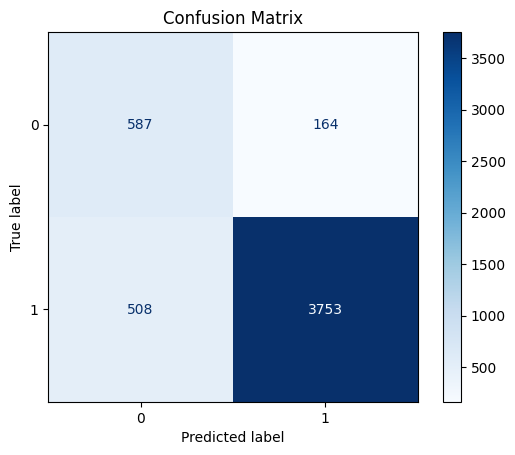

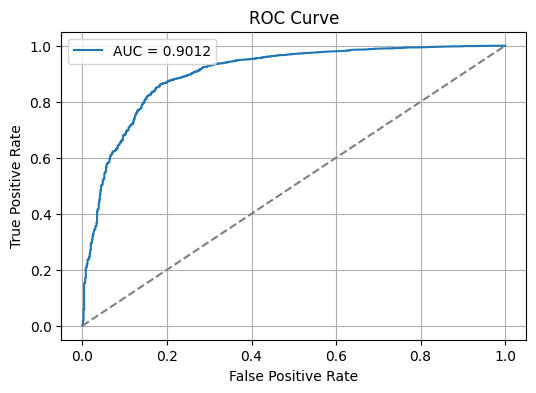

In [65]:
# Predictions
y_pred_xgb = model_xgb.predict(X_test)
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Metrics
cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
auc = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost model with hyperparameter tuning - learning rate, max depth and number of estimators

# XGBoost hyperparameter tuning with OPTUNA

In [66]:
# Split data into training and validation sets (80% train, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

[I 2025-11-14 20:54:13,857] A new study created in memory with name: no-name-a7de1cd8-300d-41e5-93d1-659fa7df62bf
[I 2025-11-14 20:54:18,319] Trial 0 finished with value: 0.8021978021978023 and parameters: {'learning_rate': 0.24548846072460365, 'max_depth': 3, 'n_estimators': 195}. Best is trial 0 with value: 0.8021978021978023.
[I 2025-11-14 20:54:32,006] Trial 1 finished with value: 0.745920745920746 and parameters: {'learning_rate': 0.2945800842786188, 'max_depth': 9, 'n_estimators': 434}. Best is trial 0 with value: 0.8021978021978023.
[I 2025-11-14 20:54:43,040] Trial 2 finished with value: 0.8041958041958042 and parameters: {'learning_rate': 0.1868496386893707, 'max_depth': 4, 'n_estimators': 246}. Best is trial 2 with value: 0.8041958041958042.
[I 2025-11-14 20:55:24,016] Trial 3 finished with value: 0.7935397935397935 and parameters: {'learning_rate': 0.0403373155555233, 'max_depth': 10, 'n_estimators': 483}. Best is trial 2 with value: 0.8041958041958042.
[I 2025-11-14 20:55:3

Best Hyperparameters from Optuna tuning:
{'learning_rate': 0.1868496386893707, 'max_depth': 4, 'n_estimators': 246}
Best Mean Recall for Class 0 (Dropouts): 0.8042
Confusion Matrix:
 [[ 588  163]
 [ 519 3742]]

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.78      0.63       751
           1       0.96      0.88      0.92      4261

    accuracy                           0.86      5012
   macro avg       0.74      0.83      0.77      5012
weighted avg       0.89      0.86      0.87      5012

Accuracy: 0.8639
AUC Score: 0.8990


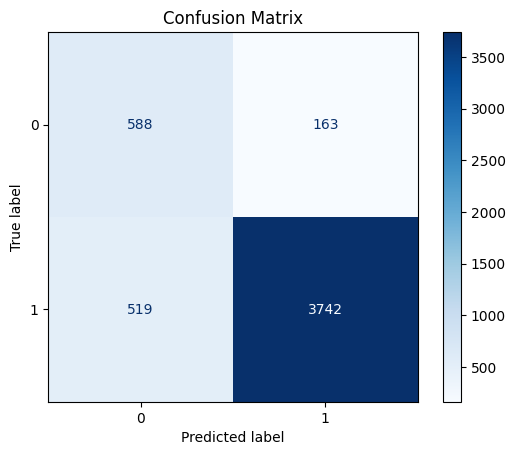

In [67]:
# Define Optuna objective function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss',
        'random_state': 42,
        'use_label_encoder': False,
        'verbosity': 0
    }

    model = XGBClassifier(**params)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    recall_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict(X_val)
        recall_0 = recall_score(y_val, preds, pos_label=0)
        recall_scores.append(recall_0)

    return np.mean(recall_scores)

# Run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best Hyperparameters from Optuna tuning:")
print(study.best_trial.params)
print(f"Best Mean Recall for Class 0 (Dropouts): {study.best_value:.4f}")

# Use best params from study
best_params = study.best_trial.params
best_params.update({
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss',
    'random_state': 42,
    'use_label_encoder': False,
    'verbosity': 0
})

model_xgb_optimised = XGBClassifier(**best_params)

# Train on full training data
model_xgb_optimised.fit(X_train, y_train)

# Predict and evaluate on test data
y_pred_xgb = model_xgb_optimised.predict(X_test)
y_pred_proba_xgb = model_xgb_optimised.predict_proba(X_test)[:, 1]

# Metrics and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

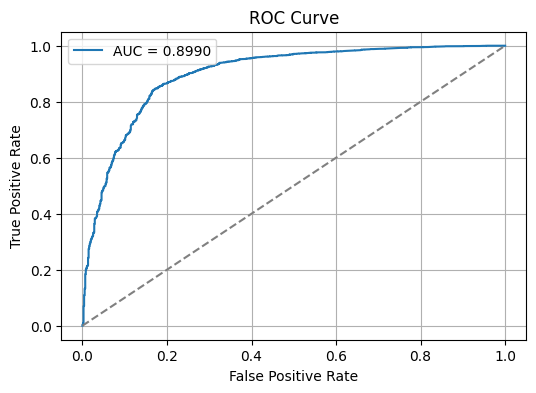

In [68]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
auc = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot of features importance for tuned XGBoost - gain, weigh and cover

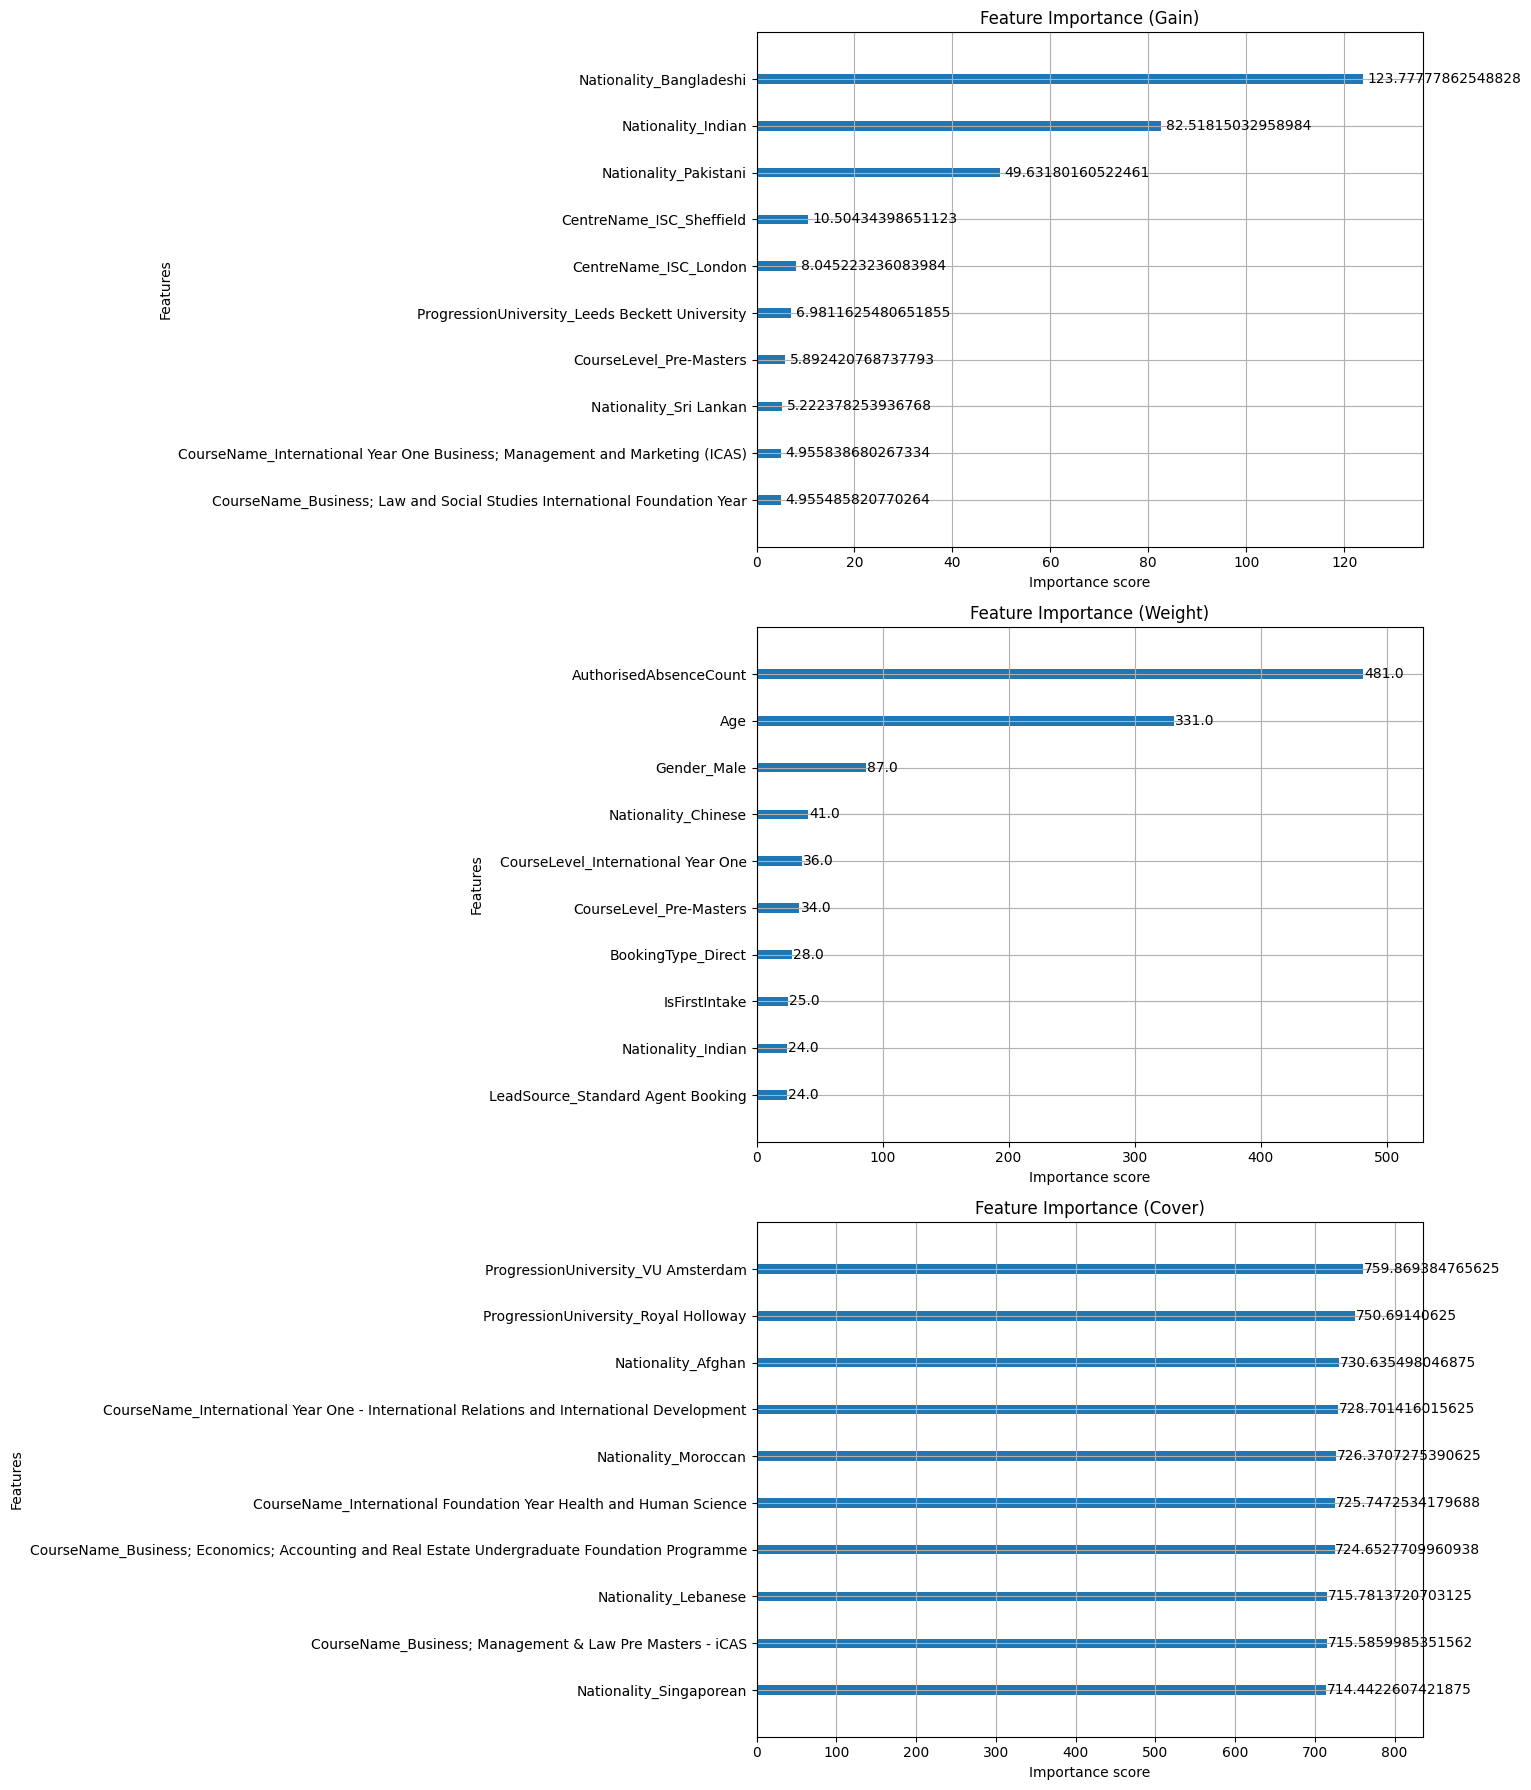

In [69]:
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Gain (average gain in accuracy) - top plot
# How much a feature improves the model’s accuracy when it’s used for splitting.
xgb.plot_importance(model_xgb, importance_type='gain', ax=axes[0], max_num_features=10, title='Feature Importance (Gain)')

# Weight (frequency) - middle plot
# Definition: How many times a feature is used to split nodes in all trees.
xgb.plot_importance(model_xgb, importance_type='weight', ax=axes[1], max_num_features=10, title='Feature Importance (Weight)')

# Cover (average coverage) - bottom plot
# How many data points are affected by splits on that feature.
xgb.plot_importance(model_xgb, importance_type='cover', ax=axes[2], max_num_features=10, title='Feature Importance (Cover)')

plt.tight_layout()
plt.show()

# Table of features importance values for tuned XGBoost - gain, weigh and cover

Having both tables, XGBoost default (above) and XGBoost tuned (below) helps to compare easily.

In [70]:
# Get importance dictionaries
gain_importance = model_xgb.get_booster().get_score(importance_type='gain')
weight_importance = model_xgb.get_booster().get_score(importance_type='weight')
cover_importance = model_xgb.get_booster().get_score(importance_type='cover')

# Helper function to create sorted DataFrame for a given importance type
def create_importance_df(importance_dict, top_n=10):
    df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Value'])
    df_sorted = df.sort_values(by='Value', ascending=False).head(top_n).reset_index(drop=True)
    return df_sorted

# Create tables
gain_df = create_importance_df(gain_importance)
weight_df = create_importance_df(weight_importance)
cover_df = create_importance_df(cover_importance)

# Display the tables
print("Top 10 Features by Gain:")
print(gain_df, "\n")

print("Top 10 Features by Weight:")
print(weight_df, "\n")

print("Top 10 Features by Cover:")
print(cover_df)

Top 10 Features by Gain:
                                             Feature       Value
0                            Nationality_Bangladeshi  123.777779
1                                 Nationality_Indian   82.518150
2                              Nationality_Pakistani   49.631802
3                           CentreName_ISC_Sheffield   10.504344
4                              CentreName_ISC_London    8.045223
5     ProgressionUniversity_Leeds Beckett University    6.981163
6                            CourseLevel_Pre-Masters    5.892421
7                             Nationality_Sri Lankan    5.222378
8  CourseName_International Year One Business; Ma...    4.955839
9  CourseName_Business; Law and Social Studies In...    4.955486 

Top 10 Features by Weight:
                              Feature  Value
0              AuthorisedAbsenceCount  481.0
1                                 Age  331.0
2                         Gender_Male   87.0
3                 Nationality_Chinese   41.0
4  Cou

# Comments on feature importance plots of XGBoost default and tuned

# XGBoost for Stage 2 - Model Performance Comparison with Percentage Change

In [71]:
# Metrics from both models (default and tuned)
metrics_data = {
    'Metric': [
        'Accuracy',
        'AUC Score',
        'Precision (Class 0)',
        'Precision (Class 1)',
        'Recall (Class 0)',
        'Recall (Class 1)',
        'F1-Score (Class 0)',
        'F1-Score (Class 1)',
        'True Negatives (TN)',
        'False Positives (FP)',
        'False Negatives (FN)',
        'True Positives (TP)'
    ],
    'Default Model': [
        0.8659,
        0.9012,
        0.54,
        0.96,
        0.78,
        0.88,
        0.64,
        0.92,
        587,
        164,
        508,
        3753
    ],
    'Tuned Model': [
        0.8651,
        0.8987,
        0.53,
        0.96,
        0.78,
        0.88,
        0.63,
        0.92,
        585,
        166,
        510,
        3751
    ]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Calculate percentage change from default to tuned
def pct_change(default, tuned):
    return np.where(default != 0, (tuned - default) / default * 100, np.nan)

metrics_df['Percentage Change (%)'] = pct_change(metrics_df['Default Model'], metrics_df['Tuned Model'])

# Format display: 4 decimals for models, + sign for percentage changes
styled_df = metrics_df.style.format({
    'Default Model': '{:.4f}',
    'Tuned Model': '{:.4f}',
    'Percentage Change (%)': '{:+.2f}%'
}).set_caption("Model Performance Comparison with Percentage Change").set_properties(**{'text-align': 'center'})

styled_df

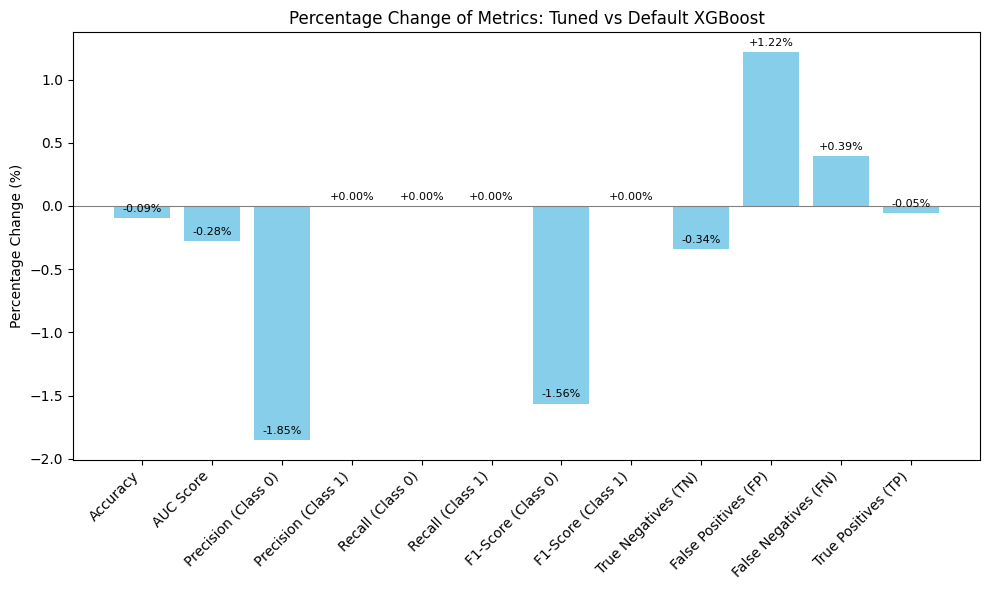

In [72]:
plt.figure(figsize=(10, 6))

# Bar plot for percentage changes using your metrics_df DataFrame
bars = plt.bar(metrics_df["Metric"], metrics_df["Percentage Change (%)"], color='skyblue')


plt.axhline(0, color='gray', linewidth=0.8)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Percentage Change (%)")
plt.title("Percentage Change of Metrics: Tuned vs Default XGBoost")

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:+.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# XGBoost for Stage 2 comparison - main observations

# Neural Network (Keras) for Stage 2




In [73]:
# Decided to scale the data for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute Class Weights

In [74]:

# Handles class imbalance
# Cares more about underrepresented class by giving it a higher penalty when misclassified
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Instantiation of the default neural network model

In [75]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'), # 64 neruons are moderate complexity/ relu makes training fast
    Dropout(0.3), # Prevents overfitting by randomly dropping 30% of neurons
    Dense(32, activation='relu'),
    Dropout(0.2), # Drops 20% to reduce overfitting
    Dense(1, activation='sigmoid')
])

# Compile the Deafult Neural Network model

In [76]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(), # handles the imbalanced classes well
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the Default Neural Network

In [77]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7302 - loss: 0.5863 - val_accuracy: 0.8514 - val_loss: 0.3968
Epoch 2/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8309 - loss: 0.4456 - val_accuracy: 0.8490 - val_loss: 0.4195
Epoch 3/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8372 - loss: 0.4257 - val_accuracy: 0.8480 - val_loss: 0.4079
Epoch 4/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8371 - loss: 0.4169 - val_accuracy: 0.8484 - val_loss: 0.4097
Epoch 5/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8508 - loss: 0.3900 - val_accuracy: 0.8504 - val_loss: 0.3907
Epoch 6/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8518 - loss: 0.3855 - val_accuracy: 0.8571 - val_loss: 0.3958
Epoch 7/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8515 - loss: 0.3861 - val_accuracy: 0.8587 - val_loss: 0.4007
Epoch 8/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8563 - loss: 0.3726 - val_accuracy: 0.

# Predict the Default Neural Network model

In [78]:
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# Accuracy, confusion matrix, precision, recall and AUC


Test Accuracy: 0.8669

Confusion Matrix:
[[ 572  179]
 [ 488 3773]]

Classification Report:
              precision    recall  f1-score   support

           0     0.5396    0.7617    0.6317       751
           1     0.9547    0.8855    0.9188      4261

    accuracy                         0.8669      5012
   macro avg     0.7472    0.8236    0.7752      5012
weighted avg     0.8925    0.8669    0.8758      5012

AUC: 0.8705


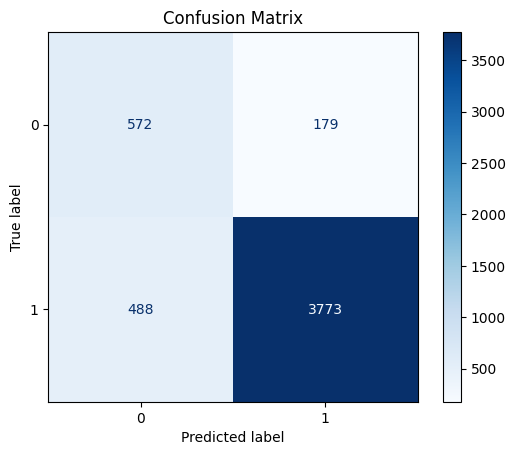

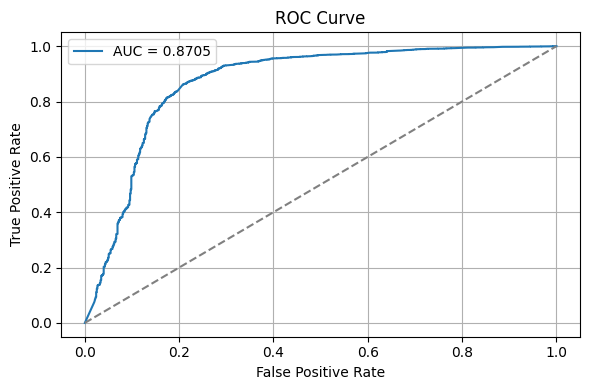

In [79]:
# Accuracy
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# AUC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC: {auc:.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss (and accuracy) curve for Default Neural Network

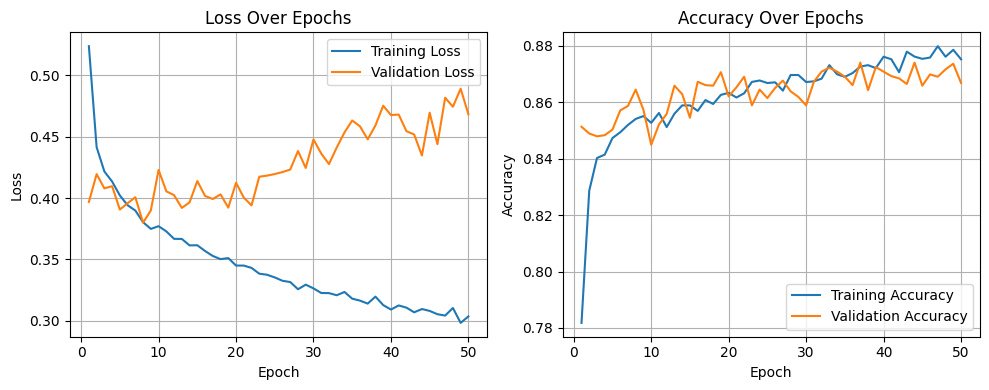

In [80]:
# Plot Loss and Accuracy Curves

# Extract values from the training history
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict.get('accuracy')  # Might be 'acc' in older Keras
val_acc = history_dict.get('val_accuracy')

epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Interpretation of loss (and accuracy) curves

* Training loss consistently decreases, while validation loss initially drops then increases, indicating overfitting.

* Training accuracy steadily increases, but validation accuracy plateaus and fluctuates, further confirming overfitting

* Both plots show a clear divergence between training and validation metrics, strongly suggesting the model is overfitting to the training data.

# Hyperparameter tuning for Neural Network Stage 2

# Hyperparameter tuning of number of neurons, optimisers and activations functions - finding the best hyperparameters

In [81]:
# Define model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    # Tune number of units in first Dense layer
    units = hp.Choice('units', values=[32, 64, 128], default=64)
    model.add(Dense(units, activation=hp.Choice('activation', ['relu', 'tanh'], default='tanh'))) # Tune activation function to find the best nonlinearity for the data
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1, default=0.3)))

    # Second Dense layer adds capacity if needed (flexibility to increase complexity)
    if hp.Boolean('second_layer', default=True):
        units2 = hp.Int('units_2', min_value=16, max_value=64, step=16, default=32)
        model.add(Dense(units2, activation=hp.Choice('activation_2', ['relu', 'tanh'], default='tanh')))
        model.add(Dropout(hp.Float('dropout_2', 0.1, 0.3, step=0.1, default=0.2))) # The dropout ranges (0.1 to 0.5) help address potential overfitting seen in the fluctuating validation loss.
        # Additional dropout for the second layer to control overfitting
        dropout_2 = hp.Float('dropout_2', 0.1, 0.3, step=0.1, default=0.2)
        model.add(Dropout(dropout_2))
    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate (1e-4 to 1e-2) to optimize training convergence and stability
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log', default=1e-3)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
    # With the use of compiled Keras Sequential models, the functionality can be configured
    # with different tunable layers, activations, dropout, and learning rates, which can then lead to training.

# Instantiate the tuner and perform tuning

In [82]:
# find the best hyperparameters by running multiple model configurations

# Clear old tuner results
import shutil
shutil.rmtree("hyperparam_tuning", ignore_errors=True)

# Instantiate tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='nn_imbalanced_data'
)


tuner.search(
    X_train_scaled, y_train,
    epochs=30, # Number of epochs to train each trial
    batch_size=32, # Number of samples per gradient update
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weight_dict, # Weights to handle class imbalance during training
    verbose=1
)

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.862130880355835

Best val_accuracy So Far: 0.8701117038726807
Total elapsed time: 00h 08m 45s


# Retrieve the best-trained model and make predictions (probabilities) on the test data

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best tuned model accuracy: 0.8701
Confusion Matrix:
[[ 569  182]
 [ 469 3792]]
Classification Report:
              precision    recall  f1-score   support

           0     0.5482    0.7577    0.6361       751
           1     0.9542    0.8899    0.9209      4261

    accuracy                         0.8701      5012
   macro avg     0.7512    0.8238    0.7785      5012
weighted avg     0.8934    0.8701    0.8783      5012

AUC Score: 0.8756


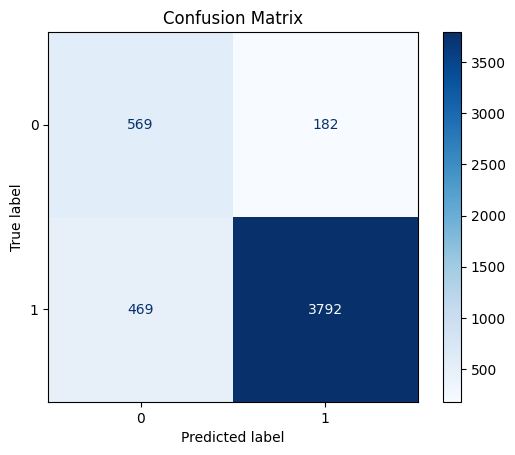

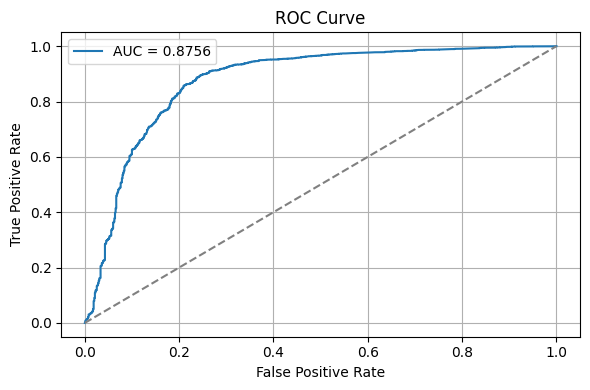

In [83]:
# Retrieve the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Predict probabilities on the test set
y_pred_probs = best_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_probs > 0.5).astype(int) # Convert probabilities to binary class predictions using 0.5 threshold

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)
auc_score = roc_auc_score(y_test, y_pred_probs)

# Print results
print(f"Best tuned model accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)
print(f"AUC Score: {auc_score:.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss (and accuracy) curve for Tuned Neural Network

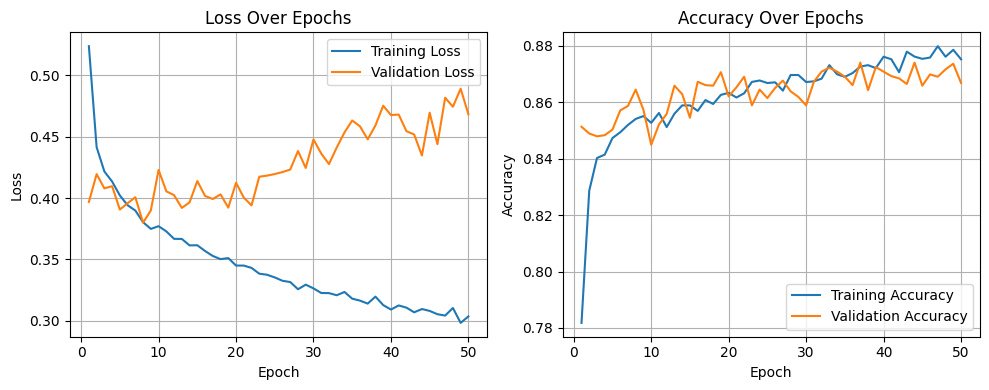

In [84]:
# Plot Loss and Accuracy Curves

# Extract values from the training history
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict.get('accuracy')  # Might be 'acc' in older Keras
val_acc = history_dict.get('val_accuracy')

epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Interpretation of loss (and accuracy) curves for Tuned Neural Network

* Training loss decreases while validation loss increases, and training accuracy improves while validation accuracy plateaus/fluctuates.

* The model is learning the training data too well but failing to generalize to new, unseen data.

# Compare Tuned vs Default Neural Network model

In [85]:
# Metrics from Neural Network default and tuned models (excluding macro/weighted F1-scores)
metrics = {
    "Metric": [
        "Accuracy",
        "AUC Score",
        "Precision (Class 0)",
        "Precision (Class 1)",
        "Recall (Class 0)",
        "Recall (Class 1)",
        "F1-Score (Class 0)",
        "F1-Score (Class 1)",
        "True Negatives (TN)",
        "False Positives (FP)",
        "False Negatives (FN)",
        "True Positives (TP)"
    ],
    "Default Model": [
        0.8559,
        0.8696,
        0.5127,
        0.9571,
        0.7790,
        0.8695,
        0.6184,
        0.9112,
        585,
        166,
        556,
        3705
    ],
    "Tuned Model": [
        0.8869,
        0.8787,
        0.6036,
        0.9479,
        0.7137,
        0.9174,
        0.6541,
        0.9324,
        536,
        215,
        352,
        3909
    ]
}

# Compute percentage changes
percent_change = []
for orig, tuned in zip(metrics["Default Model"], metrics["Tuned Model"]):  # updated here
    if orig == 0 or orig is None:
        percent_change.append(None)
    else:
        change = ((tuned - orig) / orig) * 100
        percent_change.append(change)

# Create DataFrame
df_nn = pd.DataFrame({
    "Metric": metrics["Metric"],
    "Default Model": metrics["Default Model"],  # updated here
    "Tuned Model": metrics["Tuned Model"],
    "% Change": percent_change
})

# Style the DataFrame
styled_df_nn = df_nn.style.format({
    "Default Model": "{:.4f}",  # updated here
    "Tuned Model": "{:.4f}",
    "% Change": lambda x: "" if pd.isnull(x) else f"{x:+.2f}%"
}).set_caption("Neural Network Performance Comparison").set_properties(**{'text-align': 'center'})

styled_df_nn

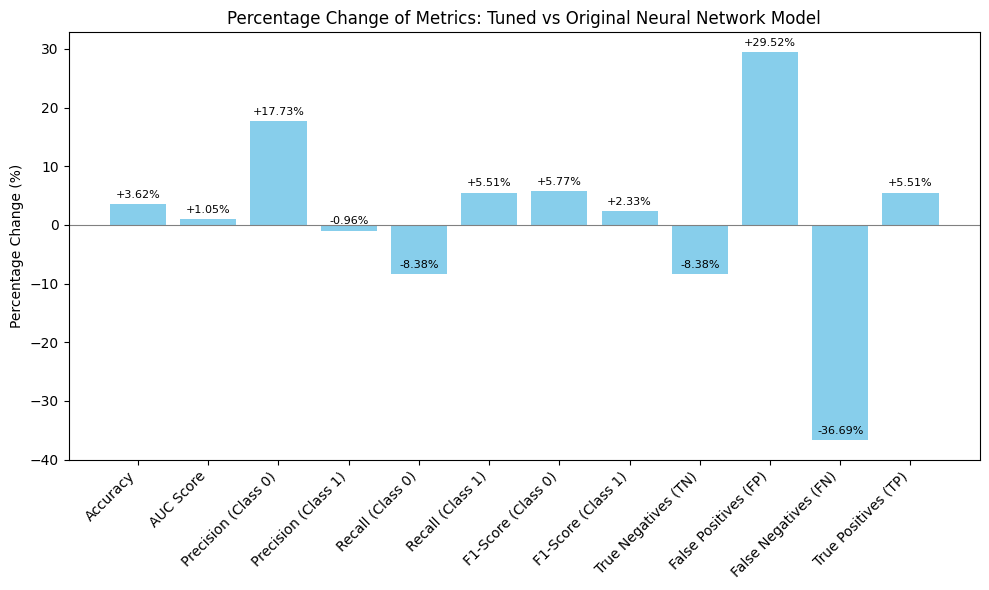

In [86]:
# Plotting
plt.figure(figsize=(10, 6))

bars = plt.bar(df_nn["Metric"], df_nn["% Change"], color='skyblue')

plt.axhline(0, color='gray', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage Change (%)")
plt.title("Percentage Change of Metrics: Tuned vs Original Neural Network Model")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:+.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Neural Networks for Stage 2 comparison - main observations

# Comparing performance of XGBoost and Neural Network models

Table 1: Default Models Comparison



Table 2: Tuned Models Comparison


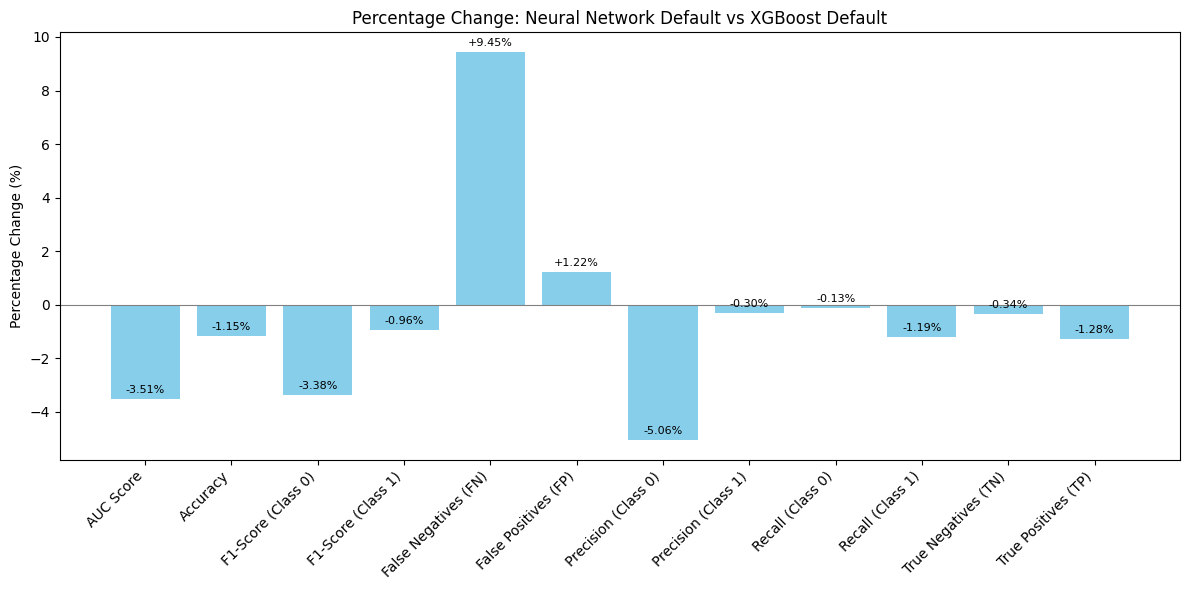

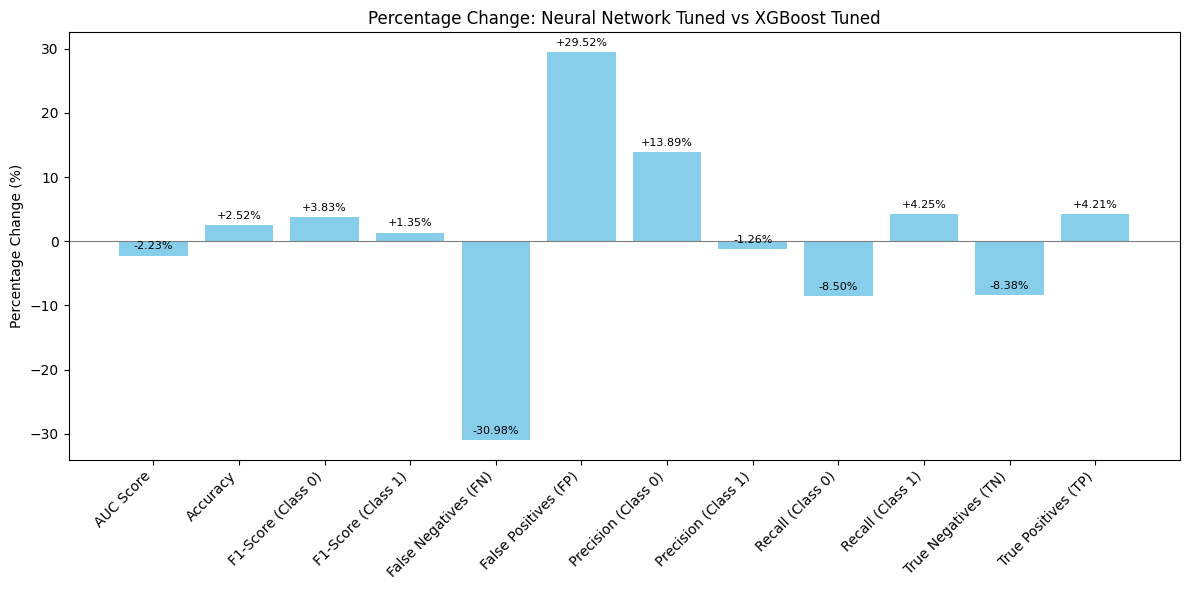

In [87]:
# Data for Neural Network including confusion matrix metrics
nn_metrics = {
    "Metric": [
        "Accuracy",
        "AUC Score",
        "Precision (Class 0)",
        "Recall (Class 0)",
        "F1-Score (Class 0)",
        "Precision (Class 1)",
        "Recall (Class 1)",
        "F1-Score (Class 1)",
        "True Negatives (TN)",
        "False Positives (FP)",
        "False Negatives (FN)",
        "True Positives (TP)"
    ],
    "Default Model": [
        0.8559,
        0.8696,
        0.5127,
        0.7790,
        0.6184,
        0.9571,
        0.8695,
        0.9112,
        585,
        166,
        556,
        3705
    ],
    "Tuned Model": [
        0.8869,
        0.8787,
        0.6036,
        0.7137,
        0.6541,
        0.9479,
        0.9174,
        0.9324,
        536,
        215,
        352,
        3909
    ]
}


# Data for XGBoost including confusion matrix metrics
xgb_metrics = {
    "Metric": [
        "Accuracy",
        "AUC Score",
        "Precision (Class 0)",
        "Recall (Class 0)",
        "F1-Score (Class 0)",
        "Precision (Class 1)",
        "Recall (Class 1)",
        "F1-Score (Class 1)",
        "True Negatives (TN)",
        "False Positives (FP)",
        "False Negatives (FN)",
        "True Positives (TP)"
    ],
    "Default Model": [
        0.8659,
        0.9012,
        0.5400,
        0.7800,
        0.6400,
        0.9600,
        0.8800,
        0.9200,
        587,
        164,
        508,
        3753
    ],
    "Tuned Model": [
        0.8651,
        0.8987,
        0.5300,
        0.7800,
        0.6300,
        0.9600,
        0.8800,
        0.9200,
        585,
        166,
        510,
        3751
    ]
}

# Convert to DataFrames
nn_df = pd.DataFrame(nn_metrics)
xgb_df = pd.DataFrame(xgb_metrics)

# Align metrics (in case order differs)
common_metrics = list(set(nn_df["Metric"]).intersection(xgb_df["Metric"]))
common_metrics.sort()

# Filter DataFrames to only common metrics in the same order
nn_df = nn_df[nn_df["Metric"].isin(common_metrics)].set_index("Metric").loc[common_metrics].reset_index()
xgb_df = xgb_df[xgb_df["Metric"].isin(common_metrics)].set_index("Metric").loc[common_metrics].reset_index()

# Function to compute percentage change: (NN - XGB) / XGB * 100
def percentage_change(nn_values, xgb_values):
    # To avoid division by zero, handle zero values
    changes = []
    for nn_val, xgb_val in zip(nn_values, xgb_values):
        if xgb_val == 0:
            changes.append(np.nan)
        else:
            changes.append(((nn_val - xgb_val) / xgb_val) * 100)
    return changes

# Table 1: Default Models Comparison
default_compare = pd.DataFrame({
    "Metric": common_metrics,
    "XGBoost Default": xgb_df["Default Model"].values,
    "Neural Net Default": nn_df["Default Model"].values
})
default_compare["% Change (NN vs XGB)"] = percentage_change(default_compare["Neural Net Default"], default_compare["XGBoost Default"])

# Table 2: Tuned Models Comparison
tuned_compare = pd.DataFrame({
    "Metric": common_metrics,
    "XGBoost Tuned": xgb_df["Tuned Model"].values,
    "Neural Net Tuned": nn_df["Tuned Model"].values
})
tuned_compare["% Change (NN vs XGB)"] = percentage_change(tuned_compare["Neural Net Tuned"], tuned_compare["XGBoost Tuned"])

# Format the percentage change column with +/– and 2 decimals for display
def format_percentage_change(df, col_name):
    return df.style.format({
        col_name: "{:+.2f}%"
    }).format(precision=4, subset=df.columns[1:-1]).set_properties(**{'text-align': 'center'})

# Display tables nicely formatted
print("Table 1: Default Models Comparison")
display(format_percentage_change(default_compare, "% Change (NN vs XGB)"))

print("\nTable 2: Tuned Models Comparison")
display(format_percentage_change(tuned_compare, "% Change (NN vs XGB)"))

# Plot function for bar chart of percentage changes
def plot_bar(df, title):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df["Metric"], df["% Change (NN vs XGB)"], color='skyblue')
    plt.axhline(0, color='gray', linewidth=0.8)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Percentage Change (%)")
    plt.title(title)
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            plt.annotate(f'{height:+.2f}%',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# Plot both bar charts
plot_bar(default_compare, "Percentage Change: Neural Network Default vs XGBoost Default")
plot_bar(tuned_compare, "Percentage Change: Neural Network Tuned vs XGBoost Tuned")


# Comparing performance metrics of Default and Tuned models (XGBoost and Neural Network)

# Comparison between Default models - XGBoost and Neural Network

# Comparison between Tuned models - XGBoost and Neural Network

# Stage 3 data

# Have additional information - AssessedModules, PassedModules and FailedModules

In [88]:
# File URL
file_url_3 = "https://drive.google.com/uc?id=18oyu-RQotQN6jaibsLBoPdqQJbj_cV2-"

# Loads the CSV file from Google Drive into a pandas DataFrame
stage3_data = pd.read_csv(f"https://drive.google.com/uc?export=download&id={file_url_3.split('=')[-1]}")

# View the first few rows
stage3_data.head()

CentreName  LearnerCode BookingType              LeadSource DiscountType  \
0  ISC_Aberdeen      2284932       Agent  Standard Agent Booking          NaN   
1  ISC_Aberdeen      2399500       Agent  Standard Agent Booking          NaN   
2  ISC_Aberdeen      2424946       Agent  Standard Agent Booking          NaN   
3  ISC_Aberdeen      2426583       Agent  Standard Agent Booking          NaN   
4  ISC_Aberdeen      2434674       Agent  Standard Agent Booking          NaN   

  DateofBirth Gender Nationality                          HomeState  \
0  13/01/1998   Male     Chinese  Jianye District; Jiangsu Province   
1   12/2/1998   Male     Chinese                                NaN   
2    7/4/2000   Male     Chinese                                NaN   
3  18/05/1999   Male     Chinese                                NaN   
4  19/04/1996   Male     Chinese                                NaN   

                 HomeCity  ...  \
0                 Nanjing  ...   
1                   Xi'an  ...   
2                 Chengdu  ...   
3  LIUYANG CITY ;CHANGSHA  ...   
4                  Xiamen  ...   

                                          CourseName IsFirstIntake  \
0                       Business and Law Pre-Masters          True   
1   Life Sciences Undergraduate Foundation Programme         False   
2  Business Management and Finance International ...         False   
3  Business Management and Finance International ...          True   
4                       Business and Law Pre-Masters          True   

   CompletedCourse AssessedModules  PassedModules  FailedModules  \
0              Yes             4.0            4.0            0.0   
1              Yes             7.0            7.0            0.0   
2              Yes             8.0            8.0            0.0   
3              Yes             8.0            8.0            0.0   
4              Yes             4.0            4.0            0.0   

                               ProgressionDegree   ProgressionUniversity  \
0  Msc Econ Accounting and Investment Management  University of Aberdeen   
1                        BSc Biological Sciences  University of Aberdeen   
2                                     MA Finance  University of Aberdeen   
3                         MA Business Management  University of Aberdeen   
4          MSc International Business Management  University of Aberdeen   

  AuthorisedAbsenceCount  UnauthorisedAbsenceCount  
0                    NaN                       NaN  
1                   93.0                       5.0  
2                   92.0                       6.0  
3                   67.0                      15.0  
4                    NaN                       NaN  

[5 rows x 21 columns]

# Learn about the data

In [89]:
# Check data types and missing values
stage3_data.info()

# Quick summary of data
stage3_data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Assess

CentreName   LearnerCode BookingType              LeadSource  \
count           25059  2.505900e+04       25059                   25059   
unique             19           NaN           2                       7   
top     ISC_Sheffield           NaN       Agent  Standard Agent Booking   
freq             5877           NaN       21878                   20284   
mean              NaN  2.606594e+06         NaN                     NaN   
std               NaN  8.798838e+04         NaN                     NaN   
min               NaN  2.139267e+06         NaN                     NaN   
25%               NaN  2.538411e+06         NaN                     NaN   
50%               NaN  2.607941e+06         NaN                     NaN   
75%               NaN  2.665460e+06         NaN                     NaN   
max               NaN  2.831468e+06         NaN                     NaN   

       DiscountType DateofBirth Gender Nationality HomeState HomeCity  ...  \
count          7595       25059  25059       25059      8925    21611  ...   
unique           11        4705      2         151      2448     5881  ...   
top         Bursary    1/1/2002   Male     Chinese    Punjab   Sylhet  ...   
freq           3561          37  15655        9042       865      675  ...   
mean            NaN         NaN    NaN         NaN       NaN      NaN  ...   
std             NaN         NaN    NaN         NaN       NaN      NaN  ...   
min             NaN         NaN    NaN         NaN       NaN      NaN  ...   
25%             NaN         NaN    NaN         NaN       NaN      NaN  ...   
50%             NaN         NaN    NaN         NaN       NaN      NaN  ...   
75%             NaN         NaN    NaN         NaN       NaN      NaN  ...   
max             NaN         NaN    NaN         NaN       NaN      NaN  ...   

                                               CourseName IsFirstIntake  \
count                                               25059         25059   
unique                                                172             2   
top     Pre-Masters Business; Social Sciences and Huma...         False   
freq                                                 1682         22035   
mean                                                  NaN           NaN   
std                                                   NaN           NaN   
min                                                   NaN           NaN   
25%                                                   NaN           NaN   
50%                                                   NaN           NaN   
75%                                                   NaN           NaN   
max                                                   NaN           NaN   

       CompletedCourse AssessedModules  PassedModules  FailedModules  \
count            25059    22828.000000   22828.000000   22828.000000   
unique               2             NaN            NaN            NaN   
top                Yes             NaN            NaN            NaN   
freq             21305             NaN            NaN            NaN   
mean               NaN        6.090328       5.582881       0.507447   
std                NaN        1.811116       2.361530       1.304677   
min                NaN        1.000000       0.000000       0.000000   
25%                NaN        4.000000       4.000000       0.000000   
50%                NaN        6.000000       6.000000       0.000000   
75%                NaN        7.000000       7.000000       0.000000   
max                NaN       12.000000      11.000000      10.000000   

                  ProgressionDegree  \
count                         24184   
unique                         2616   
top     BSc (Hons) Computer Science   
freq                            998   
mean                            NaN   
std                             NaN   
min                             NaN   
25%                             NaN   
50%                             NaN   
75%              

# Pre-processing

**Stage 3: Pre-processing instructions**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Choose how to engage with rows that have missing values, which can be done in one of two ways for this project:
  *   Impute the rows with appropriate values.
  *   Remove rows with missing values but ONLY in cases where rows with missing values are minimal: <2% of the overall data.






# Drop Unhelpful Columns

In [90]:
# Drop 'LearnerCode' – it's just an ID, not predictive
stage3_data.drop(columns=['LearnerCode'], inplace=True)

# Convert date of birth to Age

In [91]:
# Convert 'DateofBirth' to datetime
stage3_data['DateofBirth'] = pd.to_datetime(stage3_data['DateofBirth'], errors='coerce', dayfirst=True)

# Compute age assuming data collected in 2016
stage3_data['Age'] = 2016 - stage3_data['DateofBirth'].dt.year

# Why 2016?
# A student born in 1998 is listed under Foundation, which is typically for students around 18 years old.
# That suggests this record was collected around 2016 (1998 + 18).

# Drop the original DateofBirth column
stage3_data.drop(columns=['DateofBirth'], inplace=True)

In [92]:
# List all columns in the DataFrame
for col in stage3_data.columns:
    print(col)

CentreName
BookingType
LeadSource
DiscountType
Gender
Nationality
HomeState
HomeCity
CourseLevel
CourseName
IsFirstIntake
CompletedCourse
AssessedModules
PassedModules
FailedModules
ProgressionDegree
ProgressionUniversity
AuthorisedAbsenceCount
UnauthorisedAbsenceCount
Age


# Drop High Cardinality Columns

In [93]:
# Identify columns with >200 unique values
high_cardinality_cols = [col for col in stage3_data.columns if stage3_data[col].nunique() > 200]

# Drop those columns
stage3_data.drop(columns=high_cardinality_cols, inplace=True)

In [94]:
# List all columns in the DataFrame
for col in stage3_data.columns:
    print(col)

CentreName
BookingType
LeadSource
DiscountType
Gender
Nationality
CourseLevel
CourseName
IsFirstIntake
CompletedCourse
AssessedModules
PassedModules
FailedModules
ProgressionUniversity
AuthorisedAbsenceCount
Age


# Drop columns with >50% missing data

In [95]:
# Save original column names
original_columns = set(stage3_data.columns)

# Drop columns where more than 50% of the data is missing
threshold = len(stage3_data) * 0.5
stage3_data.dropna(thresh=threshold, axis=1, inplace=True)

# Save new column names
remaining_columns = set(stage3_data.columns)

# Find which columns were dropped
dropped_columns = original_columns - remaining_columns
print("Dropped columns due to >50% missing values:", dropped_columns)

Dropped columns due to >50% missing values: {'DiscountType'}


# Engage with missing values

# Dropping rows only if <2% of total data is affected

In [96]:
#from sklearn.impute import SimpleImputer

missing_percent = stage3_data.isnull().mean() * 100
initial_row_count = len(stage3_data)

# Dictionary to store dropped info
dropped_info = {}

# Drop rows if missing value is <2% in that column
for col in stage3_data.columns:
    if 0 < missing_percent[col] < 2:
        missing_rows = stage3_data[col].isnull().sum()
        dropped_info[col] = {
            'rows_dropped': missing_rows,
            'percent_of_total_rows': (missing_rows / initial_row_count) * 100
        }
        stage3_data = stage3_data[~stage3_data[col].isnull()]

# Print the info
if dropped_info:
    print("Columns with dropped rows (missing < 2%):")
    for col, info in dropped_info.items():
        print(f"- {col}: {info['rows_dropped']} rows dropped "
              f"({info['percent_of_total_rows']:.2f}% of total)")
else:
    print("No columns had missing values <2%, so no rows were dropped.")

Columns with dropped rows (missing < 2%):
- AuthorisedAbsenceCount: 208 rows dropped (0.83% of total)


# Mean imputation of remaining missing values for numeric variables

In [97]:
numeric_cols = stage3_data.select_dtypes(include=np.number).columns
if len(numeric_cols) > 0:
    imputer = SimpleImputer(strategy='mean')
    stage3_data[numeric_cols] = imputer.fit_transform(stage3_data[numeric_cols])
    print(f"Imputed missing values in numeric columns: {list(numeric_cols)}")
else:
    print("No numeric columns found for imputation, skipping this step.")

Imputed missing values in numeric columns: ['AssessedModules', 'PassedModules', 'FailedModules', 'AuthorisedAbsenceCount', 'Age']


# Encode Target Variable

In [98]:
# Encode the target first, before it gets one-hot encoded
stage3_data['CompletedCourse'] = stage3_data['CompletedCourse'].map({'Yes': 1, 'No': 0})

# Encode Categorical Variables

In [99]:
# One-hot encode the other categorical features (excluding the target)
categorical_cols = stage3_data.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop('CompletedCourse', errors='ignore')

stage3_data = pd.get_dummies(stage3_data, columns=categorical_cols, drop_first=True)

# Check for imbalanced data set

In [100]:
# Count how many samples in each class
print(stage3_data['CompletedCourse'].value_counts())

# Same in %
print(stage3_data['CompletedCourse'].value_counts(normalize=True) * 100)

CompletedCourse
1    21242
0     3609
Name: count, dtype: int64
CompletedCourse
1    85.477446
0    14.522554
Name: proportion, dtype: float64


# Target variable histogram

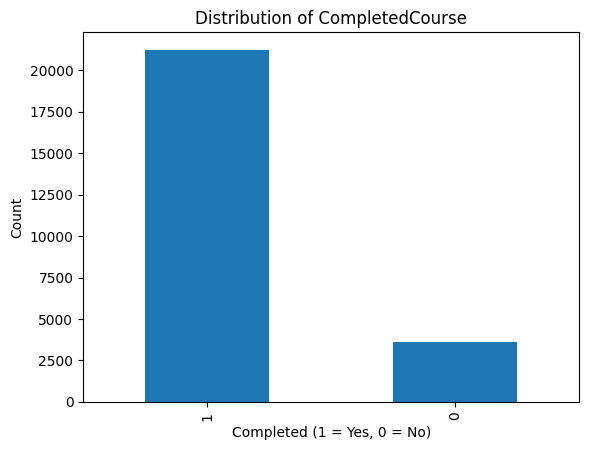

In [101]:
# Plot histogram to check distribution
stage3_data['CompletedCourse'].value_counts().plot(kind='bar')
plt.title("Distribution of CompletedCourse")
plt.xlabel("Completed (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

# Split data into training and test data

In [102]:
# Split data into X (features) and y (target)
X = stage3_data.drop(columns=['CompletedCourse'])
y = stage3_data['CompletedCourse']

# 80-20 Split

In [103]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost for Stage 3 data

# Remove bias towards the majority class

In [104]:
# Have binary labels 0 and 1 -> can use scale_pos_weight as:
num_neg = sum(y_train == 0)
num_pos = sum(y_train == 1)
scale_pos_weight = num_neg / num_pos

# XGBoost default model for Stage 3

# Instantiates XGBClassifier class from the xgboost library

In [105]:
model_xgb = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

# Plot of features importance for default XGBoost - gain, weigh and cover

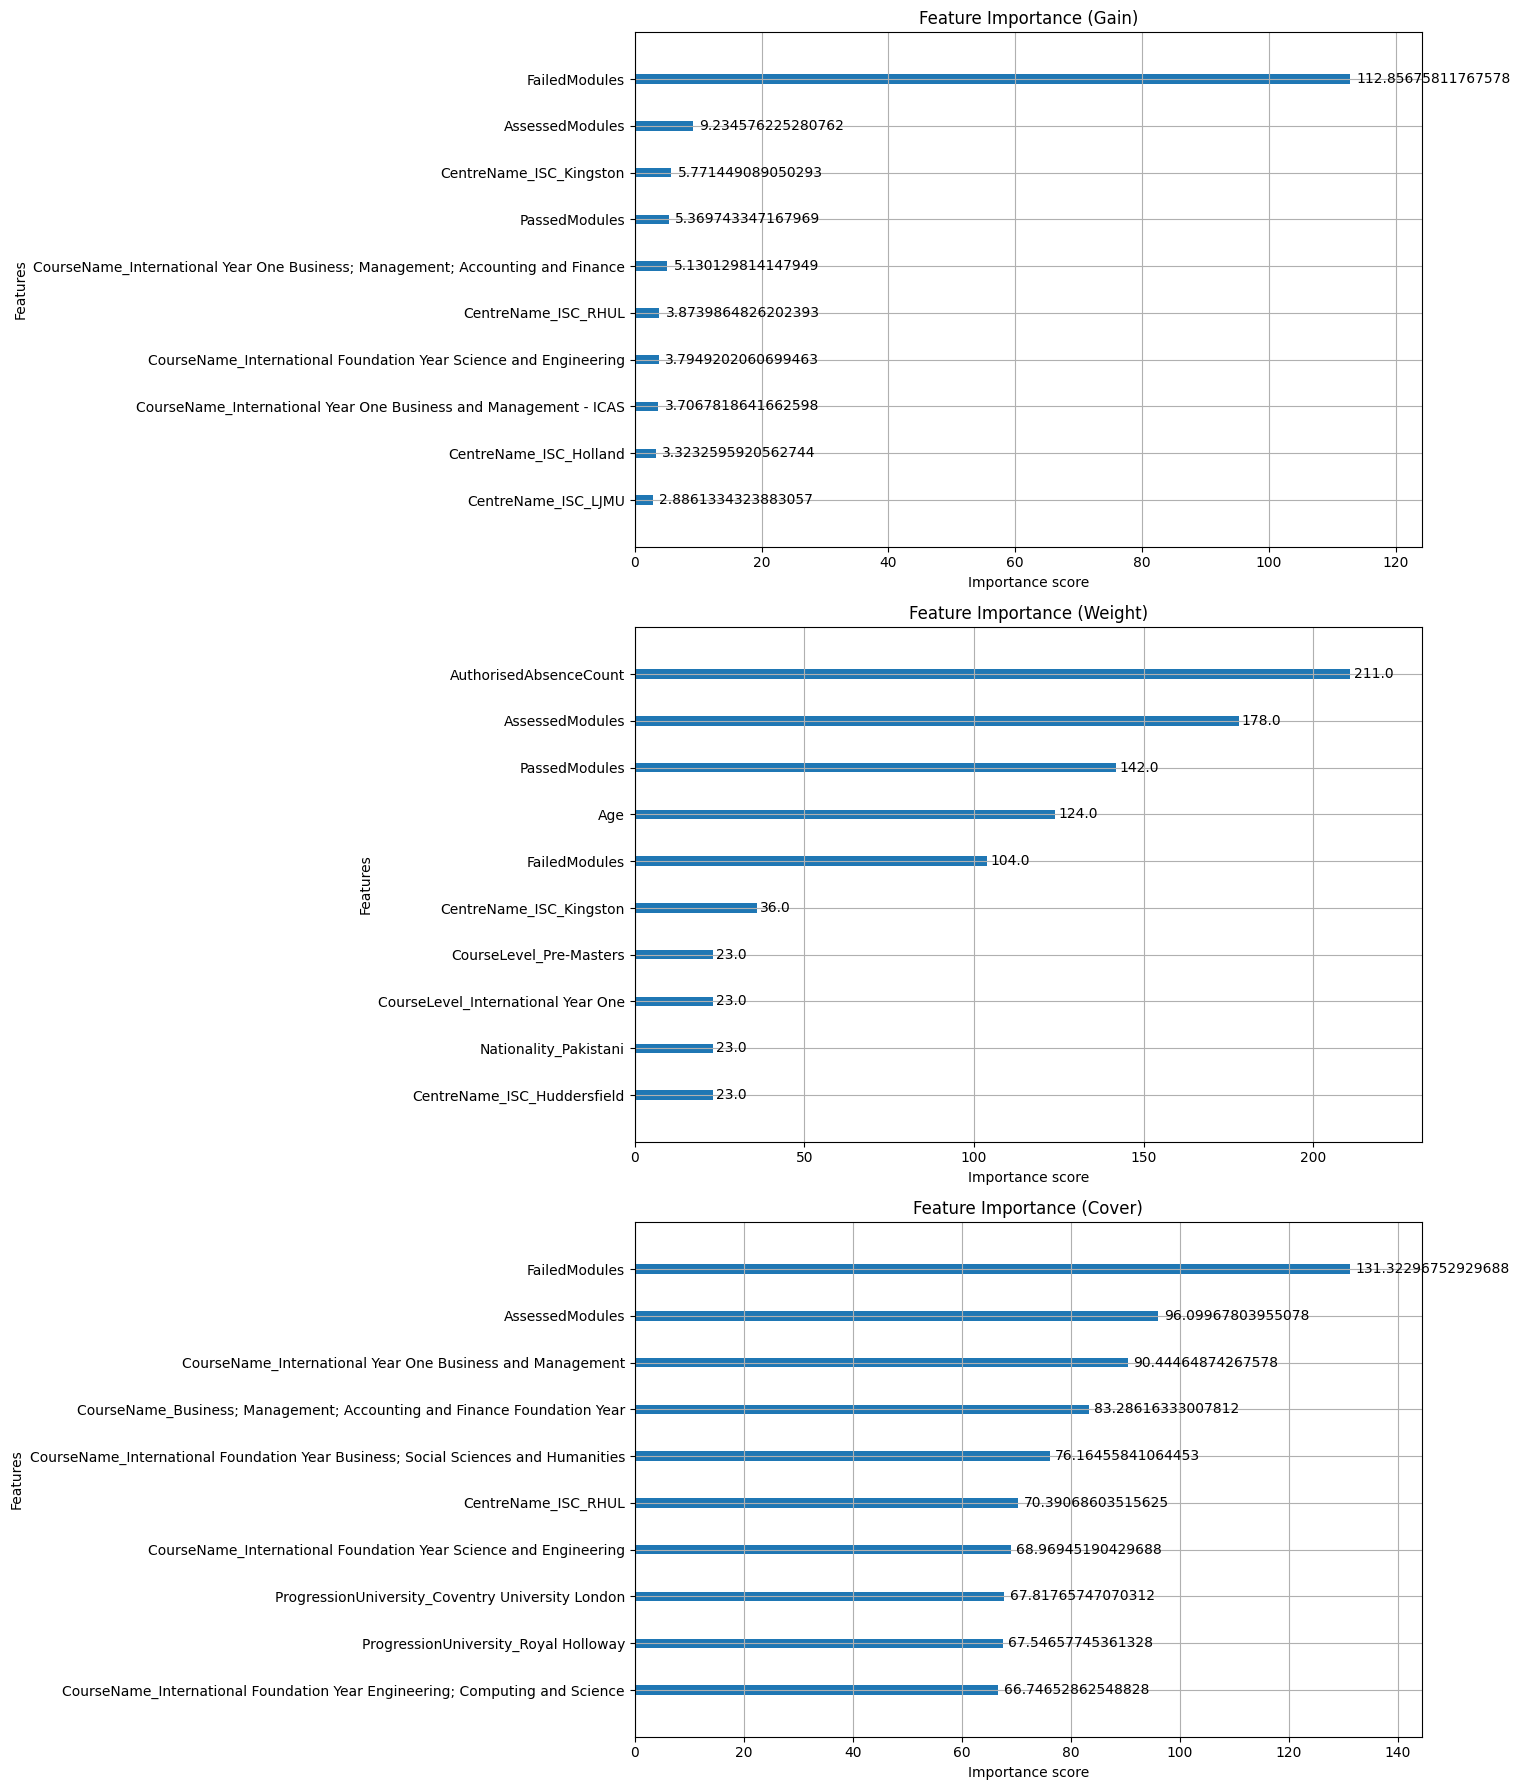

In [106]:
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Gain (average gain in accuracy) - top plot
# How much a feature improves the model’s accuracy when it’s used for splitting.
xgb.plot_importance(model_xgb, importance_type='gain', ax=axes[0], max_num_features=10, title='Feature Importance (Gain)')

# Weight (frequency) - middle plot
# Definition: How many times a feature is used to split nodes in all trees.
xgb.plot_importance(model_xgb, importance_type='weight', ax=axes[1], max_num_features=10, title='Feature Importance (Weight)')

# Cover (average coverage) - bottom plot
# How many data points are affected by splits on that feature.
xgb.plot_importance(model_xgb, importance_type='cover', ax=axes[2], max_num_features=10, title='Feature Importance (Cover)')

plt.tight_layout()
plt.show()

# Table of features importance values for default XGBoost - gain, weigh and cover

This is for an easier comparison with other feature importance plots

In [107]:
# Get importance dictionaries
gain_importance = model_xgb.get_booster().get_score(importance_type='gain')
weight_importance = model_xgb.get_booster().get_score(importance_type='weight')
cover_importance = model_xgb.get_booster().get_score(importance_type='cover')

# Helper function to create sorted DataFrame for a given importance type
def create_importance_df(importance_dict, top_n=10):
    df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Value'])
    df_sorted = df.sort_values(by='Value', ascending=False).head(top_n).reset_index(drop=True)
    return df_sorted

# Create tables
gain_df = create_importance_df(gain_importance)
weight_df = create_importance_df(weight_importance)
cover_df = create_importance_df(cover_importance)

# Display the tables
print("Top 10 Features by Gain:")
print(gain_df, "\n")

print("Top 10 Features by Weight:")
print(weight_df, "\n")

print("Top 10 Features by Cover:")
print(cover_df)

Top 10 Features by Gain:
                                             Feature       Value
0                                      FailedModules  112.856758
1                                    AssessedModules    9.234576
2                            CentreName_ISC_Kingston    5.771449
3                                      PassedModules    5.369743
4  CourseName_International Year One Business; Ma...    5.130130
5                                CentreName_ISC_RHUL    3.873986
6  CourseName_International Foundation Year Scien...    3.794920
7  CourseName_International Year One Business and...    3.706782
8                             CentreName_ISC_Holland    3.323260
9                                CentreName_ISC_LJMU    2.886133 

Top 10 Features by Weight:
                       Feature  Value
0       AuthorisedAbsenceCount  211.0
1              AssessedModules  178.0
2                PassedModules  142.0
3                          Age  124.0
4                FailedModules  104.0
5  

# Comments on feature importance plots

# XGBoost (default) for Stage 3 performance indicators - Accuracy, confusion matrix, precision, recall and AUC

Confusion Matrix:
 [[ 705   17]
 [  48 4201]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       722
           1       1.00      0.99      0.99      4249

    accuracy                           0.99      4971
   macro avg       0.97      0.98      0.97      4971
weighted avg       0.99      0.99      0.99      4971

Accuracy: 0.9869
AUC Score: 0.9992


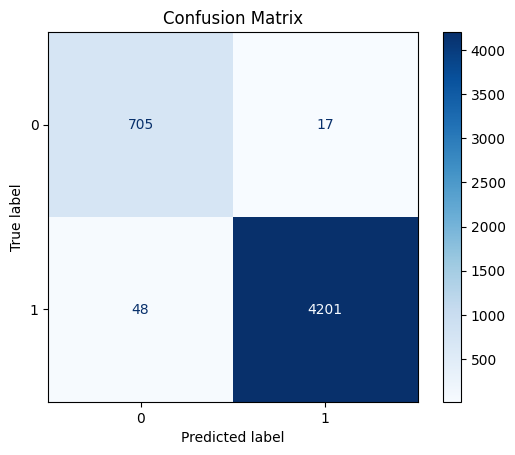

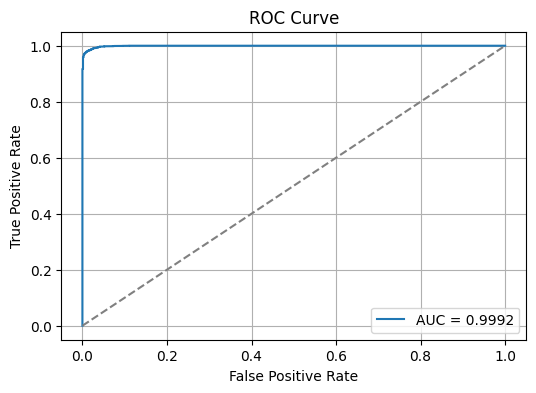

In [108]:
# Predictions
y_pred_xgb = model_xgb.predict(X_test)
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Metrics
cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
auc = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# XGBoost model with hyperparameter tuning - learning rate, max depth and number of estimators

# XGBoost hyperparameter tuning with OPTUNA

In [109]:
# Split data into training and validation sets (80% train, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

[I 2025-11-14 21:06:39,205] A new study created in memory with name: no-name-61571ee4-4a49-4fd1-8052-fabc072186dc
[I 2025-11-14 21:06:51,383] Trial 0 finished with value: 0.9584372294652669 and parameters: {'learning_rate': 0.27323818713975484, 'max_depth': 9, 'n_estimators': 458}. Best is trial 0 with value: 0.9584372294652669.
[I 2025-11-14 21:07:04,599] Trial 1 finished with value: 0.9619004338630507 and parameters: {'learning_rate': 0.14334366256665831, 'max_depth': 9, 'n_estimators': 498}. Best is trial 1 with value: 0.9619004338630507.
[I 2025-11-14 21:07:08,823] Trial 2 finished with value: 0.9691740626320066 and parameters: {'learning_rate': 0.20413811015266464, 'max_depth': 6, 'n_estimators': 193}. Best is trial 2 with value: 0.9691740626320066.
[I 2025-11-14 21:07:14,632] Trial 3 finished with value: 0.9747144700415729 and parameters: {'learning_rate': 0.2320228108171667, 'max_depth': 5, 'n_estimators': 156}. Best is trial 3 with value: 0.9747144700415729.
[I 2025-11-14 21:07

Best Hyperparameters from Optuna tuning:
{'learning_rate': 0.04373030809817312, 'max_depth': 4, 'n_estimators': 314}
Best Mean Recall for Class 0 (Dropouts): 0.9809
Confusion Matrix:
 [[ 713    9]
 [  66 4183]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       722
           1       1.00      0.98      0.99      4249

    accuracy                           0.98      4971
   macro avg       0.96      0.99      0.97      4971
weighted avg       0.99      0.98      0.99      4971

Accuracy: 0.9849
AUC Score: 0.9990


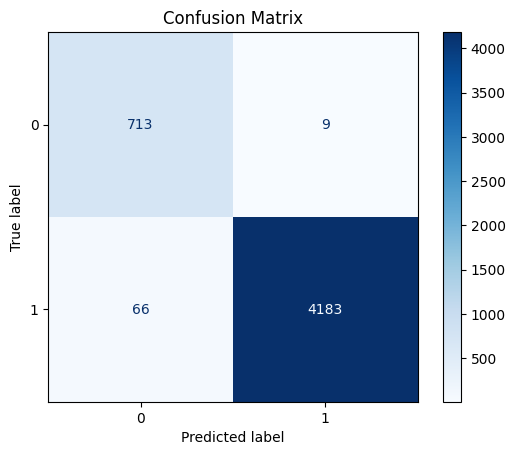

In [110]:
# Define Optuna objective function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss',
        'random_state': 42,
        'use_label_encoder': False,
        'verbosity': 0
    }

    model = XGBClassifier(**params)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    recall_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict(X_val)
        recall_0 = recall_score(y_val, preds, pos_label=0)
        recall_scores.append(recall_0)

    return np.mean(recall_scores)

# Run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best Hyperparameters from Optuna tuning:")
print(study.best_trial.params)
print(f"Best Mean Recall for Class 0 (Dropouts): {study.best_value:.4f}")

# Use best params from study
best_params = study.best_trial.params
best_params.update({
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss',
    'random_state': 42,
    'use_label_encoder': False,
    'verbosity': 0
})

model_xgb_optimised = XGBClassifier(**best_params)

# Train on full training data
model_xgb_optimised.fit(X_train, y_train)

# Predict and evaluate on test data
y_pred_xgb = model_xgb_optimised.predict(X_test)
y_pred_proba_xgb = model_xgb_optimised.predict_proba(X_test)[:, 1]

# Metrics and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

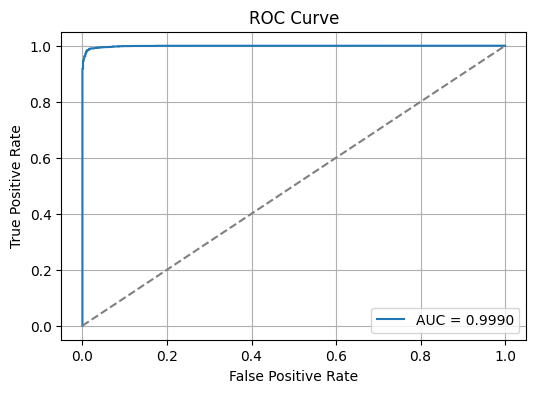

In [111]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
auc = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot of features importance for tuned XGBoost - gain, weigh and cover

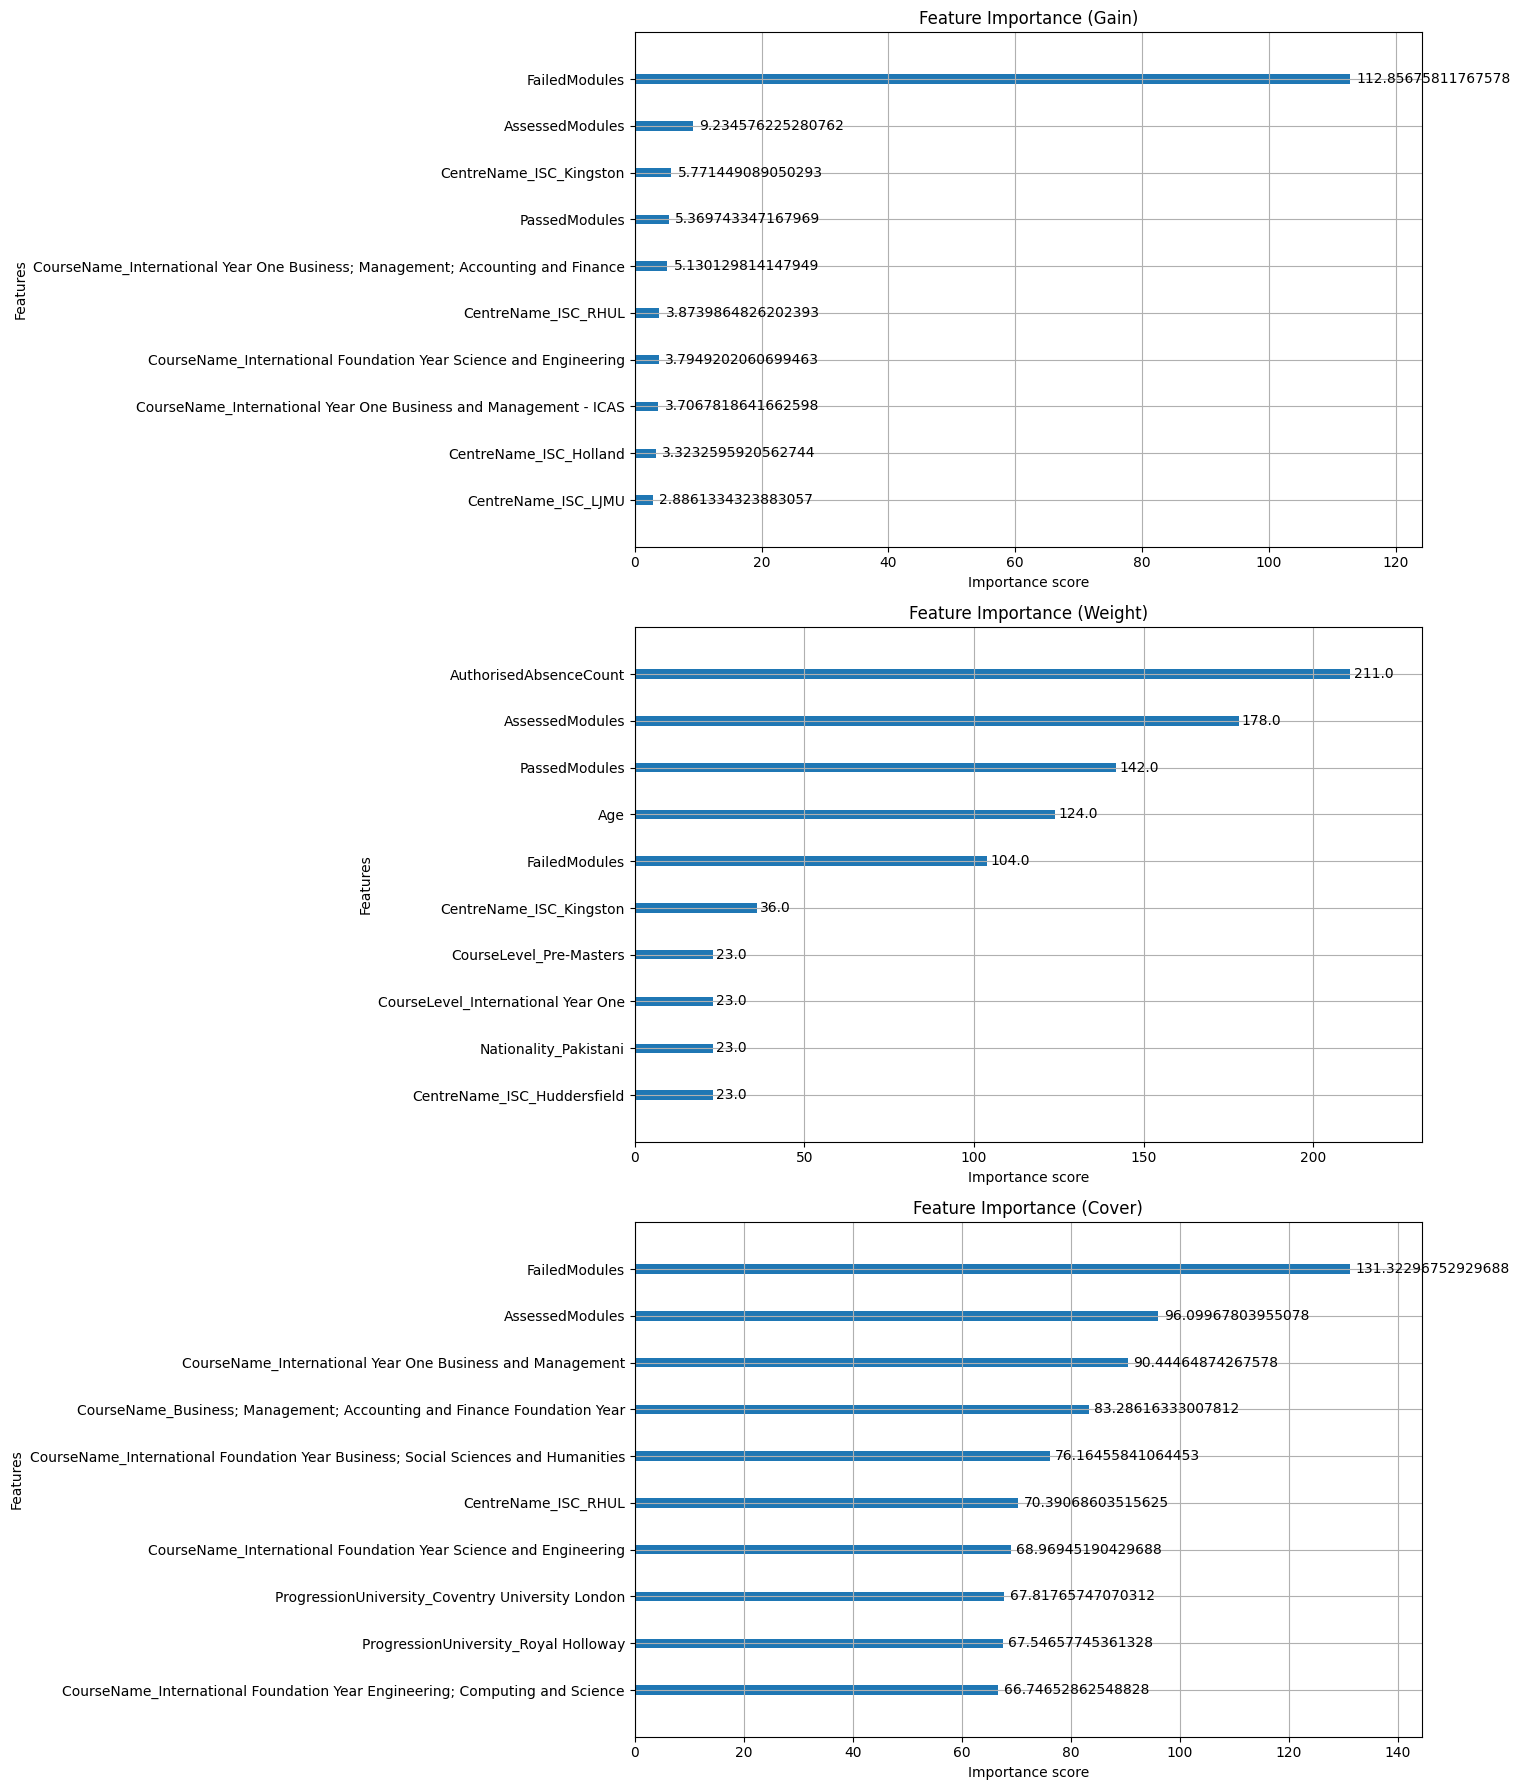

In [112]:
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Gain (average gain in accuracy) - top plot
# How much a feature improves the model’s accuracy when it’s used for splitting.
xgb.plot_importance(model_xgb, importance_type='gain', ax=axes[0], max_num_features=10, title='Feature Importance (Gain)')

# Weight (frequency) - middle plot
# Definition: How many times a feature is used to split nodes in all trees.
xgb.plot_importance(model_xgb, importance_type='weight', ax=axes[1], max_num_features=10, title='Feature Importance (Weight)')

# Cover (average coverage) - bottom plot
# How many data points are affected by splits on that feature.
xgb.plot_importance(model_xgb, importance_type='cover', ax=axes[2], max_num_features=10, title='Feature Importance (Cover)')

plt.tight_layout()
plt.show()

# Table of features importance values for tuned XGBoost - gain, weigh and cover

Having both tables, XGBoost default (above) and XGBoost tuned (below) helps to compare easily.

In [113]:
# Get importance dictionaries
gain_importance = model_xgb.get_booster().get_score(importance_type='gain')
weight_importance = model_xgb.get_booster().get_score(importance_type='weight')
cover_importance = model_xgb.get_booster().get_score(importance_type='cover')

# Helper function to create sorted DataFrame for a given importance type
def create_importance_df(importance_dict, top_n=10):
    df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Value'])
    df_sorted = df.sort_values(by='Value', ascending=False).head(top_n).reset_index(drop=True)
    return df_sorted

# Create tables
gain_df = create_importance_df(gain_importance)
weight_df = create_importance_df(weight_importance)
cover_df = create_importance_df(cover_importance)

# Display the tables
print("Top 10 Features by Gain:")
print(gain_df, "\n")

print("Top 10 Features by Weight:")
print(weight_df, "\n")

print("Top 10 Features by Cover:")
print(cover_df)

Top 10 Features by Gain:
                                             Feature       Value
0                                      FailedModules  112.856758
1                                    AssessedModules    9.234576
2                            CentreName_ISC_Kingston    5.771449
3                                      PassedModules    5.369743
4  CourseName_International Year One Business; Ma...    5.130130
5                                CentreName_ISC_RHUL    3.873986
6  CourseName_International Foundation Year Scien...    3.794920
7  CourseName_International Year One Business and...    3.706782
8                             CentreName_ISC_Holland    3.323260
9                                CentreName_ISC_LJMU    2.886133 

Top 10 Features by Weight:
                       Feature  Value
0       AuthorisedAbsenceCount  211.0
1              AssessedModules  178.0
2                PassedModules  142.0
3                          Age  124.0
4                FailedModules  104.0
5  

# Comments on feature importance plots of XGBoost default and tuned

# XGBoost for Stage 2 - Model Performance Comparison with Percentage Change

In [114]:
# Metrics from both models (default and tuned)
metrics_data = {
    'Metric': [
        'Accuracy',
        'AUC Score',
        'Precision (Class 0)',
        'Precision (Class 1)',
        'Recall (Class 0)',
        'Recall (Class 1)',
        'F1-Score (Class 0)',
        'F1-Score (Class 1)',
        'True Negatives (TN)',
        'False Positives (FP)',
        'False Negatives (FN)',
        'True Positives (TP)'
    ],
    'Default Model': [
        0.9869,
        0.9992,
        0.94,
        1.00,
        0.98,
        0.99,
        0.96,
        0.99,
        705,
        17,
        48,
        4201
    ],
    'Tuned Model': [
        0.9835,
        0.9989,
        0.91,
        1.00,
        0.99,
        0.98,
        0.95,
        0.99,
        712,
        10,
        72,
        4177
    ]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Calculate percentage change from default to tuned
def pct_change(default, tuned):
    return np.where(default != 0, (tuned - default) / default * 100, np.nan)

metrics_df['Percentage Change (%)'] = pct_change(metrics_df['Default Model'], metrics_df['Tuned Model'])

# Format display: 4 decimals for models, + sign for percentage changes
styled_df = metrics_df.style.format({
    'Default Model': '{:.4f}',
    'Tuned Model': '{:.4f}',
    'Percentage Change (%)': '{:+.2f}%'
}).set_caption("Model Performance Comparison with Percentage Change").set_properties(**{'text-align': 'center'})

styled_df

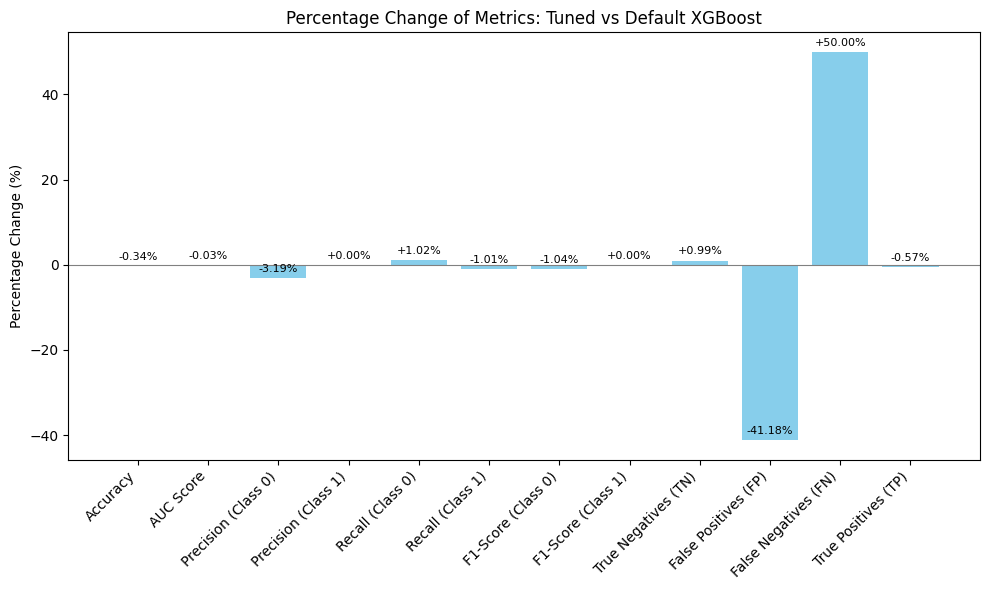

In [115]:
plt.figure(figsize=(10, 6))

# Bar plot for percentage changes using your metrics_df DataFrame
bars = plt.bar(metrics_df["Metric"], metrics_df["Percentage Change (%)"], color='skyblue')


plt.axhline(0, color='gray', linewidth=0.8)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Percentage Change (%)")
plt.title("Percentage Change of Metrics: Tuned vs Default XGBoost")

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:+.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# XGBoost for Stage 3 comparison - main observations

# Neural Network (Keras) for Stage 3




In [116]:
# Decided to scale the data for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute Class Weights

In [117]:
# Handles class imbalance
# Cares more about underrepresented class by giving it a higher penalty when misclassified
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Instantiation of the default neural network model

In [118]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'), # 64 neruons are moderate complexity/ relu makes training fast
    Dropout(0.3), # Prevents overfitting by randomly dropping 30% of neurons
    Dense(32, activation='relu'),
    Dropout(0.2), # Drops 20% to reduce overfitting
    Dense(1, activation='sigmoid')
])

# Compile the Deafult Neural Network model

In [119]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(), # handles the imbalanced classes well
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the Default Neural Network

In [120]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7498 - loss: 0.5552 - val_accuracy: 0.8493 - val_loss: 0.3409
Epoch 2/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8533 - loss: 0.3431 - val_accuracy: 0.8538 - val_loss: 0.3157
Epoch 3/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8582 - loss: 0.3158 - val_accuracy: 0.8676 - val_loss: 0.2861
Epoch 4/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8737 - loss: 0.2658 - val_accuracy: 0.8644 - val_loss: 0.2817
Epoch 5/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8803 - loss: 0.2491 - val_accuracy: 0.8871 - val_loss: 0.2525
Epoch 6/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9009 - loss: 0.2102 - val_accuracy: 0.9240 - val_loss: 0.2022
Epoch 7/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9135 - loss: 0.1876 - val_accuracy: 0.9358 - val_loss: 0.1788
Epoch 8/50
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9287 - loss: 0.1571 - val_accuracy: 0.

# Predict the Default Neural Network model

In [121]:
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# Accuracy, confusion matrix, precision, recall and AUC


Test Accuracy: 0.9783

Confusion Matrix:
[[ 688   34]
 [  74 4175]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9029    0.9529    0.9272       722
           1     0.9919    0.9826    0.9872      4249

    accuracy                         0.9783      4971
   macro avg     0.9474    0.9677    0.9572      4971
weighted avg     0.9790    0.9783    0.9785      4971

AUC: 0.9806


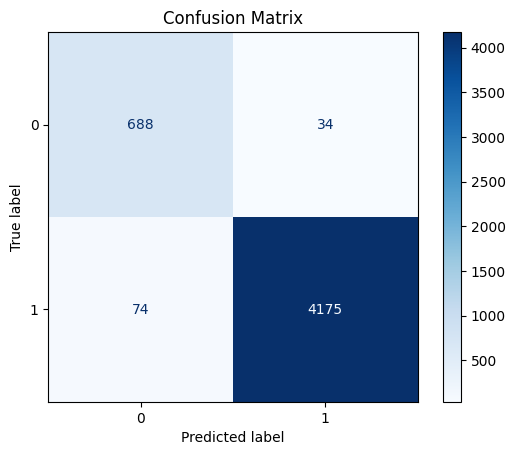

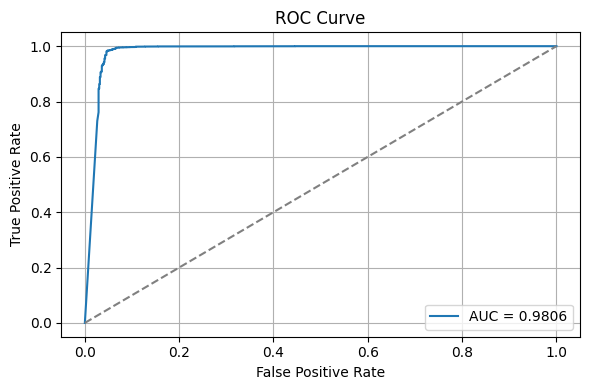

In [122]:
# Accuracy
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# AUC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC: {auc:.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss (and accuracy) curve for Default Neural Network

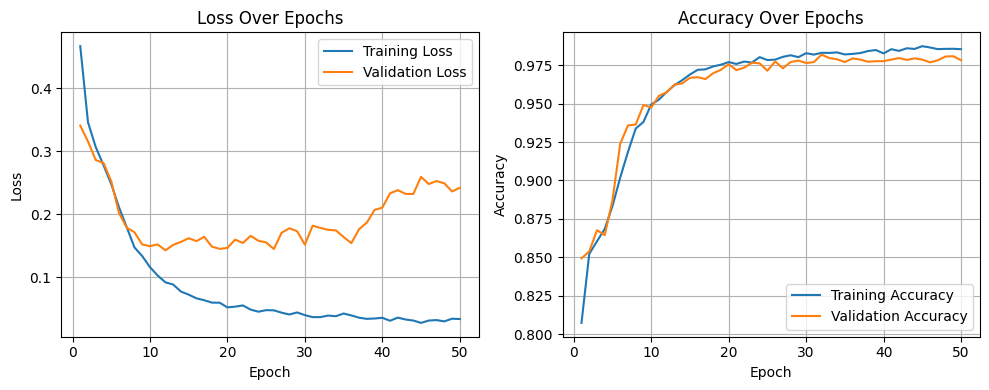

In [123]:
# Plot Loss and Accuracy Curves

# Extract values from the training history
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict.get('accuracy')  # Might be 'acc' in older Keras
val_acc = history_dict.get('val_accuracy')

epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Interpretation of loss (and accuracy) curves

# Hyperparameter tuning for Neural Network Stage 3

# Hyperparameter tuning of number of neurons, optimisers and activations functions - finding the best hyperparameters

In [124]:
# Define model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    # Tune number of units in first Dense layer
    units = hp.Choice('units', values=[32, 64, 128], default=64)
    model.add(Dense(units, activation=hp.Choice('activation', ['relu', 'tanh'], default='tanh'))) # Tune activation function to find the best nonlinearity for the data
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1, default=0.3)))

    # Second Dense layer adds capacity if needed (flexibility to increase complexity)
    if hp.Boolean('second_layer', default=True):
        units2 = hp.Int('units_2', min_value=16, max_value=64, step=16, default=32)
        model.add(Dense(units2, activation=hp.Choice('activation_2', ['relu', 'tanh'], default='tanh')))
        model.add(Dropout(hp.Float('dropout_2', 0.1, 0.3, step=0.1, default=0.2))) # The dropout ranges (0.1 to 0.5) help address potential overfitting seen in the fluctuating validation loss.
        # Additional dropout for the second layer to control overfitting
        dropout_2 = hp.Float('dropout_2', 0.1, 0.3, step=0.1, default=0.2)
        model.add(Dropout(dropout_2))
    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate (1e-4 to 1e-2) to optimize training convergence and stability
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log', default=1e-3)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model
    # With the use of compiled Keras Sequential models, the functionality can be configured
    # with different tunable layers, activations, dropout, and learning rates, which can then lead to training.

# Instantiate the tuner and perform tuning

In [125]:
# Clear old tuner results
import shutil
shutil.rmtree("hyperparam_tuning", ignore_errors=True)

# Instantiate tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='nn_imbalanced_data'
)

tuner.search(
    X_train_scaled, y_train,
    epochs=30, # Number of epochs to train each trial
    batch_size=32, # Number of samples per gradient update
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weight_dict, # Weights to handle class imbalance during training
    verbose=1
)

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.9656004905700684

Best val_accuracy So Far: 0.9810903072357178
Total elapsed time: 00h 08m 32s


# Retrieve the best-trained model and make predictions (probabilities) on the test data

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Best tuned model accuracy: 0.9811
Confusion Matrix:
[[ 674   48]
 [  46 4203]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9361    0.9335    0.9348       722
           1     0.9887    0.9892    0.9889      4249

    accuracy                         0.9811      4971
   macro avg     0.9624    0.9613    0.9619      4971
weighted avg     0.9811    0.9811    0.9811      4971

AUC Score: 0.9837


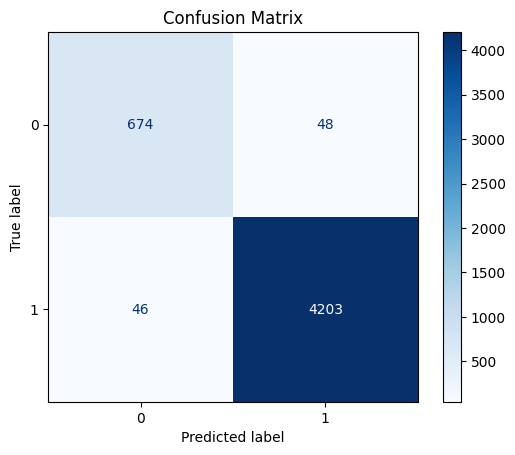

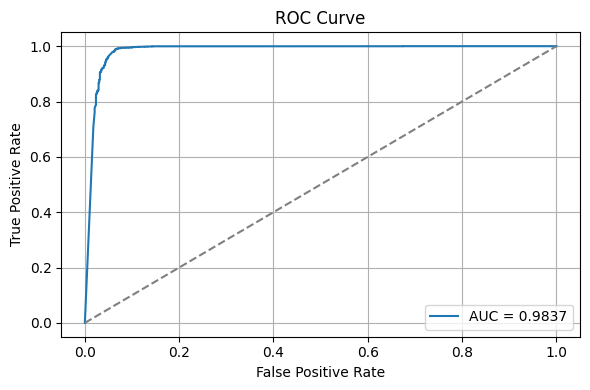

In [126]:
# Retrieve the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Predict probabilities on the test set
y_pred_probs = best_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_probs > 0.5).astype(int) # Convert probabilities to binary class predictions using 0.5 threshold

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)
auc_score = roc_auc_score(y_test, y_pred_probs)

# Print results
print(f"Best tuned model accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)
print(f"AUC Score: {auc_score:.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss (and accuracy) curve for Tuned Neural Network

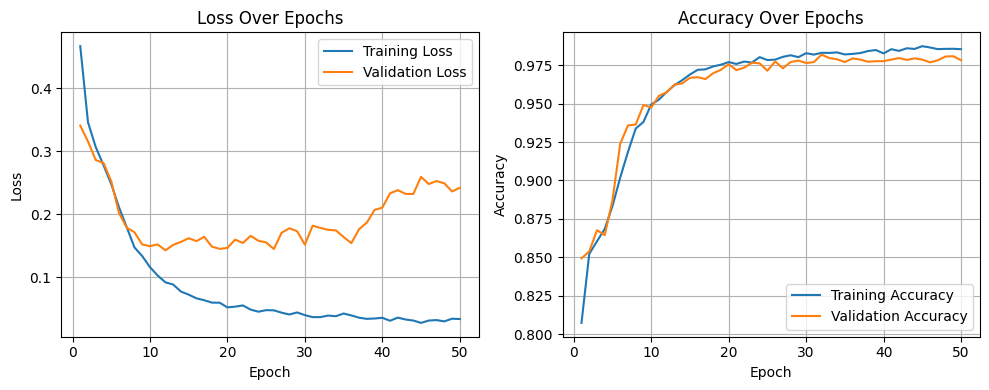

In [127]:
# Plot Loss and Accuracy Curves

# Extract values from the training history
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict.get('accuracy')  # Might be 'acc' in older Keras
val_acc = history_dict.get('val_accuracy')

epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Interpretation of loss (and accuracy) curves for Tuned Neural Network

# Compare Tuned vs Default Neural Network model

In [128]:
# Metrics from Neural Network default and tuned models (excluding macro/weighted F1-scores)
metrics = {
    "Metric": [
        "Accuracy",
        "AUC Score",
        "Precision (Class 0)",
        "Precision (Class 1)",
        "Recall (Class 0)",
        "Recall (Class 1)",
        "F1-Score (Class 0)",
        "F1-Score (Class 1)",
        "True Negatives (TN)",
        "False Positives (FP)",
        "False Negatives (FN)",
        "True Positives (TP)"
    ],
    "Default Model": [
        0.9773,
        0.9783,
        0.9166,
        0.9877,
        0.9280,
        0.9856,
        0.9222,
        0.9867,
        670,
        52,
        61,
        4188
    ],
    "Tuned Model": [
        0.8869,
        0.8787,
        0.6036,
        0.9479,
        0.7137,
        0.9174,
        0.6541,
        0.9324,
        536,
        215,
        352,
        3909
    ]
}

# Compute percentage changes
percent_change = []
for orig, tuned in zip(metrics["Default Model"], metrics["Tuned Model"]):  # updated here
    if orig == 0 or orig is None:
        percent_change.append(None)
    else:
        change = ((tuned - orig) / orig) * 100
        percent_change.append(change)

# Create DataFrame
df_nn = pd.DataFrame({
    "Metric": metrics["Metric"],
    "Default Model": metrics["Default Model"],  # updated here
    "Tuned Model": metrics["Tuned Model"],
    "% Change": percent_change
})

# Style the DataFrame
styled_df_nn = df_nn.style.format({
    "Default Model": "{:.4f}",  # updated here
    "Tuned Model": "{:.4f}",
    "% Change": lambda x: "" if pd.isnull(x) else f"{x:+.2f}%"
}).set_caption("Neural Network Performance Comparison").set_properties(**{'text-align': 'center'})

styled_df_nn

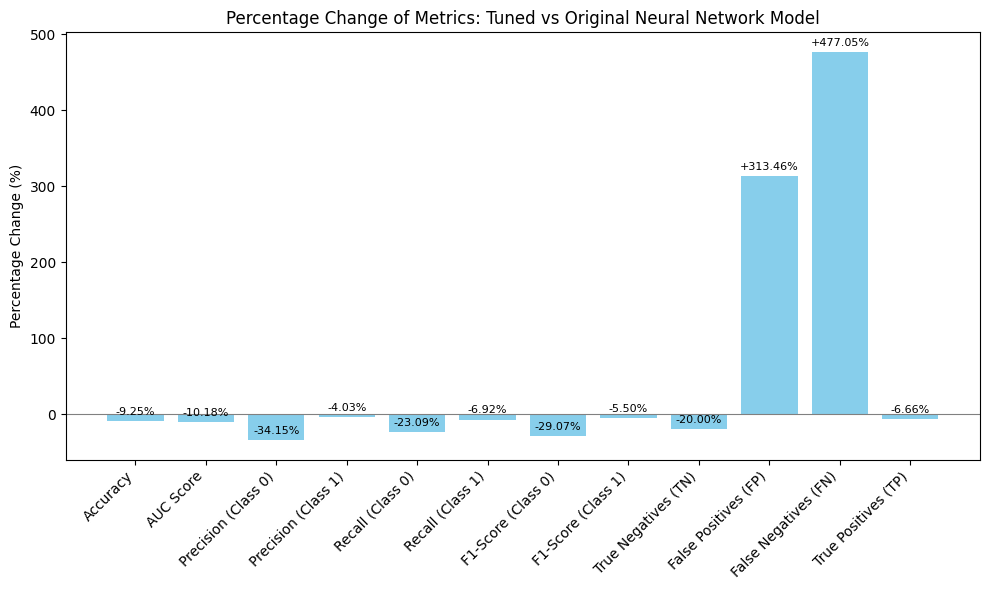

In [129]:
# Plotting
plt.figure(figsize=(10, 6))

bars = plt.bar(df_nn["Metric"], df_nn["% Change"], color='skyblue')

plt.axhline(0, color='gray', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage Change (%)")
plt.title("Percentage Change of Metrics: Tuned vs Original Neural Network Model")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:+.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Neural Networks for Stage 3 comparison - main observations

# Comparing performance of XGBoost and Neural Network models

Table 1: Default Models Comparison



Table 2: Tuned Models Comparison


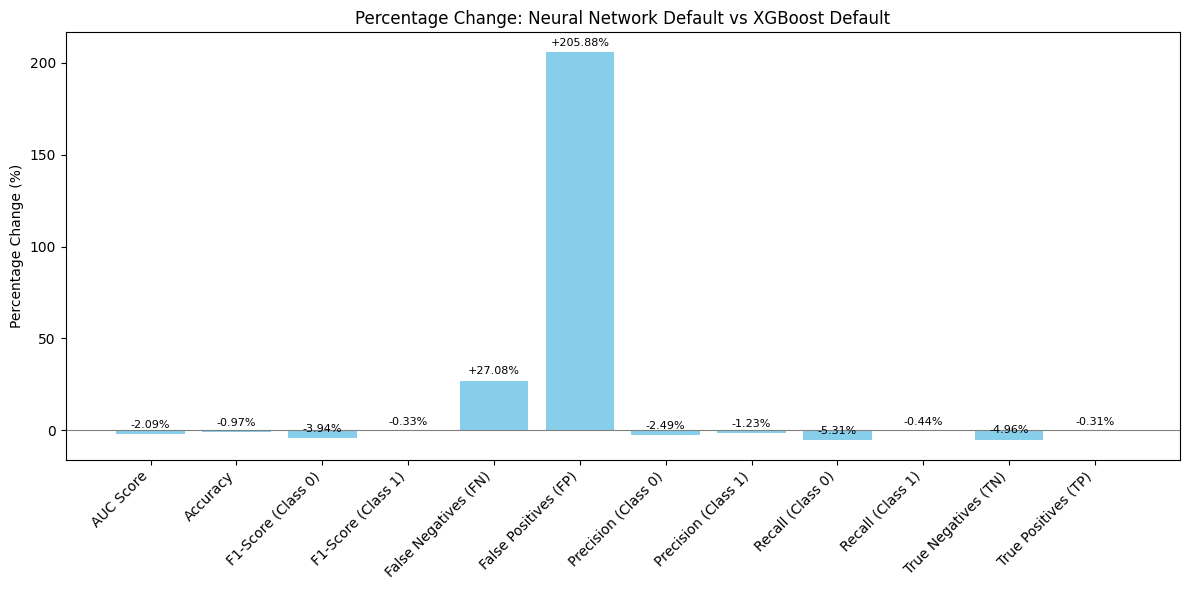

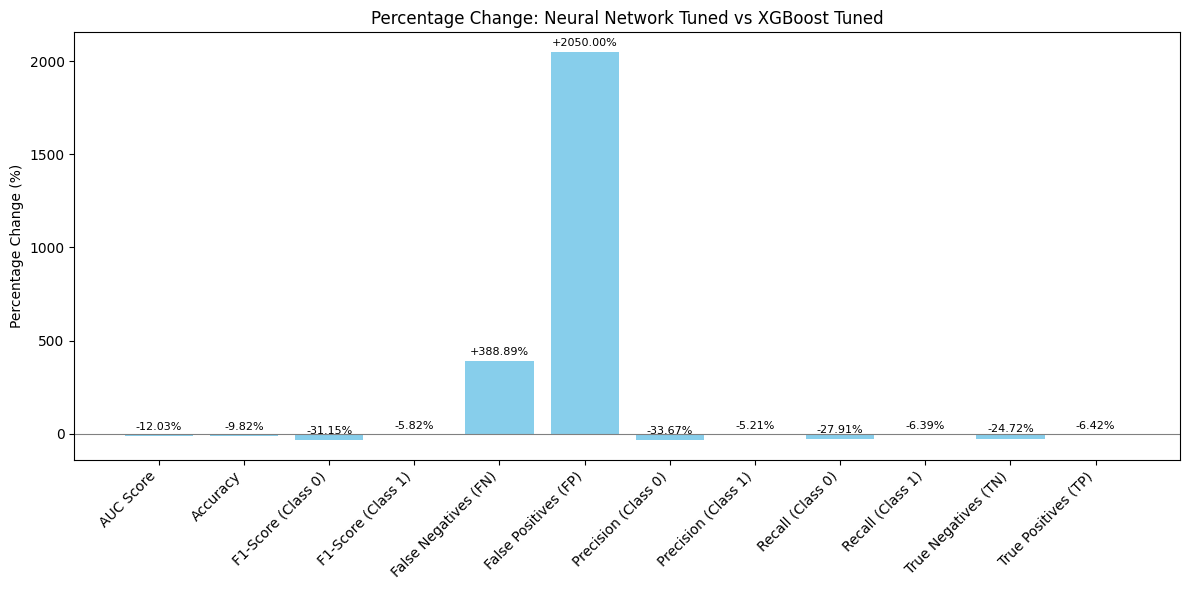

In [130]:
# Data for Neural Network including confusion matrix metrics
nn_metrics = {
    "Metric": [
        "Accuracy",
        "AUC Score",
        "Precision (Class 0)",
        "Recall (Class 0)",
        "F1-Score (Class 0)",
        "Precision (Class 1)",
        "Recall (Class 1)",
        "F1-Score (Class 1)",
        "True Negatives (TN)",
        "False Positives (FP)",
        "False Negatives (FN)",
        "True Positives (TP)"
    ],
    "Default Model": [
        0.9773,
        0.9783,
        0.9166,
        0.9280,
        0.9222,
        0.9877,
        0.9856,
        0.9867,
        670,
        52,
        61,
        4188
    ],
    "Tuned Model": [
        0.8869,
        0.8787,
        0.6036,
        0.7137,
        0.6541,
        0.9479,
        0.9174,
        0.9324,
        536,
        215,
        352,
        3909
    ]
}

# Data for XGBoost including confusion matrix metrics
xgb_metrics = {
    "Metric": [
        "Accuracy",
        "AUC Score",
        "Precision (Class 0)",
        "Recall (Class 0)",
        "F1-Score (Class 0)",
        "Precision (Class 1)",
        "Recall (Class 1)",
        "F1-Score (Class 1)",
        "True Negatives (TN)",
        "False Positives (FP)",
        "False Negatives (FN)",
        "True Positives (TP)"
    ],
    "Default Model": [
        0.9869,
        0.9992,
        0.9400,
        0.9800,
        0.9600,
        1.0000,
        0.9900,
        0.9900,
        705,
        17,
        48,
        4201
    ],
    "Tuned Model": [
        0.9835,
        0.9989,
        0.9100,
        0.9900,
        0.9500,
        1.0000,
        0.9800,
        0.9900,
        712,
        10,
        72,
        4177
    ]
}

# Convert to DataFrames
nn_df = pd.DataFrame(nn_metrics)
xgb_df = pd.DataFrame(xgb_metrics)

# Align metrics (in case order differs)
common_metrics = list(set(nn_df["Metric"]).intersection(xgb_df["Metric"]))
common_metrics.sort()

# Filter DataFrames to only common metrics in the same order
nn_df = nn_df[nn_df["Metric"].isin(common_metrics)].set_index("Metric").loc[common_metrics].reset_index()
xgb_df = xgb_df[xgb_df["Metric"].isin(common_metrics)].set_index("Metric").loc[common_metrics].reset_index()

# Function to compute percentage change: (NN - XGB) / XGB * 100
def percentage_change(nn_values, xgb_values):
    # To avoid division by zero, handle zero values
    changes = []
    for nn_val, xgb_val in zip(nn_values, xgb_values):
        if xgb_val == 0:
            changes.append(np.nan)
        else:
            changes.append(((nn_val - xgb_val) / xgb_val) * 100)
    return changes

# Table 1: Default Models Comparison
default_compare = pd.DataFrame({
    "Metric": common_metrics,
    "XGBoost Default": xgb_df["Default Model"].values,
    "Neural Net Default": nn_df["Default Model"].values
})
default_compare["% Change (NN vs XGB)"] = percentage_change(default_compare["Neural Net Default"], default_compare["XGBoost Default"])

# Table 2: Tuned Models Comparison
tuned_compare = pd.DataFrame({
    "Metric": common_metrics,
    "XGBoost Tuned": xgb_df["Tuned Model"].values,
    "Neural Net Tuned": nn_df["Tuned Model"].values
})
tuned_compare["% Change (NN vs XGB)"] = percentage_change(tuned_compare["Neural Net Tuned"], tuned_compare["XGBoost Tuned"])

# Format the percentage change column with +/– and 2 decimals for display
def format_percentage_change(df, col_name):
    return df.style.format({
        col_name: "{:+.2f}%"
    }).format(precision=4, subset=df.columns[1:-1]).set_properties(**{'text-align': 'center'})

# Display tables nicely formatted
print("Table 1: Default Models Comparison")
display(format_percentage_change(default_compare, "% Change (NN vs XGB)"))

print("\nTable 2: Tuned Models Comparison")
display(format_percentage_change(tuned_compare, "% Change (NN vs XGB)"))

# Plot function for bar chart of percentage changes
def plot_bar(df, title):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df["Metric"], df["% Change (NN vs XGB)"], color='skyblue')
    plt.axhline(0, color='gray', linewidth=0.8)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Percentage Change (%)")
    plt.title(title)
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            plt.annotate(f'{height:+.2f}%',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# Plot both bar charts
plot_bar(default_compare, "Percentage Change: Neural Network Default vs XGBoost Default")
plot_bar(tuned_compare, "Percentage Change: Neural Network Tuned vs XGBoost Tuned")


# Comparing performance metrics of Default and Tuned models (XGBoost and Neural Network)

# Comparison between Default models - XGBoost and Neural Network

# Comparison between Tuned models - XGBoost and Neural Network

# Compare the results of the XGBOOST and Neural network models on the Stage 2 datasets the Stage 3 dataset

# Accuracy Comparison for Mid-stage and Late-stage

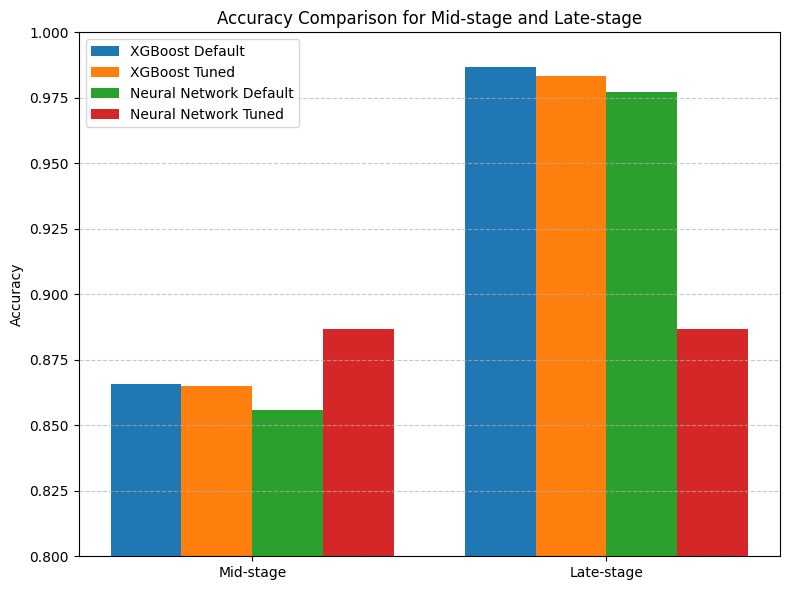

In [131]:
# Updated stage labels for only Mid-stage and Late-stage
stages = ['Mid-stage', 'Late-stage']

# Corresponding accuracy values only for stages 2 and 3 (index 1 and 2)
xgb_default = [0.8659, 0.9869]
xgb_tuned = [0.8651, 0.9835]
nn_default = [0.8559, 0.9773]
nn_tuned = [0.8869, 0.8869]

# Bar width and positions
bar_width = 0.2
x = np.arange(len(stages))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x - 1.5 * bar_width, xgb_default, width=bar_width, label='XGBoost Default')
ax.bar(x - 0.5 * bar_width, xgb_tuned, width=bar_width, label='XGBoost Tuned')
ax.bar(x + 0.5 * bar_width, nn_default, width=bar_width, label='Neural Network Default')
ax.bar(x + 1.5 * bar_width, nn_tuned, width=bar_width, label='Neural Network Tuned')

# Labels and formatting
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison for Mid-stage and Late-stage')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.8, 1.0)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


# AUC Score Comparison for Mid-stage and Late-stage

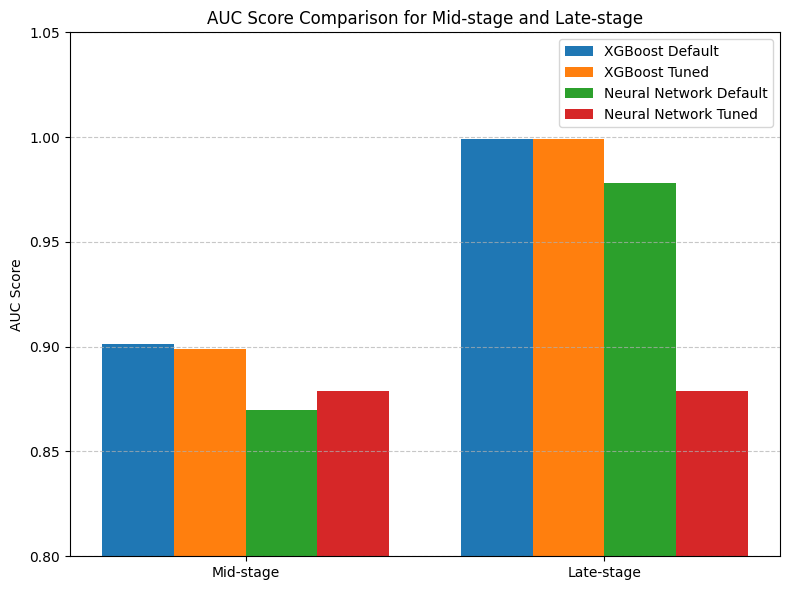

In [132]:
# Updated stage labels for only Mid-stage and Late-stage
stages = ['Mid-stage', 'Late-stage']

# Corresponding AUC values only for stages 2 and 3 (index 1 and 2)
xgb_default_auc = [0.9012, 0.9992]
xgb_tuned_auc = [0.8987, 0.9989]
nn_default_auc = [0.8696, 0.9783]
nn_tuned_auc = [0.8787, 0.8787]

# Bar width and positions
bar_width = 0.2
x = np.arange(len(stages))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x - 1.5 * bar_width, xgb_default_auc, width=bar_width, label='XGBoost Default')
ax.bar(x - 0.5 * bar_width, xgb_tuned_auc, width=bar_width, label='XGBoost Tuned')
ax.bar(x + 0.5 * bar_width, nn_default_auc, width=bar_width, label='Neural Network Default')
ax.bar(x + 1.5 * bar_width, nn_tuned_auc, width=bar_width, label='Neural Network Tuned')

# Labels and formatting
ax.set_ylabel('AUC Score')
ax.set_title('AUC Score Comparison for Mid-stage and Late-stage')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.8, 1.05)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

# Precision Comparison for Mid-stage and Late-stage Across Models and Classes

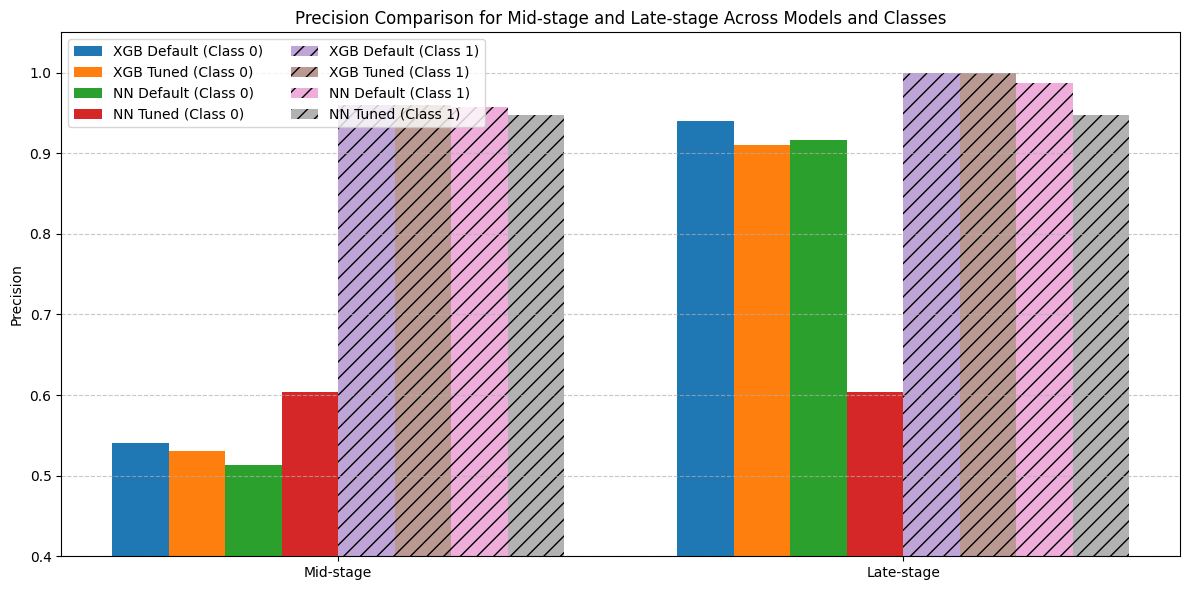

In [133]:
# Updated stage labels for Mid-stage and Late-stage only
stages = ['Mid-stage', 'Late-stage']

# Precision values for Class 0 (only indices 1 and 2)
xgb_default_prec_0 = [0.5400, 0.9400]
xgb_tuned_prec_0   = [0.5300, 0.9100]
nn_default_prec_0  = [0.5127, 0.9166]
nn_tuned_prec_0    = [0.6036, 0.6036]

# Precision values for Class 1 (only indices 1 and 2)
xgb_default_prec_1 = [0.9600, 1.0000]
xgb_tuned_prec_1   = [0.9600, 1.0000]
nn_default_prec_1  = [0.9571, 0.9877]
nn_tuned_prec_1    = [0.9479, 0.9479]

# Bar width and positions
bar_width = 0.1
x = np.arange(len(stages))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Grouped bars for Class 0
ax.bar(x - 3.5 * bar_width, xgb_default_prec_0, width=bar_width, label='XGB Default (Class 0)')
ax.bar(x - 2.5 * bar_width, xgb_tuned_prec_0, width=bar_width, label='XGB Tuned (Class 0)')
ax.bar(x - 1.5 * bar_width, nn_default_prec_0, width=bar_width, label='NN Default (Class 0)')
ax.bar(x - 0.5 * bar_width, nn_tuned_prec_0, width=bar_width, label='NN Tuned (Class 0)')

# Grouped bars for Class 1 (with hatch and alpha)
ax.bar(x + 0.5 * bar_width, xgb_default_prec_1, width=bar_width, label='XGB Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 1.5 * bar_width, xgb_tuned_prec_1, width=bar_width, label='XGB Tuned (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 2.5 * bar_width, nn_default_prec_1, width=bar_width, label='NN Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 3.5 * bar_width, nn_tuned_prec_1, width=bar_width, label='NN Tuned (Class 1)', alpha=0.6, hatch='//')

# Labels and formatting
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison for Mid-stage and Late-stage Across Models and Classes')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.4, 1.05)
ax.legend(ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

# Recall Comparison for Mid-stage and Late-stage Across Models and Classes

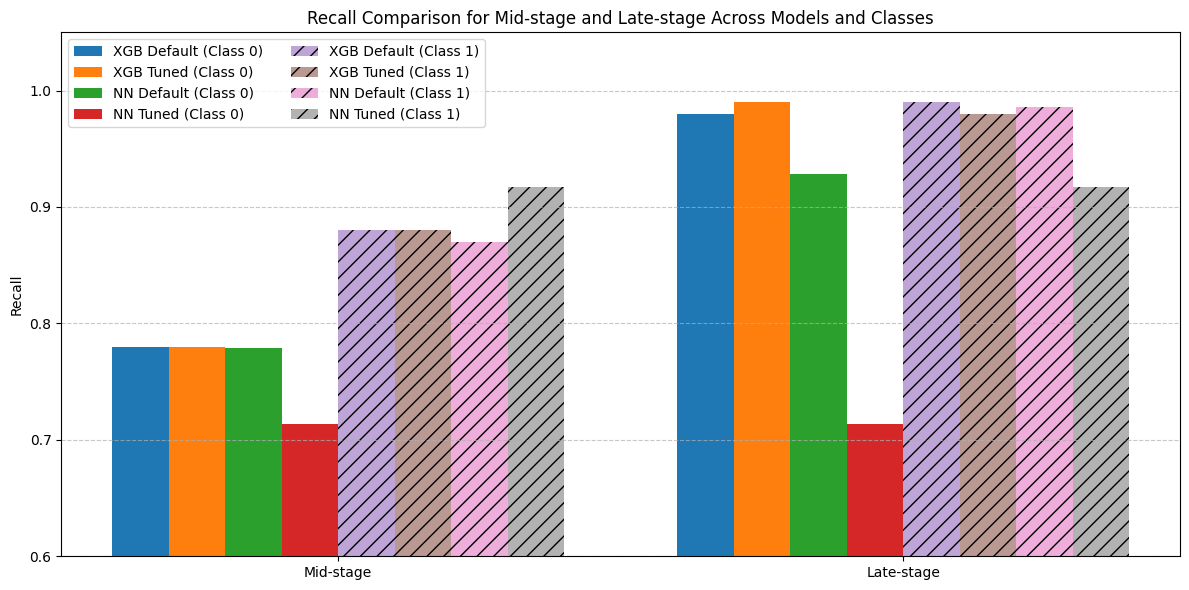

In [134]:
# Updated stage labels for Mid-stage and Late-stage only
stages = ['Mid-stage', 'Late-stage']

# Recall values for Class 0 (indices 1 and 2)
xgb_default_recall_0 = [0.7800, 0.9800]
xgb_tuned_recall_0   = [0.7800, 0.9900]
nn_default_recall_0  = [0.7790, 0.9280]
nn_tuned_recall_0    = [0.7137, 0.7137]

# Recall values for Class 1 (indices 1 and 2)
xgb_default_recall_1 = [0.8800, 0.9900]
xgb_tuned_recall_1   = [0.8800, 0.9800]
nn_default_recall_1  = [0.8695, 0.9856]
nn_tuned_recall_1    = [0.9174, 0.9174]

# Bar width and positions
bar_width = 0.1
x = np.arange(len(stages))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Class 0 Recall bars
ax.bar(x - 3.5 * bar_width, xgb_default_recall_0, width=bar_width, label='XGB Default (Class 0)')
ax.bar(x - 2.5 * bar_width, xgb_tuned_recall_0, width=bar_width, label='XGB Tuned (Class 0)')
ax.bar(x - 1.5 * bar_width, nn_default_recall_0, width=bar_width, label='NN Default (Class 0)')
ax.bar(x - 0.5 * bar_width, nn_tuned_recall_0, width=bar_width, label='NN Tuned (Class 0)')

# Class 1 Recall bars (hatch and transparency)
ax.bar(x + 0.5 * bar_width, xgb_default_recall_1, width=bar_width, label='XGB Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 1.5 * bar_width, xgb_tuned_recall_1, width=bar_width, label='XGB Tuned (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 2.5 * bar_width, nn_default_recall_1, width=bar_width, label='NN Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 3.5 * bar_width, nn_tuned_recall_1, width=bar_width, label='NN Tuned (Class 1)', alpha=0.6, hatch='//')

# Labels and formatting
ax.set_ylabel('Recall')
ax.set_title('Recall Comparison for Mid-stage and Late-stage Across Models and Classes')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.6, 1.05)
ax.legend(ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

# Confusion Matrix Components Comparison for Mid-stage and Late-stage Across Models

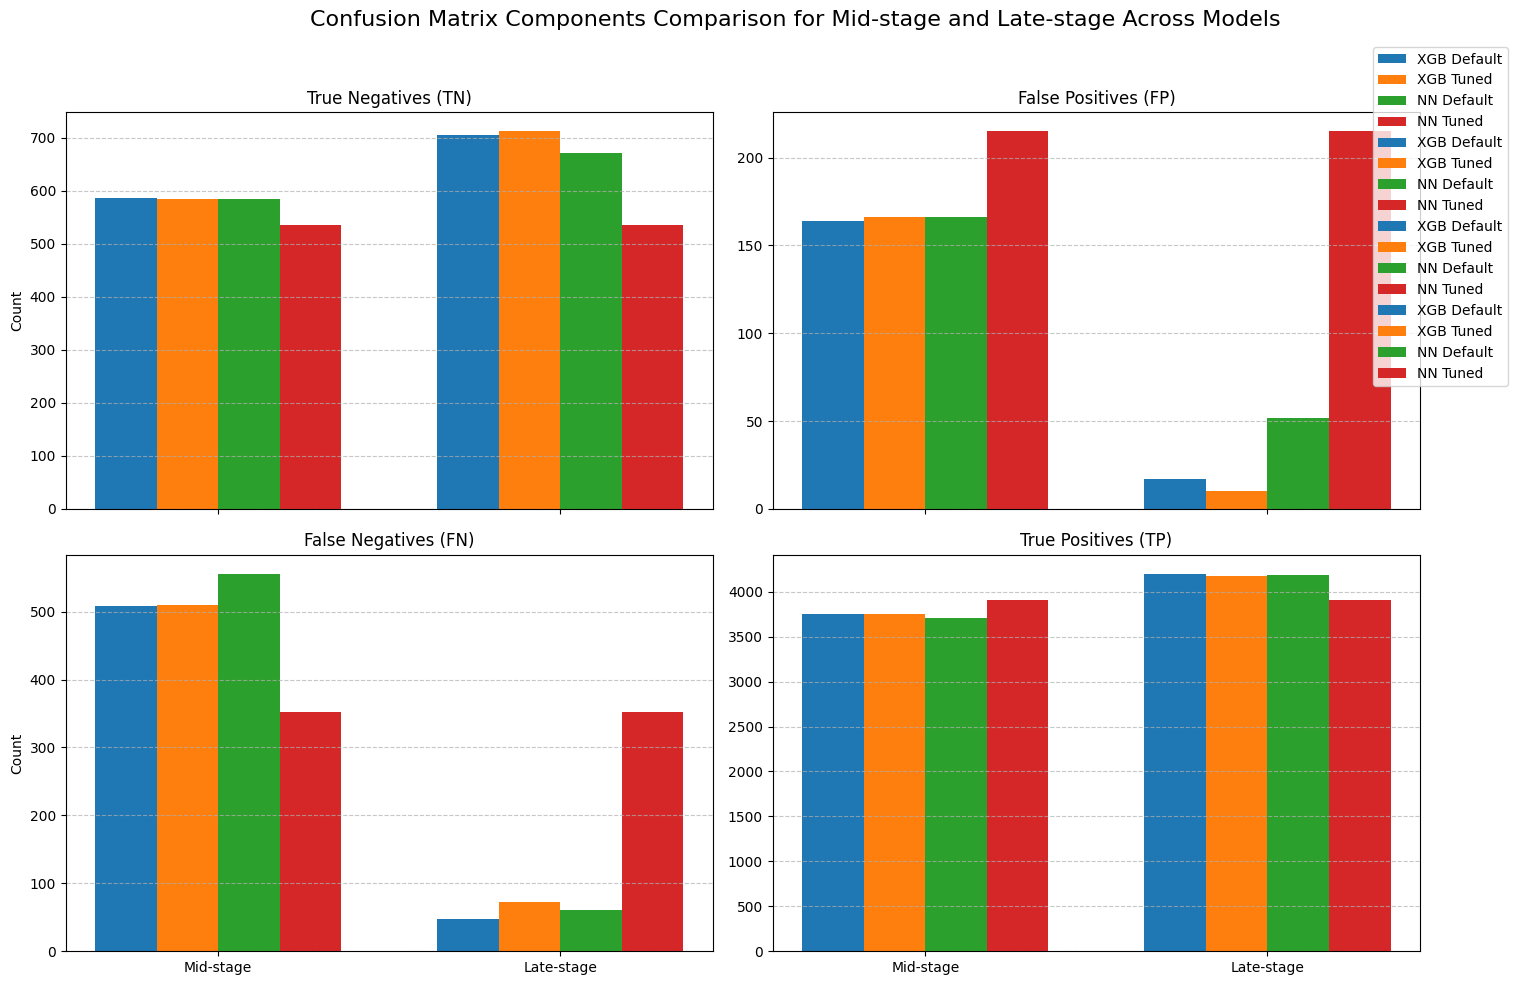

In [135]:
# Updated stage labels for Mid-stage and Late-stage only
stages = ['Mid-stage', 'Late-stage']
cm_metrics = ['TN', 'FP', 'FN', 'TP']

# Confusion matrix data filtered for stages 1 and 2
xgb_default_cm = {
    'TN': [587, 705],
    'FP': [164, 17],
    'FN': [508, 48],
    'TP': [3753, 4201]
}

xgb_tuned_cm = {
    'TN': [585, 712],
    'FP': [166, 10],
    'FN': [510, 72],
    'TP': [3751, 4177]
}

nn_default_cm = {
    'TN': [585, 670],
    'FP': [166, 52],
    'FN': [556, 61],
    'TP': [3705, 4188]
}

nn_tuned_cm = {
    'TN': [536, 536],
    'FP': [215, 215],
    'FN': [352, 352],
    'TP': [3909, 3909]
}

bar_width = 0.18
x = np.arange(len(stages))

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# Full names for metrics for titles
full_names = {
    'TN': 'True Negatives (TN)',
    'FP': 'False Positives (FP)',
    'FN': 'False Negatives (FN)',
    'TP': 'True Positives (TP)'
}

for i, metric in enumerate(cm_metrics):
    ax = axs[i // 2, i % 2]

    ax.bar(x - 1.5*bar_width, xgb_default_cm[metric], width=bar_width, label='XGB Default')
    ax.bar(x - 0.5*bar_width, xgb_tuned_cm[metric], width=bar_width, label='XGB Tuned')
    ax.bar(x + 0.5*bar_width, nn_default_cm[metric], width=bar_width, label='NN Default')
    ax.bar(x + 1.5*bar_width, nn_tuned_cm[metric], width=bar_width, label='NN Tuned')

    ax.set_title(full_names[metric])
    ax.set_xticks(x)
    ax.set_xticklabels(stages)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    if i % 2 == 0:
        ax.set_ylabel('Count')

fig.suptitle('Confusion Matrix Components Comparison for Mid-stage and Late-stage Across Models', fontsize=16)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# F1-Score Comparison for Mid-stage and Late-stage Across Models and Classes

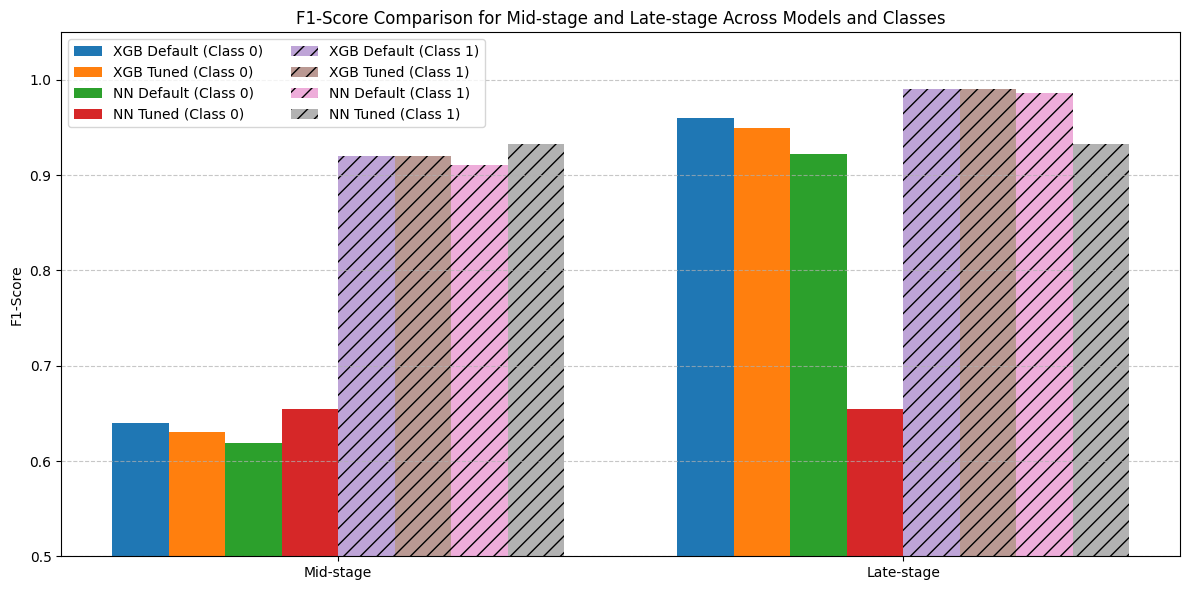

In [136]:
# Updated stages for Mid-stage and Late-stage only
stages = ['Mid-stage', 'Late-stage']

# Filtered F1-Score values for stages 1 and 2
xgb_default_f1_0 = [0.6400, 0.9600]
xgb_tuned_f1_0   = [0.6300, 0.9500]
nn_default_f1_0  = [0.6184, 0.9222]
nn_tuned_f1_0    = [0.6541, 0.6541]

xgb_default_f1_1 = [0.9200, 0.9900]
xgb_tuned_f1_1   = [0.9200, 0.9900]
nn_default_f1_1  = [0.9112, 0.9867]
nn_tuned_f1_1    = [0.9324, 0.9324]

bar_width = 0.1
x = np.arange(len(stages))

fig, ax = plt.subplots(figsize=(12, 6))

# Class 0 F1-Score bars
ax.bar(x - 3.5 * bar_width, xgb_default_f1_0, width=bar_width, label='XGB Default (Class 0)')
ax.bar(x - 2.5 * bar_width, xgb_tuned_f1_0, width=bar_width, label='XGB Tuned (Class 0)')
ax.bar(x - 1.5 * bar_width, nn_default_f1_0, width=bar_width, label='NN Default (Class 0)')
ax.bar(x - 0.5 * bar_width, nn_tuned_f1_0, width=bar_width, label='NN Tuned (Class 0)')

# Class 1 F1-Score bars (hatch and transparency)
ax.bar(x + 0.5 * bar_width, xgb_default_f1_1, width=bar_width, label='XGB Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 1.5 * bar_width, xgb_tuned_f1_1, width=bar_width, label='XGB Tuned (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 2.5 * bar_width, nn_default_f1_1, width=bar_width, label='NN Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 3.5 * bar_width, nn_tuned_f1_1, width=bar_width, label='NN Tuned (Class 1)', alpha=0.6, hatch='//')

# Labels and formatting
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Comparison for Mid-stage and Late-stage Across Models and Classes')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.5, 1.05)
ax.legend(ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Why might we find different prediction metrics in Mid-stage and Late-stage dropout? (Explain why the results are different)

# Compare the results of the XGBOOST and Neural network models across all three Stages

# Accuracy Comparison Across Stages and Models

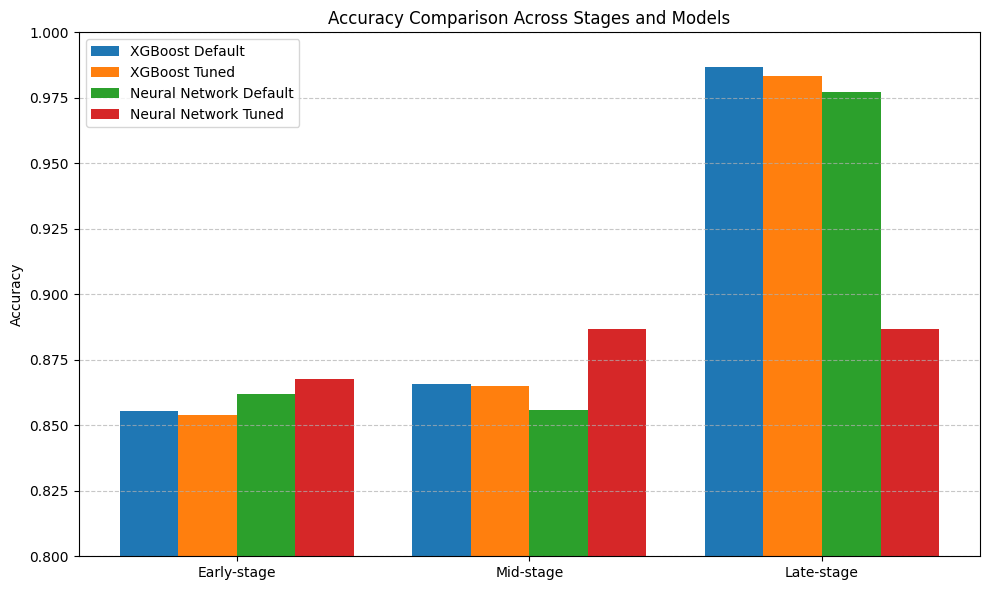

In [137]:
# Updated stage labels
stages = ['Early-stage', 'Mid-stage', 'Late-stage']
xgb_default = [0.8553, 0.8659, 0.9869]
xgb_tuned = [0.8538, 0.8651, 0.9835]
nn_default = [0.8619, 0.8559, 0.9773]
nn_tuned = [0.8675, 0.8869, 0.8869]

# Bar width and positions
bar_width = 0.2
x = np.arange(len(stages))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5 * bar_width, xgb_default, width=bar_width, label='XGBoost Default')
ax.bar(x - 0.5 * bar_width, xgb_tuned, width=bar_width, label='XGBoost Tuned')
ax.bar(x + 0.5 * bar_width, nn_default, width=bar_width, label='Neural Network Default')
ax.bar(x + 1.5 * bar_width, nn_tuned, width=bar_width, label='Neural Network Tuned')

# Labels and formatting
#ax.set_xlabel('Stage')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison Across Stages and Models')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.8, 1.0)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

# AUC Score Comparison Across Stages and Models

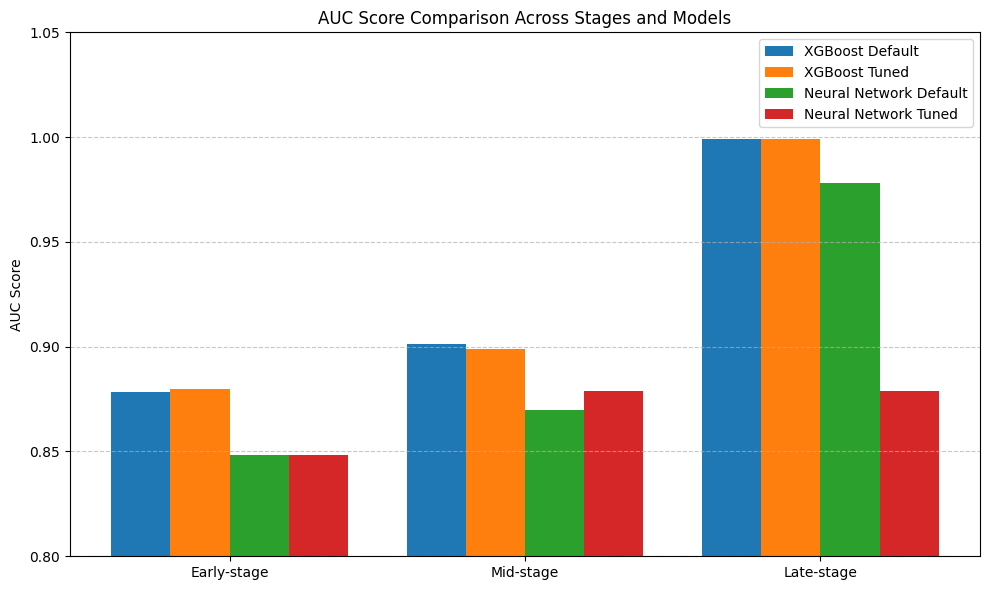

In [138]:
# Updated stage labels
stages = ['Early-stage', 'Mid-stage', 'Late-stage']

# AUC values from your data
xgb_default_auc = [0.8785, 0.9012, 0.9992]
xgb_tuned_auc = [0.8798, 0.8987, 0.9989]
nn_default_auc = [0.8482, 0.8696, 0.9783]
nn_tuned_auc = [0.8481, 0.8787, 0.8787]

# Bar width and positions
bar_width = 0.2
x = np.arange(len(stages))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5 * bar_width, xgb_default_auc, width=bar_width, label='XGBoost Default')
ax.bar(x - 0.5 * bar_width, xgb_tuned_auc, width=bar_width, label='XGBoost Tuned')
ax.bar(x + 0.5 * bar_width, nn_default_auc, width=bar_width, label='Neural Network Default')
ax.bar(x + 1.5 * bar_width, nn_tuned_auc, width=bar_width, label='Neural Network Tuned')

# Labels and formatting
# ax.set_xlabel('Stage')
ax.set_ylabel('AUC Score')
ax.set_title('AUC Score Comparison Across Stages and Models')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.8, 1.05)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

# Precision Comparison Across Stages, Models, and Classes

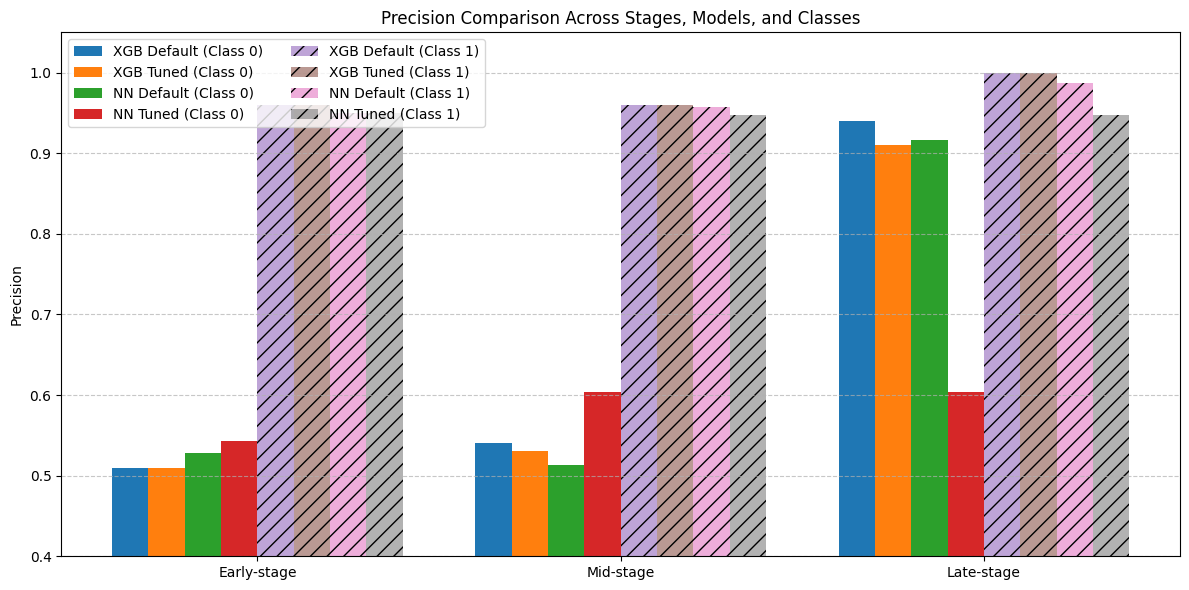

In [139]:
# Updated stage labels
stages = ['Early-stage', 'Mid-stage', 'Late-stage']

# Precision values for Class 0
xgb_default_prec_0 = [0.5100, 0.5400, 0.9400]
xgb_tuned_prec_0   = [0.5100, 0.5300, 0.9100]
nn_default_prec_0  = [0.5281, 0.5127, 0.9166]
nn_tuned_prec_0    = [0.5429, 0.6036, 0.6036]

# Precision values for Class 1
xgb_default_prec_1 = [0.9600, 0.9600, 1.0000]
xgb_tuned_prec_1   = [0.9600, 0.9600, 1.0000]
nn_default_prec_1  = [0.9503, 0.9571, 0.9877]
nn_tuned_prec_1    = [0.9500, 0.9479, 0.9479]

# Bar width and positions
bar_width = 0.1
x = np.arange(len(stages))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Grouped bars
ax.bar(x - 3.5 * bar_width, xgb_default_prec_0, width=bar_width, label='XGB Default (Class 0)')
ax.bar(x - 2.5 * bar_width, xgb_tuned_prec_0, width=bar_width, label='XGB Tuned (Class 0)')
ax.bar(x - 1.5 * bar_width, nn_default_prec_0, width=bar_width, label='NN Default (Class 0)')
ax.bar(x - 0.5 * bar_width, nn_tuned_prec_0, width=bar_width, label='NN Tuned (Class 0)')

ax.bar(x + 0.5 * bar_width, xgb_default_prec_1, width=bar_width, label='XGB Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 1.5 * bar_width, xgb_tuned_prec_1, width=bar_width, label='XGB Tuned (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 2.5 * bar_width, nn_default_prec_1, width=bar_width, label='NN Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 3.5 * bar_width, nn_tuned_prec_1, width=bar_width, label='NN Tuned (Class 1)', alpha=0.6, hatch='//')

# Labels and formatting
# ax.set_xlabel('Stage')
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison Across Stages, Models, and Classes')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.4, 1.05)
ax.legend(ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

# Recall Comparison Across Stages, Models, and Classes

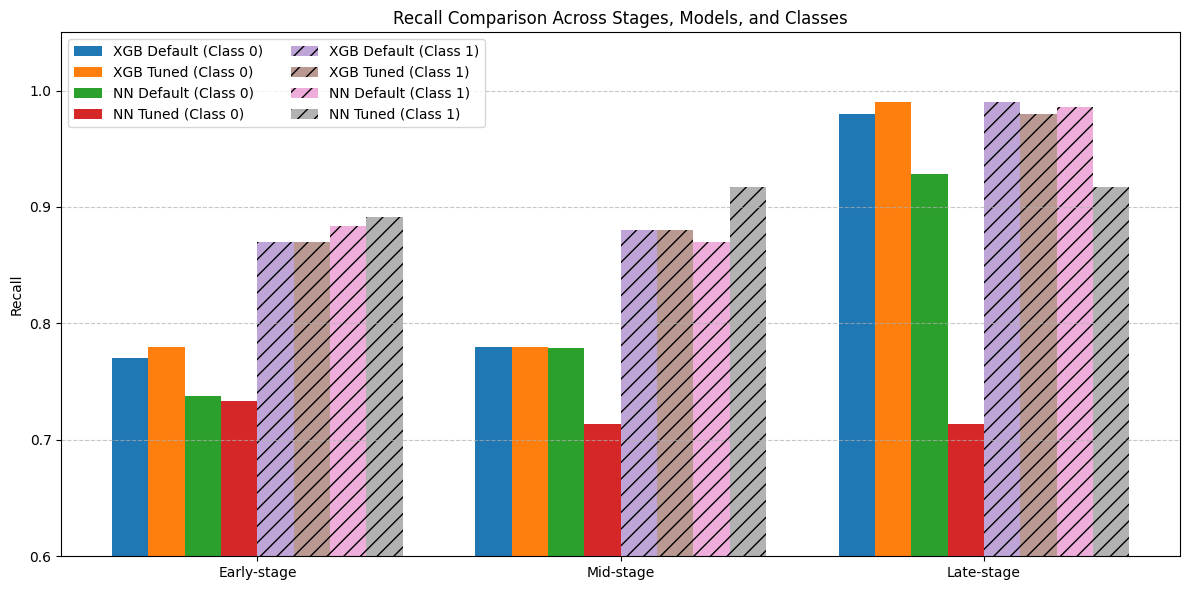

In [140]:
# Stage labels
stages = ['Early-stage', 'Mid-stage', 'Late-stage']

# Recall values for Class 0
xgb_default_recall_0 = [0.7700, 0.7800, 0.9800]
xgb_tuned_recall_0   = [0.7796, 0.7800, 0.9900]
nn_default_recall_0  = [0.7377, 0.7790, 0.9280]
nn_tuned_recall_0    = [0.7337, 0.7137, 0.7137]

# Recall values for Class 1
xgb_default_recall_1 = [0.8700, 0.8800, 0.9900]
xgb_tuned_recall_1   = [0.8700, 0.8800, 0.9800]
nn_default_recall_1  = [0.8838, 0.8695, 0.9856]
nn_tuned_recall_1    = [0.8911, 0.9174, 0.9174]

# Bar width and positions
bar_width = 0.1
x = np.arange(len(stages))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Class 0 Recall bars
ax.bar(x - 3.5 * bar_width, xgb_default_recall_0, width=bar_width, label='XGB Default (Class 0)')
ax.bar(x - 2.5 * bar_width, xgb_tuned_recall_0, width=bar_width, label='XGB Tuned (Class 0)')
ax.bar(x - 1.5 * bar_width, nn_default_recall_0, width=bar_width, label='NN Default (Class 0)')
ax.bar(x - 0.5 * bar_width, nn_tuned_recall_0, width=bar_width, label='NN Tuned (Class 0)')

# Class 1 Recall bars (hatch and transparency)
ax.bar(x + 0.5 * bar_width, xgb_default_recall_1, width=bar_width, label='XGB Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 1.5 * bar_width, xgb_tuned_recall_1, width=bar_width, label='XGB Tuned (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 2.5 * bar_width, nn_default_recall_1, width=bar_width, label='NN Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 3.5 * bar_width, nn_tuned_recall_1, width=bar_width, label='NN Tuned (Class 1)', alpha=0.6, hatch='//')

# Labels and formatting
# ax.set_xlabel('Stage')
ax.set_ylabel('Recall')
ax.set_title('Recall Comparison Across Stages, Models, and Classes')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.6, 1.05)
ax.legend(ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

# Confusion Matrix Components Comparison Across Stages and Models

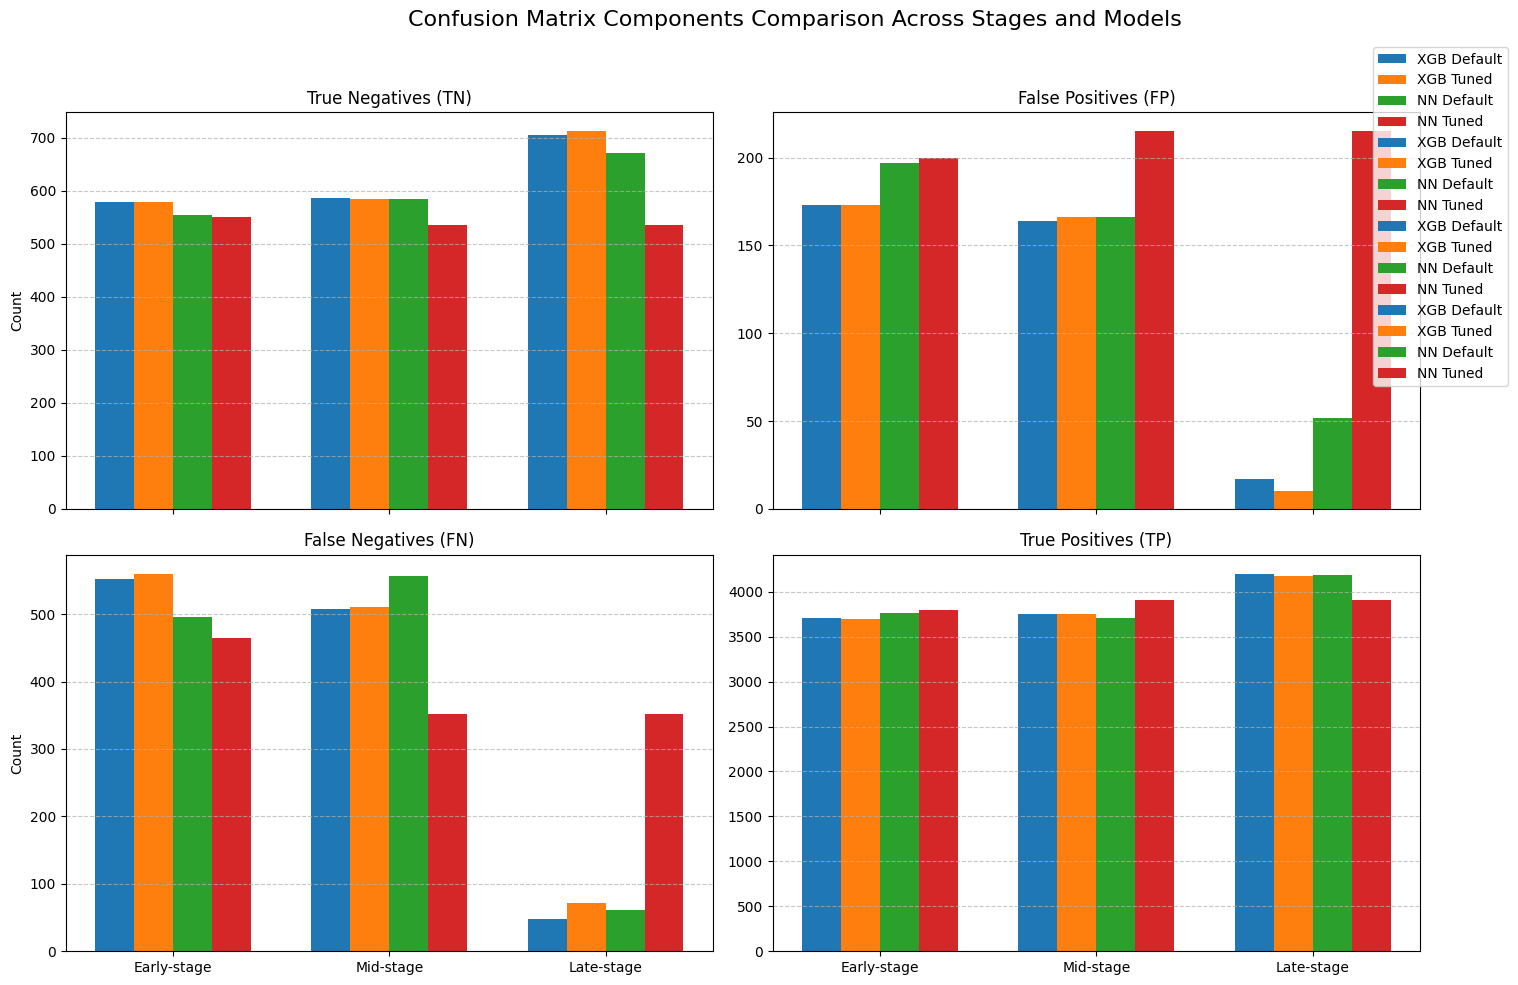

In [141]:
stages = ['Early-stage', 'Mid-stage', 'Late-stage']
cm_metrics = ['TN', 'FP', 'FN', 'TP']  # Use these keys instead

# Confusion matrix data (default and tuned) for each model and stage
xgb_default_cm = {
    'TN': [578, 587, 705],
    'FP': [173, 164, 17],
    'FN': [552, 508, 48],
    'TP': [3709, 3753, 4201]
}

xgb_tuned_cm = {
    'TN': [578, 585, 712],
    'FP': [173, 166, 10],
    'FN': [560, 510, 72],
    'TP': [3701, 3751, 4177]
}

nn_default_cm = {
    'TN': [554, 585, 670],
    'FP': [197, 166, 52],
    'FN': [495, 556, 61],
    'TP': [3766, 3705, 4188]
}

nn_tuned_cm = {
    'TN': [551, 536, 536],
    'FP': [200, 215, 215],
    'FN': [464, 352, 352],
    'TP': [3797, 3909, 3909]
}

bar_width = 0.18
x = np.arange(len(stages))

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# For prettier titles, map short keys to full names
full_names = {
    'TN': 'True Negatives (TN)',
    'FP': 'False Positives (FP)',
    'FN': 'False Negatives (FN)',
    'TP': 'True Positives (TP)'
}

for i, metric in enumerate(cm_metrics):
    ax = axs[i // 2, i % 2]

    ax.bar(x - 1.5*bar_width, [xgb_default_cm[metric][j] for j in range(3)], width=bar_width, label='XGB Default')
    ax.bar(x - 0.5*bar_width, [xgb_tuned_cm[metric][j] for j in range(3)], width=bar_width, label='XGB Tuned')
    ax.bar(x + 0.5*bar_width, [nn_default_cm[metric][j] for j in range(3)], width=bar_width, label='NN Default')
    ax.bar(x + 1.5*bar_width, [nn_tuned_cm[metric][j] for j in range(3)], width=bar_width, label='NN Tuned')

    ax.set_title(full_names[metric])
    ax.set_xticks(x)
    ax.set_xticklabels(stages)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    if i % 2 == 0:
        ax.set_ylabel('Count')

fig.suptitle('Confusion Matrix Components Comparison Across Stages and Models', fontsize=16)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95))
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# F1-Score Comparison Across Stages, Models, and Classes

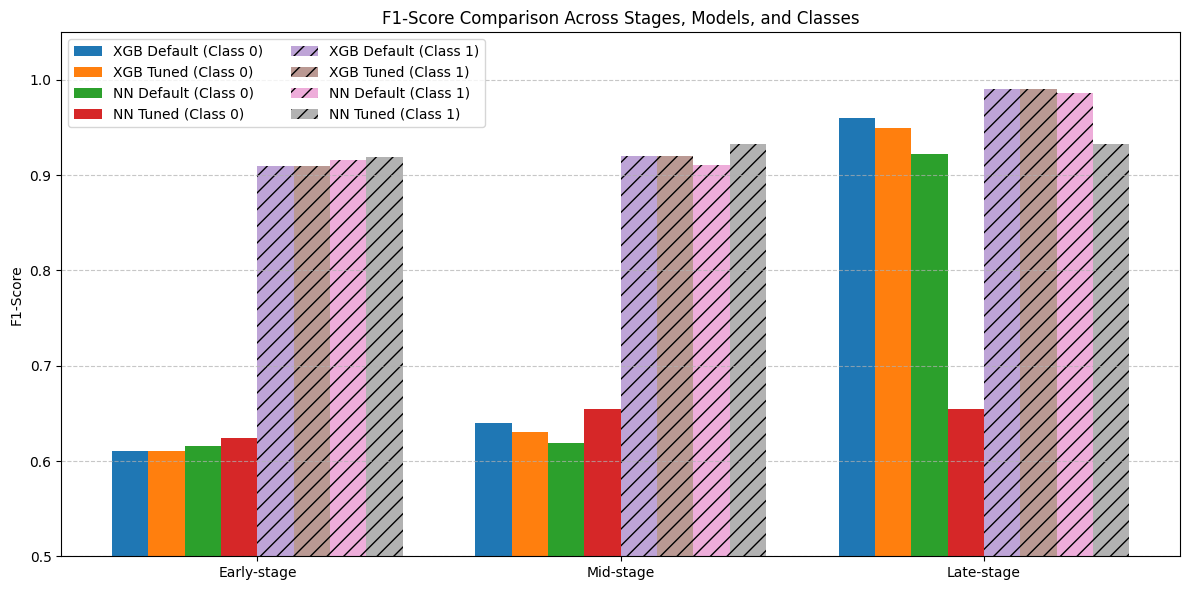

In [142]:
# Stage labels
stages = ['Early-stage', 'Mid-stage', 'Late-stage']

# F1-Score values for Class 0
xgb_default_f1_0 = [0.6100, 0.6400, 0.9600]
xgb_tuned_f1_0   = [0.6100, 0.6300, 0.9500]
nn_default_f1_0  = [0.6156, 0.6184, 0.9222]
nn_tuned_f1_0    = [0.6240, 0.6541, 0.6541]

# F1-Score values for Class 1
xgb_default_f1_1 = [0.9100, 0.9200, 0.9900]
xgb_tuned_f1_1   = [0.9100, 0.9200, 0.9900]
nn_default_f1_1  = [0.9159, 0.9112, 0.9867]
nn_tuned_f1_1    = [0.9196, 0.9324, 0.9324]

# Bar width and positions
bar_width = 0.1
x = np.arange(len(stages))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Class 0 F1-Score bars
ax.bar(x - 3.5 * bar_width, xgb_default_f1_0, width=bar_width, label='XGB Default (Class 0)')
ax.bar(x - 2.5 * bar_width, xgb_tuned_f1_0, width=bar_width, label='XGB Tuned (Class 0)')
ax.bar(x - 1.5 * bar_width, nn_default_f1_0, width=bar_width, label='NN Default (Class 0)')
ax.bar(x - 0.5 * bar_width, nn_tuned_f1_0, width=bar_width, label='NN Tuned (Class 0)')

# Class 1 F1-Score bars (hatch and transparency)
ax.bar(x + 0.5 * bar_width, xgb_default_f1_1, width=bar_width, label='XGB Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 1.5 * bar_width, xgb_tuned_f1_1, width=bar_width, label='XGB Tuned (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 2.5 * bar_width, nn_default_f1_1, width=bar_width, label='NN Default (Class 1)', alpha=0.6, hatch='//')
ax.bar(x + 3.5 * bar_width, nn_tuned_f1_1, width=bar_width, label='NN Tuned (Class 1)', alpha=0.6, hatch='//')

# Labels and formatting
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Comparison Across Stages, Models, and Classes')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylim(0.5, 1.05)
ax.legend(ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()